# Workflow to Validate OPERA DISP-S1 Transient Displacement Requirements

**Original code authored by:** NISAR Science Team Members and Affiliates  
**Updated by:** OPERA DISP-S1 CalVal team

*July 2024*

*OPERA DISP-S1 CalVal team*

<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>

<hr/>

## Define CalVal Site 

In [1]:
# Parameters for papermill

site = 'F11116'     # site for DISP-S1 (rame ID)
work_dir = './'
mintpy_dir = 'mintpy_output'    # location of mintpy files 
inputs_dir = 'inputs'           # directory of ifgramStack.h5 inside mintpy_dir
output_dir = 'results'          # location to store output figures and text files
vmin = -50  # vmin/vmax for plotting
vmax = 50

calval_sites_csv = 'validation_data/DISP-S1_CalVal_sites.csv'

time_interval_thr = 12    # time interval threshold: only temporal baselines equal or less than 12 days are considered

# Mask file used for validation
maskFile = 'mask_temporalCoherence.h5' # maskSpatialCoh.h5, inputs/combined_msk.h5

# Define spatial coherence threshold (necessary to reject poor quality, long temporal baseline pairs)
minCoherence_parm = '0.6'
minTempCoherence_parm = '0.6'

#Set GNSS Parameters
gps_completeness_threshold = 0.8    #0.9  #percent of data timespan with valid GNSS epochs
gps_residual_stdev_threshold = 10.  #0.03  #0.03  #max threshold standard deviation of residuals to linear GNSS fit

#variability score threshold
apply_nonlinear_mask = True     # if apply non linear score mask
thr_var_score = 0.6      # variability score threshold

In [2]:
# load packages
import os
from datetime import datetime as dt
from pathlib import Path
import itertools

import copy
import random

import h5py

import numpy as np
import pandas as pd
from scipy import signal
import matplotlib
import matplotlib.colors
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 12})

# multi-processing related packages
import multiprocessing
from itertools import product
from functools import partial
from tqdm import tqdm
import psutil
ncpus = len(psutil.Process().cpu_affinity())    # number of available CPUs
print("number of available CPUs: ", ncpus)

from mintpy.objects import gnss
from mintpy.utils import readfile, utils as ut, utils0 as ut0
from mintpy.cli import view, generate_mask

from solid_utils.sampling import load_geo_utm, samp_pair, euclidean_distance
from solid_utils.plotting import plot_transient_table

import warnings
warnings.filterwarnings("ignore")

number of available CPUs:  128


## Table of Contents:
<a id='secular_TOC'></a>

<hr/>

[**Prep A. Environment Setup**](#transient_prep_a)

[**Prep B. Data Staging**](#transient_prep_b)

[**1. Generate DISP-S1 Stack**](#transient_gen_ifg)
- [1.1.  Crop DISP-S1s](#transient_crop_ifg)

[**2. Optional Corrections**](#transient_opt_correction)
- [2.1. Solid Earth Tides Correction](#transient_solid_earth)
- [2.2. Tropospheric Delay Correction](#transient_tropo_corr)
- [2.3. Topographic Residual Correction ](#transient_tropo_res_corr)

[**3. Make GNSS LOS Measurements**](#transient_gnss_los)
- [3.1. Find Collocated GNSS Stations](#transient_co_gnss)  
- [3.2. Make GNSS LOS Measurements](#transient_gnss_los2) 
- [3.3. Make GNSS and InSAR Relative Displacements](#transient_gnss_insar)

[**4. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison**](#transient_validation1)
- [4.1. Pair up GNSS stations and make measurement residuals](#transient_pair1)
- [4.2. Validate the requirement based on binned measurement residuals](#transient_bin1)
- [4.3. Result visualization](#transient_result1)
- [4.3. Conclusion](#transient_conclusion1)

[**5. NISAR Validation Approach 2: Noise Level Validation**](#transient_validation2)
- [5.1. Randomly sample pixels and pair them up](#transient_pair2)
- [5.2. Validate the requirement based on binned measurement residuals](#transient_bin2)
- [5.3. Result visualization](#transient_result2)
- [5.3. Conclusion](#transient_conclusion2)

[**6. Appendix: GNSS Position Plots**](#transient_appendix)

<hr/>

<a id='transient_prep_a'></a>
## Prep A. Environment Setup
Setup your environment for processing data

In [3]:
################# Set Directories ##########################################
print('\nCurrent directory:', os.getcwd())

if 'work_dir' not in locals():
    work_dir = Path.cwd()

work_dir = os.path.abspath(work_dir)    # absolute path       
print("Work directory:", work_dir)
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)  # Change to Workdir   

mintpy_dir = f'{work_dir}/{mintpy_dir}'     # absolute path of mintpy directory 
if not os.path.isdir(mintpy_dir):
    raise FileNotFoundError(f"The folder '{mintpy_dir}' does not exist.")
print("   MintPy  dir:", mintpy_dir)

inputs_dir = f'{mintpy_dir}/{inputs_dir}'     # absolute path of mintpy directory 
if not os.path.isdir(inputs_dir):
    raise FileNotFoundError(f"The folder '{inputs_dir}' does not exist.")
print("   inputs  dir:", inputs_dir)

output_dir = f'{work_dir}/{output_dir}'     # absolute path of output directory
os.makedirs(output_dir, exist_ok=True)
print("   output  dir:", output_dir)

############################################################################
### List of OPERA DISP-S1 Cal/Val Sites for secular requirements:
if os.path.exists(calval_sites_csv):
    sites_df = pd.read_csv(calval_sites_csv) 
else:
    raise FileNotFoundError(f"The file {calval_sites_csv} does not exist.")  

display(sites_df)

available_sites = sites_df['site'].values


Current directory: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F11116
Work directory: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F11116
   MintPy  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F11116/mintpy_output
   inputs  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F11116/mintpy_output/inputs
   output  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F11116/results


site     calval_location   reference_lalo gps_ref_site_name priority
0  F08882             Houston   29.692 -95.635              ALEF     high
1  F11115  Central California  37.104 -121.651              P217     high
2  F11116  Central California  36.612 -121.064              P249     high
3  F12640             Florida   29.056 -81.263              DLND     high
4  F18903            Rosamond  35.039 -118.006              P579     high
5  F28486            Oklahoma   34.133 -99.283              TXVE     high
6  F33039              Hawaii  19.450 -155.525              ELEP     high
7  F33065       Unimak Island  54.831 -163.781              AV38     high
8  F36542  Central California  36.516 -120.853              P286     high
9  F42779              Alaska  61.550 -149.327              STEM     high

In [4]:
# specify GNSS source for validation

gnss_source = 'UNR'
print(f'Searching for all GNSS stations from source: {gnss_source}')
print(f'May use any of the following supported sources: {gnss.GNSS_SOURCES}')
GNSS = gnss.get_gnss_class(gnss_source)

Searching for all GNSS stations from source: UNR
May use any of the following supported sources: ['UNR', 'ESESES', 'JPL-SIDESHOW', 'GENERIC']


In [5]:
#Set Global Plot Parameters
ifgs_file = f'{inputs_dir}/ifgramStack.h5'
geom_file = f'{mintpy_dir}/geometryGeo.h5'

if os.path.exists(ifgs_file) and os.path.exists(geom_file):
    print(f'{ifgs_file} and {geom_file} exist and we can continue this validation.')
else:
    raise FileNotFoundError(f"The {ifgs_file} and/or {geom_file} do not exist and are required for this validation.")

# Set path to mask file
msk_file = os.path.join(mintpy_dir, maskFile) 

if site not in available_sites:
    msg = '\nSelected site not available! Please select one of the following sites:: \n{}'.format(available_sites)
    raise Exception(msg)
else:
    print('\nSelected site: {}'.format(site))
    display(sites_df[sites_df['site'] == site])

os.chdir(mintpy_dir)  # move to MintPy directory 

/lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F11116/mintpy_output/inputs/ifgramStack.h5 and /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F11116/mintpy_output/geometryGeo.h5 exist and we can continue this validation.

Selected site: F11116


site     calval_location   reference_lalo gps_ref_site_name priority
2  F11116  Central California  36.612 -121.064              P249     high

run view.py in MintPy version 1.6.0.post11, date 2024-06-25
input file is mask file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F11116/mintpy_output/mask_temporalCoherence.h5 in bool format
file size in y/x: (6898, 9618)
input dataset: "['mask']"
num of datasets in file mask_temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']
data   coverage in y/x: (0, 0, 9618, 6898)
subset coverage in y/x: (0, 0, 9618, 6898)
data   coverage in lat/lon: (499800.0, 4114500.0, 788340.0, 3907560.0)
subset coverage in lat/lon: (499800.0, 4114500.0, 788340.0, 3907560.0)
------------------------------------------------------------------------
colormap: jet
figure title: mask_temporalCoherence
figure size : [10.0, 5.7]
reading data ...
data has uniform and limited number (2 <= 20) of unique values --> discretize colormap
data    range: [False, True] 1
display range: [-0.5, 1.5] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting data as im

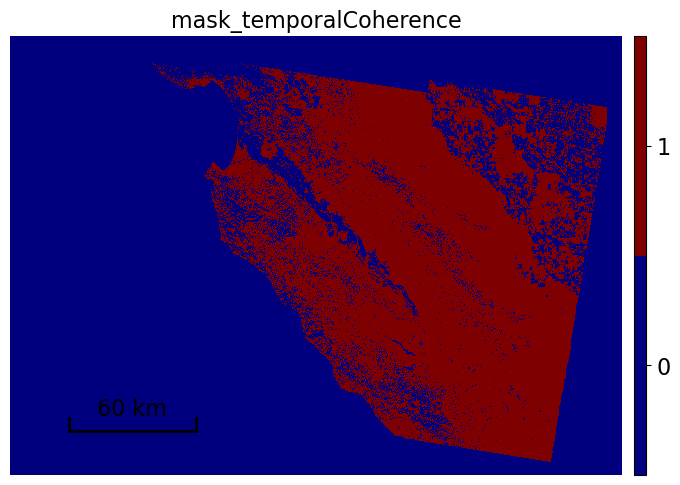

In [6]:
if not os.path.exists(msk_file):

    if (os.path.basename(msk_file) == 'maskSpatialCoh.h5'):

        if not os.path.exists('avgSpatialCoh.h5'):
            raise FileNotFoundError("cannot find avgSpatialCoh.h5")
        
        view.main(f'avgSpatialCoh.h5 --noaxis --noverbose'.split()) # average spatial coherence

        iargs = [f'avgSpatialCoh.h5', '-m', minCoherence_parm, '-o', maskFile]
        generate_mask.main(iargs)

    elif (os.path.basename(msk_file) == 'mask_temporalCoherence.h5'):

        if not os.path.exists('inputs/temporalCoherence.h5'):
            raise FileNotFoundError("cannot find inputs/temporalCoherence.h5")
        
        view.main(f'inputs/temporalCoherence.h5 --noaxis --noverbose'.split()) # average spatial coherence

        iargs = [f'inputs/temporalCoherence.h5', '-m', minTempCoherence_parm, '-o', maskFile]
        generate_mask.main(iargs)

    else:
        raise FileNotFoundError(f"The maskfile {msk_file} not found.")

# view mask
view.main([msk_file, 'mask', '--noaxis'])

mask_lyr, _ = readfile.read(msk_file)    # reading maskfile

In [7]:
# reading area of DISP-S1
disp_S1_metadata = readfile.read_attribute(ifgs_file)

assert 'UTM_ZONE' in disp_S1_metadata.keys()  # make sure data in UTM zone

DISP_region = list(ut.four_corners(disp_S1_metadata))

geo_S, geo_W = ut0.utm2latlon(disp_S1_metadata, DISP_region[2], DISP_region[0])
geo_N, geo_E = ut0.utm2latlon(disp_S1_metadata, DISP_region[3], DISP_region[1])
DISP_region_geo = (geo_S, geo_N, geo_W, geo_E)

print(f'region of DISP-S1 (UTM): {DISP_region}, Zone: {disp_S1_metadata["UTM_ZONE"]}')
print('region of DISP-S1 (lat/lon): ', DISP_region_geo)

wavelength = float(disp_S1_metadata['WAVELENGTH'])
global phase2range
phase2range = wavelength/(4*np.pi)

region of DISP-S1 (UTM): [3907560.0, 4114500.0, 499800.0, 788340.0], Zone: 10N
region of DISP-S1 (lat/lon):  (35.31124642652954, 37.13246004091276, -123.00220010448189, -119.75418835291748)


In [8]:
# # Instead of bringing all data into memory, we will read files when needed.    
def read_ifgram_hdf(hdf_file, keyword, channel=None, coh_thr=None):
    valid_keywords = ['coherence', 'date', 'unwrapPhase']
    if keyword not in valid_keywords:
        raise KeyError(f"Keyword '{keyword}' not found in the {hdf_file} file. Valid keywords are {valid_keywords}")

    with h5py.File(hdf_file, 'r') as f:
        if keyword == 'date':
            return f[keyword][()]

        data = f[keyword]
        num_ifgs, *_ = data.shape

        if channel is not None and channel >= num_ifgs:
            raise ValueError(f"Input channel {channel} exceeds the number of possible ifgrams ({num_ifgs})")

        output = data[channel] if channel is not None else data[:]

        if keyword == 'unwrapPhase' and coh_thr is not None:
            coh_data = f['coherence']
            coh = coh_data[channel] if channel is not None else coh_data[:]
            output[coh < float(coh_thr)] = np.nan

        return output
    
def slice_mask(arr, mask=None, cor_ref=None):
    """
    Mask and process a slice of an array.
    
    Args:
    arr (np.ndarray): Input array to be masked.
    mask (list of np.ndarray, optional): List of mask arrays.
    cor_ref (np.ndarray, optional): Reference array to be subtracted.
    
    Returns:
    np.ndarray: Processed array.
    """
    # Convert to numpy array if not already
    arr = np.asarray(arr)
    
    # Replace zeros with NaN
    arr[arr == 0] = np.nan
    
    # Apply masks if provided
    if mask is not None:
        arr[np.logical_or.reduce([m == 0 for m in mask])] = np.nan
    
    # Subtract reference if provided
    if cor_ref is not None:
        arr -= cor_ref
    
    return arr

Load the date of DISP-S1s into Python:

In [9]:
ifgs_date = read_ifgram_hdf(ifgs_file, 'date')  # all ifgs date in ifgramStack.h5
ifgs_date_dt = [ [dt.strptime(ref_date.decode(), '%Y%m%d'), dt.strptime(sec_date.decode(), '%Y%m%d')] for ref_date, sec_date in ifgs_date]  # ifgs_date in datetime format
ifgs_date_dt = np.array(ifgs_date_dt)   # all valuable ifgs dates will be kept with dates_index

Remove DISP-S1s with time interval larger than 12 days:

In [10]:
dates_index = []    # dates index only to be used for CalVal
dates_filter_flag = True   # if dates are filtered based on time interval of sequential pairs

# DISP-S1 has a single reference date for time-series
assert len(set(ifgs_date[:,0])) == 1     # The DISP-S1 should have a single reference date.

if dates_filter_flag:
    # filtered by time interval threshold
    for ii, (ref_date, sec_date) in enumerate(ifgs_date_dt):

        if (ii==0):
            delta_day = (sec_date-ref_date).days
            prev_sec_date = sec_date
        else:
            delta_day = (sec_date-prev_sec_date).days
            prev_sec_date = sec_date

        if delta_day <= time_interval_thr:
            dates_index.append(ii)
else:
    dates_index = list(range(len(ifgs_date_dt)))        # all data used for validation

# printing which pair will be used for validation
print(f'Number of pairs to be used for validation: {len(dates_index)}')
print('Pairs to be used for validation')
for ii in dates_index:
    print(ifgs_date_dt[ii,0].strftime('%Y%m%d'), ifgs_date_dt[ii,1].strftime('%Y%m%d'))

Number of pairs to be used for validation: 262
Pairs to be used for validation
20160705 20160810
20160705 20160822
20160705 20160903
20160705 20160915
20160705 20160927
20160705 20161009
20160705 20161021
20160705 20161102
20160705 20161114
20160705 20161126
20160705 20161208
20160705 20161220
20160705 20170101
20160705 20170113
20160705 20170119
20160705 20170125
20160705 20170206
20160705 20170218
20160705 20170302
20160705 20170407
20160705 20170419
20160705 20170501
20160705 20170513
20160705 20170618
20160705 20170630
20160705 20170712
20160705 20170724
20160705 20170805
20160705 20170817
20160705 20171016
20160705 20171028
20160705 20171109
20160705 20171121
20160705 20171203
20160705 20171215
20160705 20171227
20160705 20180108
20160705 20180120
20160705 20180201
20160705 20180213
20160705 20180225
20160705 20180402
20160705 20180414
20160705 20180426
20160705 20180508
20160705 20180520
20160705 20180601
20160705 20180613
20160705 20180625
20160705 20180707
20160705 20180719
201

- `disp_S1_metadata`: metadata of DISP-S1 stacks, including incident angle, longitude and latitude step width, etc
- `dates_index`: indices used for further CalVal excluding pairs not meeting temporal baseline thresholds or minimum GNSS observations
- `ifgs_date_dt`: list of DISP-S1 dates in datetime format used for CalVal along with `dates_index`

### Applying nonlinear-displacement mask

mask_nonDispScore.h5 already exists.


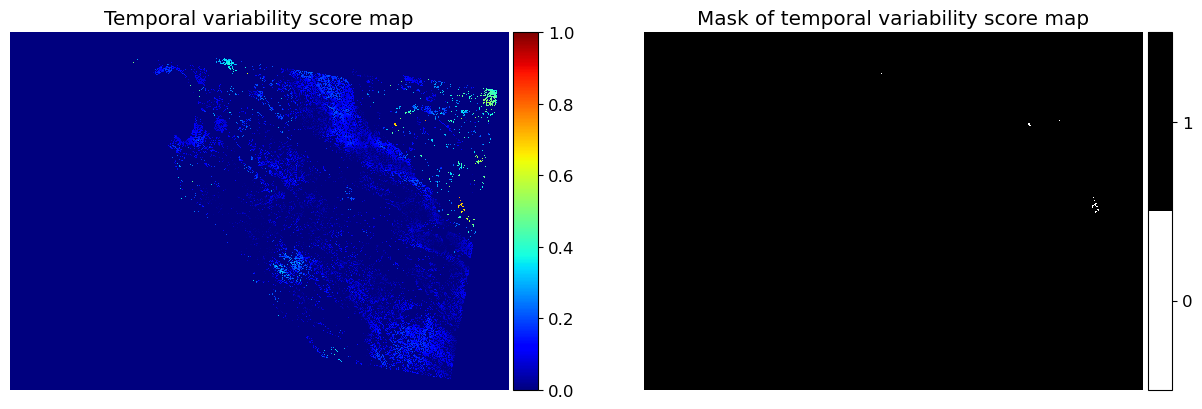

In [11]:
score_map_file = 'nonDispScore.h5'
score_map_file = os.path.join(mintpy_dir, score_map_file)

if apply_nonlinear_mask:

    variability_scores = readfile.read(score_map_file)[0]
    mask_var_score = variability_scores < thr_var_score     # selecting pixels with small temporal variability score

    mask_score_map_file = 'mask_nonDispScore.h5'
    if os.path.exists(mask_score_map_file):
        print(f'{mask_score_map_file} already exists.')
    else:
        print(f'Creating {mask_score_map_file} mask file')
        iargs = [f'{score_map_file}', '-M', str(thr_var_score), '-o', mask_score_map_file]
        generate_mask.main(iargs)       

    mask_var_score, _ = readfile.read(mask_score_map_file)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

    im1 = ax1.imshow(variability_scores, cmap='jet', vmin=0, vmax=1, interpolation='none')
    ax1.axis('off')
    ax1.set_title('Temporal variability score map')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)

    cmap_bw = matplotlib.colors.ListedColormap(['white', 'black'])
    im2 = ax2.imshow(mask_var_score, cmap_bw, interpolation='none')
    ax2.axis('off')
    ax2.set_title('Mask of temporal variability score map')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_ticks([0.25, 0.75])    # Set tick locations to the center of each color range
    cbar.set_ticklabels(['0', '1'])     # Set tick labels

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cax.axis('off')

<a id='transient_gnss_los'></a>
# Make GNSS LOS Measurements

<a id='transient_co_gnss'></a>
## Find Collocated GNSS Stations
The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

Get space and time range for searching GNSS station: 

In [12]:
# get analysis metadata from DISP-S1 stack
start_date = ifgs_date_dt[dates_index[0],0].strftime('%Y%m%d')
end_date = ifgs_date_dt[dates_index[-1],1].strftime('%Y%m%d')

start_date_gnss = ifgs_date_dt[dates_index[0],0]
end_date_gnss = ifgs_date_dt[dates_index[-1],1]

geom_file = os.path.join(mintpy_dir, 'geometryGeo.h5')
inc_angle = readfile.read(geom_file, datasetName='incidenceAngle')[0]
inc_angle = np.nanmean(inc_angle)
az_angle = readfile.read(geom_file, datasetName='azimuthAngle')[0]
az_angle = np.nanmean(az_angle)

# search for collocated GNSS stations
site_names, site_lats_wgs84, site_lons_wgs84 = gnss.search_gnss(SNWE=DISP_region_geo,
                                                                start_date=start_date,
                                                                end_date=end_date,
                                                                source=gnss_source)
# post-query: convert lat/lon to UTM for plotting
site_north, site_east = ut0.latlon2utm(disp_S1_metadata, site_lats_wgs84, site_lons_wgs84)

site_names = [str(stn) for stn in site_names]
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

load 22009 GNSS sites with fields: site lat lon start_date end_date num_solution
keep sites within SNWE of (35.31124642652954, 37.13246004091276, -123.00220010448189, -119.75418835291748): [151]
keep sites with end_date >= 20160705: [143]
keep sites with start_date <= 20230319: [141]
keep sites with # of solutions >= 50: [141]
['ALTH' 'CAAT' 'CACO' 'CAFP' 'CAGR' 'CAHF' 'CAKC' 'CALB' 'CAM5' 'CAMD'
 'CAMT' 'CAND' 'CARH' 'CASU' 'CASZ' 'CHOR' 'CHOW' 'CRBT' 'DREW' 'FLNT'
 'GR8R' 'GRN5' 'HOGS' 'HUNT' 'JLN5' 'LAND' 'LEMA' 'LOWS' 'MASW' 'MEE1'
 'MEE2' 'MIDA' 'MNMC' 'MON6' 'MULN' 'P067' 'P171' 'P172' 'P173' 'P174'
 'P175' 'P180' 'P209' 'P210' 'P211' 'P212' 'P214' 'P215' 'P216' 'P217'
 'P231' 'P232' 'P233' 'P234' 'P235' 'P237' 'P239' 'P240' 'P242' 'P243'
 'P244' 'P247' 'P249' 'P250' 'P278' 'P279' 'P280' 'P281' 'P282' 'P283'
 'P284' 'P285' 'P286' 'P287' 'P288' 'P289' 'P290' 'P291' 'P292' 'P293'
 'P294' 'P295' 'P296' 'P297' 'P298' 'P299' 'P300' 'P301' 'P302' 'P303'
 'P304' 'P307' 'P525' 'P526' 'P5

<a id='transient_gnss_los2'></a>
## Make GNSS LOS Measurements

In this step, the 3-D GNSS observations are projected into LOS direction. The DISP-S1 measurements are averaged 3 by 3 near the station positions.

In [13]:
# get daily position solutions for GNSS stations
use_stn = []  #stations to keep
bad_stn = []  #stations to toss
use_north = [] 
use_east = []
# track latlon coordinates for UTM grids
use_lats_keepwgs84 = [] 
use_lons_keepwgs84 = []

for counter, stn in enumerate(site_names):
    gps_obj = GNSS(site = stn,
                   data_dir = os.path.join(mintpy_dir,f'GNSS-{gnss_source}'))
    gps_obj.open(print_msg=False)
    
    # count number of dates in time range
    dates = gps_obj.dates
    range_days = (end_date_gnss - start_date_gnss).days
    gnss_count = np.histogram(dates, bins=[start_date_gnss, end_date_gnss])
    gnss_count = int(gnss_count[0])
    
    # for this quick screening check of data quality, we use the constant incidence and azimuth angles 
    # get standard deviation of residuals to linear fit
    disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, az_angle)
    disp_detrended = signal.detrend(disp_los)
    stn_stdv = np.std(disp_detrended)
   
    # select GNSS stations based on data completeness and scatter of residuals
    disp_detrended = signal.detrend(disp_los)
    if range_days * gps_completeness_threshold <= gnss_count:
        if (stn_stdv > gps_residual_stdev_threshold):
            bad_stn.append(stn)
        else:
            use_stn.append(stn)
            use_north.append(site_north[counter])
            use_east.append(site_east[counter])
            use_lats_keepwgs84.append(site_lats_wgs84[counter])
            use_lons_keepwgs84.append(site_lons_wgs84[counter])
    else:
        bad_stn.append(stn)

site_names = use_stn
site_north = use_north
site_east = use_east
site_lats_wgs84 = use_lats_keepwgs84
site_lons_wgs84 = use_lons_keepwgs84

# [optional] manually remove additional stations
gnss_to_remove=[]

for i, gnss_site in enumerate(gnss_to_remove):
    if gnss_site in site_names:
        site_names.remove(gnss_site)
    if gnss_site not in bad_stn:
        bad_stn.append(gnss_site)

print("\nFinal list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_stn)))
print(bad_stn)


Final list of 111 stations used in analysis:
['ALTH', 'CACO', 'CAFP', 'CAKC', 'CALB', 'CAMD', 'CAMT', 'CAND', 'CARH', 'CHOW', 'CRBT', 'HOGS', 'HUNT', 'JLN5', 'LAND', 'LEMA', 'LOWS', 'MASW', 'MIDA', 'MNMC', 'MULN', 'P067', 'P171', 'P172', 'P173', 'P174', 'P175', 'P180', 'P209', 'P210', 'P211', 'P212', 'P214', 'P215', 'P216', 'P217', 'P231', 'P232', 'P233', 'P234', 'P235', 'P237', 'P239', 'P242', 'P243', 'P244', 'P247', 'P249', 'P250', 'P278', 'P279', 'P280', 'P281', 'P282', 'P283', 'P284', 'P285', 'P286', 'P287', 'P288', 'P289', 'P290', 'P291', 'P293', 'P294', 'P295', 'P296', 'P298', 'P300', 'P302', 'P303', 'P304', 'P307', 'P525', 'P526', 'P527', 'P528', 'P529', 'P530', 'P531', 'P532', 'P533', 'P534', 'P537', 'P538', 'P539', 'P540', 'P541', 'P542', 'P552', 'P576', 'P578', 'P602', 'P787', 'P788', 'P789', 'P790', 'PEA1', 'PEA2', 'PKDB', 'POMM', 'QCY2', 'RBRU', 'RJAB', 'RNCH', 'SAOB', 'SHN5', 'SIMM', 'TBLP', 'TRAN', 'USLO']
List of 30 stations removed from analysis
['CAAT', 'CAGR', 'CAHF'

Get daily position solutions for GNSS stations:

In [14]:
def process_station(args, ifgs_date_dt, mintpy_dir, gnss_source, geom_file, disp_S1_metadata, site_north, site_east, site_lats_wgs84, 
                    site_lons_wgs84, ifgs_file, msk_file, mask_var_score_file=None):
    counter, stn, i = args  # counter is for counting gnss stations / i is index for dates_index

    gps_obj = GNSS(site=stn, data_dir=os.path.join(mintpy_dir, f'GNSS-{gnss_source}'))
    gps_obj.open(print_msg=False)
    
    gps_obj.read_displacement(print_msg=False)
    dates = gps_obj.dates
    
    start_date = ifgs_date_dt[i, 0]     # start date of ith DISP-S1
    end_date = ifgs_date_dt[i, 1]       # end date of ith DISP-S1
    
    range_days = (end_date - start_date).days
    gnss_count = np.histogram(dates, bins=[start_date, end_date])
    gnss_count = int(gnss_count[0])
    
    if range_days == gnss_count - 1:
        _, disp_gnss_time_series, disp_gnss_time_series_std, site_latlon = gps_obj.get_los_displacement(
            str(geom_file),
            start_date=start_date.strftime('%Y%m%d'),
            end_date=end_date.strftime('%Y%m%d'))[:4]
        
        y_value, x_value = ut.coordinate(disp_S1_metadata).geo2radar(site_latlon[0], site_latlon[1])[:2]
        
        stn_north = float(site_north[counter])  # location of gnss stations in UTM coordinates
        stn_east = float(site_east[counter])
        site_NE = [stn_north, stn_east]
        site_latlon = [float(site_lats_wgs84[counter]), float(site_lons_wgs84[counter])]    # location of gnss stations in geographic coordinates
        
        ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=i, coh_thr=minCoherence_parm) * phase2range * 1000  # reading only a corresponding pair for validation
        mask_lyr, _ = readfile.read(msk_file)    # reading maskfile
        if mask_var_score_file is not None:
            mask_var_score, _ = readfile.read(mask_var_score_file)            # to avoid memory error, mask is read from hdf
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score])     # applying masks to a pair
        else:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr])
            
        disp_dat = ifgs_slice[y_value-pixel_radius:y_value+pixel_radius, 
                                x_value-pixel_radius:x_value+pixel_radius]
        
        if np.isfinite(disp_dat).sum() == 0:
            return None
        
        disp_dat = np.nanmean(disp_dat)
        
        disp_gnss_time_series = disp_gnss_time_series * 1000
        disp_gnss_time_series_std = disp_gnss_time_series_std * 1000
        disp_gnss = disp_gnss_time_series[-1] - disp_gnss_time_series[0]
        
        return {
            'gnss_time_series': (i, stn, disp_gnss_time_series),
            'gnss_time_series_std': (i, stn, disp_gnss_time_series_std),
            'displacement': (i, stn, site_NE + site_latlon + [disp_gnss, disp_dat])
        }
    else:
        return {'bad_stn': (i, stn)}

In [15]:
# applying multi-processing to creating dict to compare DISP-S1 and gnss measurements
displacement = {}
gnss_time_series = {}
gnss_time_series_std = {}
bad_stn = {}  #stations to toss

global pixel_radius
pixel_radius = 1

# Create a list of all combinations
all_combinations = list(product(enumerate(site_names), dates_index))
all_args = [(counter, stn, i) for (counter, stn), i in all_combinations]

# Partial function with fixed arguments
process_func = partial(process_station,  
                        ifgs_date_dt=ifgs_date_dt, 
                        mintpy_dir=mintpy_dir, 
                        gnss_source=gnss_source, 
                        geom_file=geom_file, 
                        disp_S1_metadata=disp_S1_metadata, 
                        site_north=site_north, 
                        site_east=site_east, 
                        site_lats_wgs84=site_lats_wgs84, 
                        site_lons_wgs84=site_lons_wgs84, 
                        ifgs_file=ifgs_file, 
                        msk_file=msk_file, 
                        mask_var_score_file=mask_score_map_file)

# Use multiprocessing to parallelize the execution
with multiprocessing.Pool(processes=ncpus) as pool:
    results = list(tqdm(pool.imap(process_func, all_args), total=len(all_args), desc="Processing stations"))

# Process results
for result in results:
    if result is not None:
        if 'gnss_time_series' in result:
            i, stn, value = result['gnss_time_series']
            gnss_time_series[(i, stn)] = value
        if 'gnss_time_series_std' in result:
            i, stn, value = result['gnss_time_series_std']
            gnss_time_series_std[(i, stn)] = value
        if 'displacement' in result:
            i, stn, value = result['displacement']
            displacement[(i, stn)] = value
        if 'bad_stn' in result:
            i, stn = result['bad_stn']
            if i in bad_stn:
                bad_stn[i].append(stn)
            else:
                bad_stn[i] = [stn]

Processing stations: 100%|██████████| 29082/29082 [08:30<00:00, 56.96it/s] 


Do some data structure transformation:

In [16]:
gnss_time_series = dict(sorted(gnss_time_series.items()))
gnss_time_series_std = dict(sorted(gnss_time_series_std.items()))
displacement = dict(sorted(displacement.items()))
bad_stn = dict(sorted(bad_stn.items()))

In [17]:
# In cases cumulative time-series was used, the interval of cumulative time-series is in increments of 6,12,18,
# Such that gnss_time_series has differents length for each pairs, and cannot be converted to pandas table.
# Capture such cases.
try:
    gnss_time_series = pd.DataFrame.from_dict(gnss_time_series)
    gnss_time_series_std = pd.DataFrame.from_dict(gnss_time_series_std)
except ValueError:
    pass

In [18]:
displacement = pd.DataFrame.from_dict(displacement,orient='index',
                                      columns=['north','east','lat','lon','gnss_disp','disp_s1'])
displacement.index = pd.MultiIndex.from_tuples(displacement.index,names=['ifg index','station'])

If there are less than 3 GNSS stations, don't conduct comparison:

In [19]:
drop_index = []
dates_index_gnss = []

for i in displacement.index.get_level_values(0).unique():
    if len(displacement.loc[i]) < 3:
        drop_index.append(i)
    else:
        dates_index_gnss.append(i)

displacement=displacement.drop(drop_index)

All data needed for approach 1:

In [20]:
display(displacement)

north           east        lat         lon  \
ifg index station                                                       
1         ALTH     4.085161e+06  707647.651251  36.889599 -120.669800   
          CAFP     4.034881e+06  759817.039237  36.424000 -120.102005   
          CAMT     4.048885e+06  605550.537746  36.579601 -121.820206   
          CAND     3.980271e+06  731496.249938  35.939400 -120.433701   
          CARH     3.974619e+06  731906.465475  35.888401 -120.430801   
...                         ...            ...        ...         ...   
230       P237     4.055817e+06  644221.947446  36.637001 -121.386795   
          P279     3.962456e+06  675138.379978  35.790600 -121.061996   
          P296     3.992899e+06  737483.103038  36.051701 -120.363602   
          P533     3.959175e+06  737723.555089  35.747898 -120.371002   
          P787     4.073570e+06  626609.657273  36.799500 -121.580795   

                    gnss_disp     disp_s1  
ifg index station                          
1         ALTH      -5.019348    9.740735  
          CAFP     -33.239090   12.782154  
          CAMT      -1.264893   25.812775  
          CAND      -0.235168  -28.370529  
          CARH      -9.376831  -36.843979  
...                       ...         ...  
230       P237    -150.147400  123.779999  
          P279    -138.021667   42.986664  
          P296     -66.245148  -58.041885  
          P533    -111.218521  -18.205744  
          P787    -152.744629  146.294312  

[4146 rows x 6 columns]

**NOTE:** 
- A more general criterion is needed for GNSS station selection. Here the stations with uninterrupted data are selected while, in Secular Requirement Validation, stations are selected by data completeness and standard variation.

<a id='transient_gnss_DISP-S1'></a>
## Make GNSS and DISP-S1 Relative Displacements

Here we randomly select one reference site and make both the GNSS and DISP-S1 measurements relative to that reference to remove a constant offset.

In [21]:
ref_disp_s1 = {}

# reference GNSS stations to GNSS reference site
for i in displacement.index.get_level_values(0).unique():
    gps_ref_site_name = random.choice(displacement.loc[i].index.unique())
    displacement.loc[i,'gnss_disp'] = displacement.loc[i,'gnss_disp'].values - displacement.loc[(i,gps_ref_site_name),'gnss_disp']
    displacement.loc[i,'disp_s1'] = displacement.loc[i,'disp_s1'].values - displacement.loc[(i,gps_ref_site_name),'disp_s1']
    # post-query: convert lat/lon to UTM
    ref_lon = displacement.loc[(i,gps_ref_site_name),'lon']
    ref_lat = displacement.loc[(i,gps_ref_site_name),'lat']
    ref_y_value, ref_x_value = ut.coordinate(disp_S1_metadata).geo2radar(ref_lat, ref_lon)[:2]    # location of reference GNSS station on the image

    ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=i) * phase2range*1000    # unit in mm   
    if apply_nonlinear_mask:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score])
    else:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr])

    _ = ifgs_slice[ref_y_value-pixel_radius:ref_y_value+1+pixel_radius, 
                                ref_x_value-pixel_radius:ref_x_value+1+pixel_radius]
    ref_disp_s1[i] = [float(np.nanmean(_))]

Plot GNSS stations on DISP-S1 displacement fields

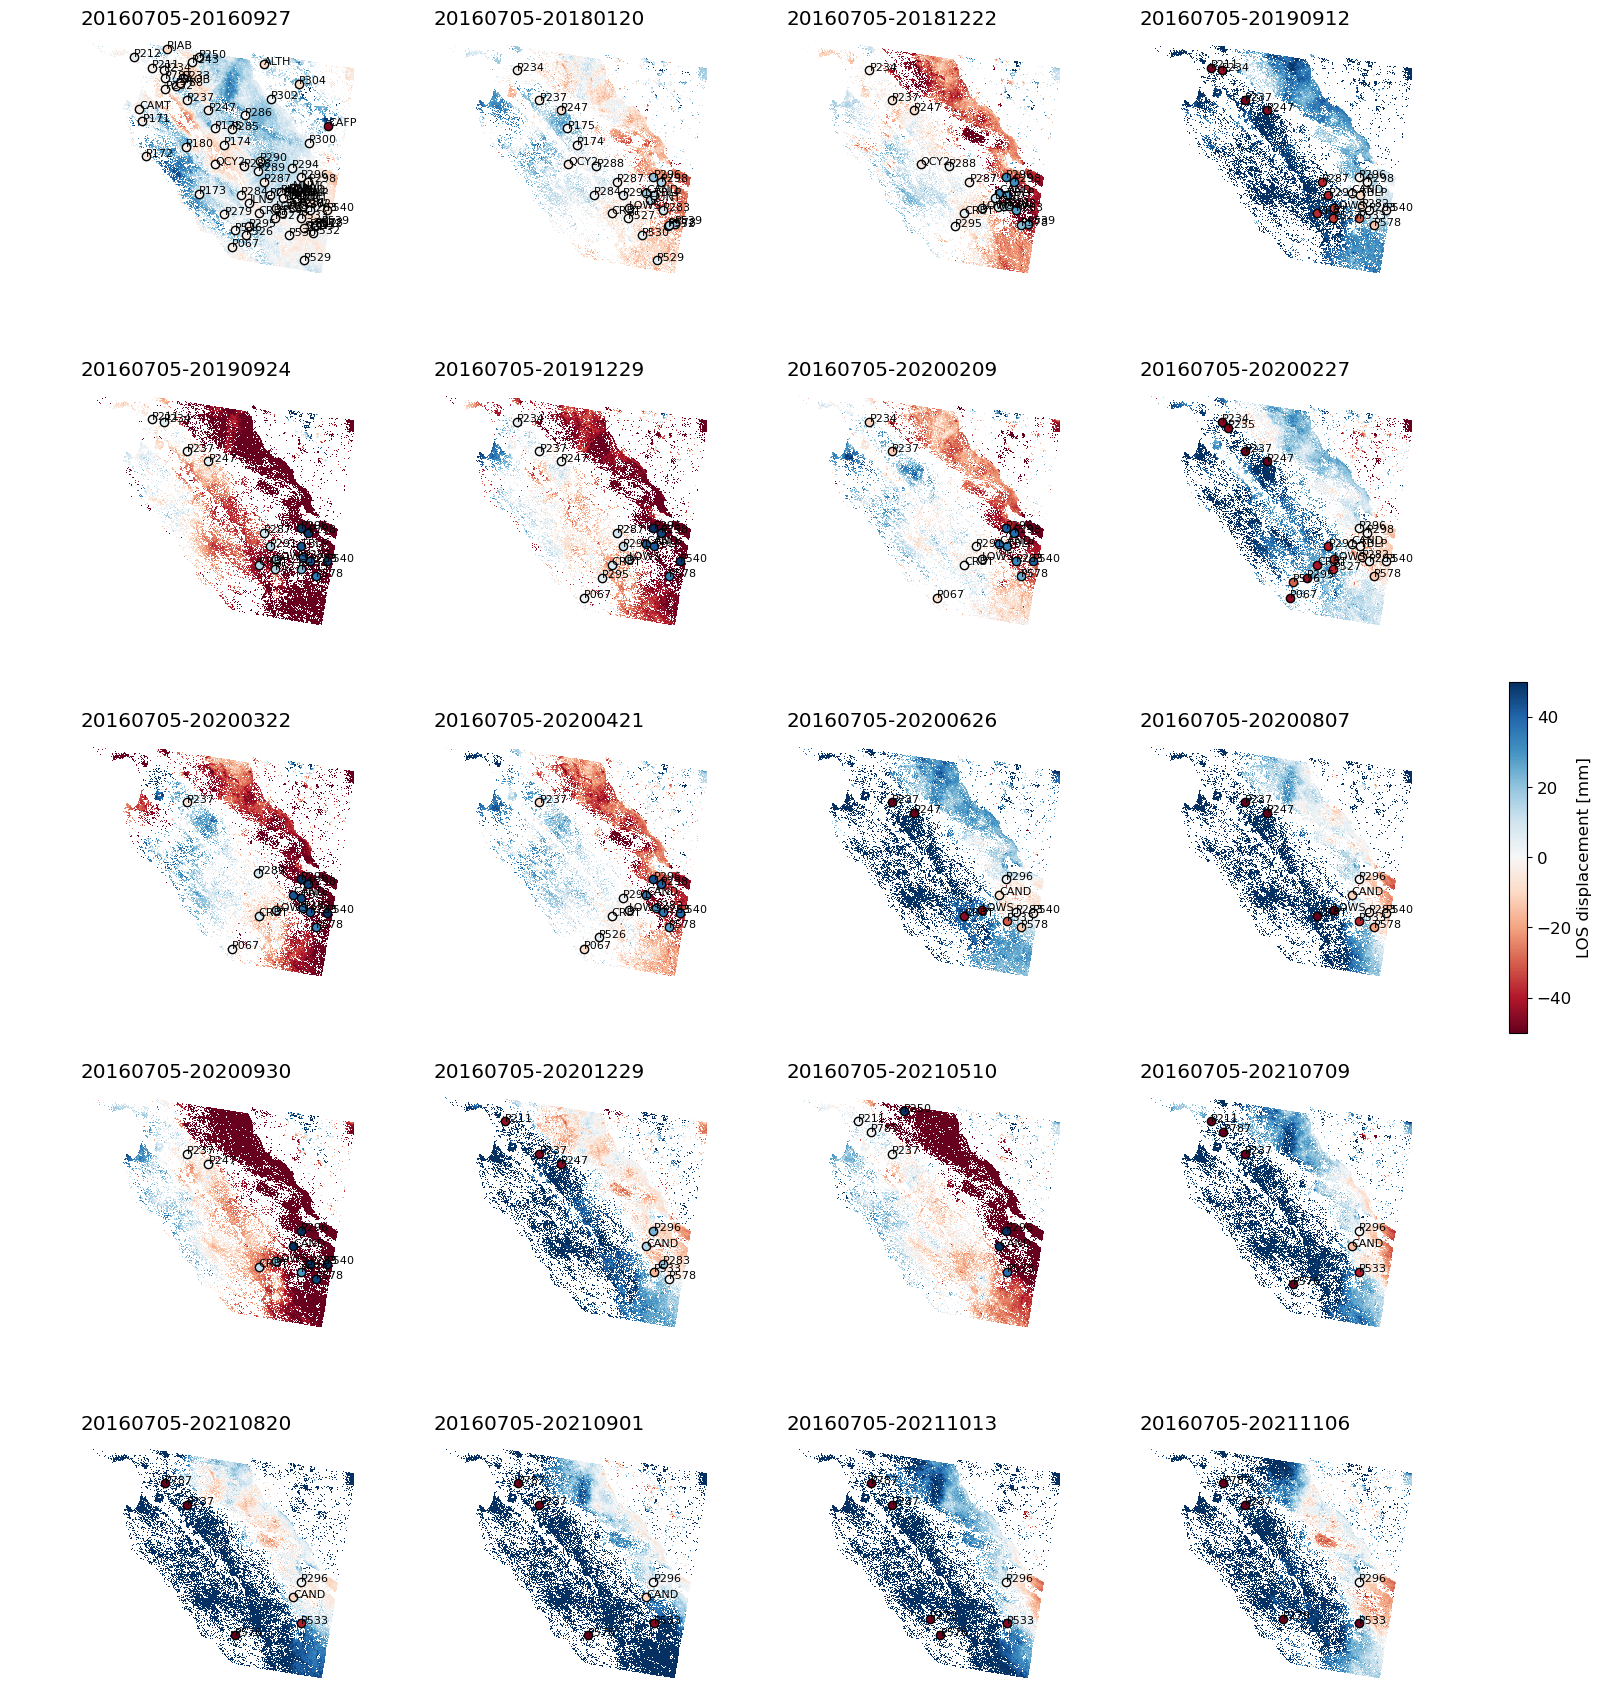

In [22]:
# Plotting only sampled pairs due to a large volume of DISP-S1
cmap = copy.copy(plt.get_cmap('RdBu'))

n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

col_figs = 4    # number of colums in figures
num_pairs_to_plot = 20

if num_pairs_to_plot > n_pairs:
    num_pairs_to_plot = n_pairs

num_figs = int(np.ceil(num_pairs_to_plot/col_figs)) * col_figs

sampled_index = sorted(random.sample(list(displacement.index.get_level_values(0).unique()),num_pairs_to_plot))

fig, ax = plt.subplots(int(np.ceil(num_pairs_to_plot/col_figs)), col_figs, figsize=[18, 18])
axs = ax.ravel()

for counter in range(num_figs):
    if (counter<n_pairs):
        _ind = sampled_index[counter]
        ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=_ind, coh_thr=minCoherence_parm) * phase2range*1000    # unit in mm   
        if apply_nonlinear_mask:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score], cor_ref=ref_disp_s1[_ind])
        else:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr], cor_ref=ref_disp_s1[_ind])

        im = axs[counter].imshow(ifgs_slice, cmap=cmap,vmin=vmin,vmax=vmax, interpolation='nearest', extent=(DISP_region[2],DISP_region[3],DISP_region[0],DISP_region[1]))
        axs[counter].axis('off')
        axs[counter].set_title(ifgs_date_dt[_ind,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[_ind,1].strftime('%Y%m%d'), pad=-14)

        for stn in displacement.loc[_ind].index:
            _east, _north = displacement.loc[(_ind,stn),'east'],displacement.loc[(_ind,stn),'north']

            color = cmap((displacement.loc[(_ind,stn),'gnss_disp']-vmin)/(vmax-vmin))
            axs[counter].scatter(_east,_north,s=6**2,color=color,edgecolors='k')
            axs[counter].annotate(stn,(_east, _north),color='black', fontsize=8)
    else:
        axs[counter].axis('off')

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

cbar = fig.colorbar(im, ax=axs.tolist(), shrink=0.2)
cbar.set_label('LOS displacement [mm]')

out_fig = f'{output_dir}/Transient_DISP-S1_vs_gnss_randomSelected_site{site}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

In [23]:
separate_figure_flag = False     # if plotting separate figures is needed

if separate_figure_flag:
    cmap = copy.copy(plt.get_cmap('RdBu'))

    n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

    for counter in range(n_pairs):
        fig, ax = plt.subplots(figsize=[12,12])
        _ind = displacement.index.get_level_values(0).unique()[counter]
        ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=_ind, coh_thr=minCoherence_parm) * phase2range*1000    # unit in mm   
        if apply_nonlinear_mask:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score], cor_ref=ref_disp_s1[_ind])
        else:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr], cor_ref=ref_disp_s1[_ind])
        im = ax.imshow(ifgs_slice, cmap=cmap,vmin=vmin,vmax=vmax, interpolation='nearest', extent=(DISP_region[2],DISP_region[3],DISP_region[0],DISP_region[1]))
        ax.axis('off')
        ax.set_title(ifgs_date_dt[_ind,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[_ind,1].strftime('%Y%m%d'), pad=-14)
        
        for stn in displacement.loc[_ind].index:
            _east, _north = displacement.loc[(_ind,stn),'east'],displacement.loc[(_ind,stn),'north']

            color = cmap((displacement.loc[(_ind,stn),'gnss_disp']-vmin)/(vmax-vmin))
            ax.scatter(_east,_north,s=6**2,color=color,edgecolors='k')
            ax.annotate(stn,(_east, _north),color='black', fontsize=8)

        cbar = fig.colorbar(im, shrink=0.2)
        cbar.set_label('LOS displacement [mm]')
        out_fig = f"{output_dir}/Transient_DISP-S1_vs_gnss_site{site}_date{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}.png"
        fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
        plt.close()

<a id='transient_validation1'></a>
# NISAR Validation Approach 1: GNSS-DISP-S1 Direct Comparison

<a id='transient_pair1'></a>
## Pair up GNSS stations and make measurement residuals

We first pair up all GNSS stations and compare the relative measurement from both GNSS and DISP-S1. 

In [24]:
disp_s1 = {}
gnss_disp = {}
ddiff_dist = {}
ddiff_disp = {}
abs_ddiff_disp = {}
for i in displacement.index.get_level_values(0).unique():
    displacement_i = displacement.loc[i]
    disp_s1_i = []
    gnss_disp_i = []
    ddiff_dist_i = []
    ddiff_disp_i = []

    gnss_pairs = list(itertools.combinations(displacement_i.index, 2))        # pick two without repeating

    for sta1, sta2 in gnss_pairs:
            disp_s1_i.append(displacement_i.loc[sta1,'disp_s1']-displacement_i.loc[sta2,'disp_s1'])
            gnss_disp_i.append(displacement_i.loc[sta1,'gnss_disp']-displacement_i.loc[sta2,'gnss_disp'])
            ddiff_disp_i.append(gnss_disp_i[-1]-disp_s1_i[-1])

            distance = euclidean_distance(displacement_i.loc[sta1,'east'],displacement_i.loc[sta1,'north'], 
                                          displacement_i.loc[sta2,'east'],displacement_i.loc[sta2,'north'])     # unit: km
            ddiff_dist_i.append(distance)

    disp_s1[i]=np.array(disp_s1_i)
    gnss_disp[i]=np.array(gnss_disp_i)
    ddiff_dist[i]=np.array(ddiff_dist_i)
    ddiff_disp[i]=np.array(ddiff_disp_i)
    abs_ddiff_disp[i]=abs(np.array(ddiff_disp_i))

Plot to compare displacement from GNSS and DISP-S1:

In [25]:
for i in displacement.index.get_level_values(0).unique():
    plt.figure(figsize=(11,7))
    disp_range = (min([*disp_s1[i],*gnss_disp[i]]),max([*disp_s1[i],*gnss_disp[i]]))
    plt.hist(disp_s1[i],bins=100,range=disp_range,color ="green",label='D_DISP-S1')
    plt.hist(gnss_disp[i],bins=100,range=disp_range,color="orange",label='D_GNSS', alpha=0.5)
    plt.legend(loc='upper right')
    date_range = f"{ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}"
    plt.title(f"Displacements \n Date range {date_range} \n Number of station pairs used: {len(disp_s1[i])}")
    plt.xlabel('LOS Displacement (mm)')
    plt.ylabel('Number of Station Pairs')
    plt.savefig(os.path.join(str(output_dir),f'Transient_DISP-S1vsGNSS_hist_site{site}_date{date_range}.png'))
    plt.close()

Plot Displacement Residuals Distribution:

In [26]:
for i in displacement.index.get_level_values(0).unique():
    plt.figure(figsize=(11,7))
    plt.hist(ddiff_disp[i],bins = 100, color="darkblue",linewidth=1,label='D_gnss - D_DISP-S1')
    plt.legend(loc='upper right')
    date_range = f"{ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}"
    plt.title(f"Residuals \n Date range {date_range} \n Number of stations pairs used: {len(ddiff_disp[i])}")
    plt.xlabel('Displacement Residual (mm)')
    plt.ylabel('N Stations')
    plt.savefig(os.path.join(str(output_dir),f'Transient_DISP-S1vsGNSS_hist_residuals_site{site}_date{date_range}.png'))
    plt.close()

Plot Absolute Displacement Residuals As a Function of Distance:

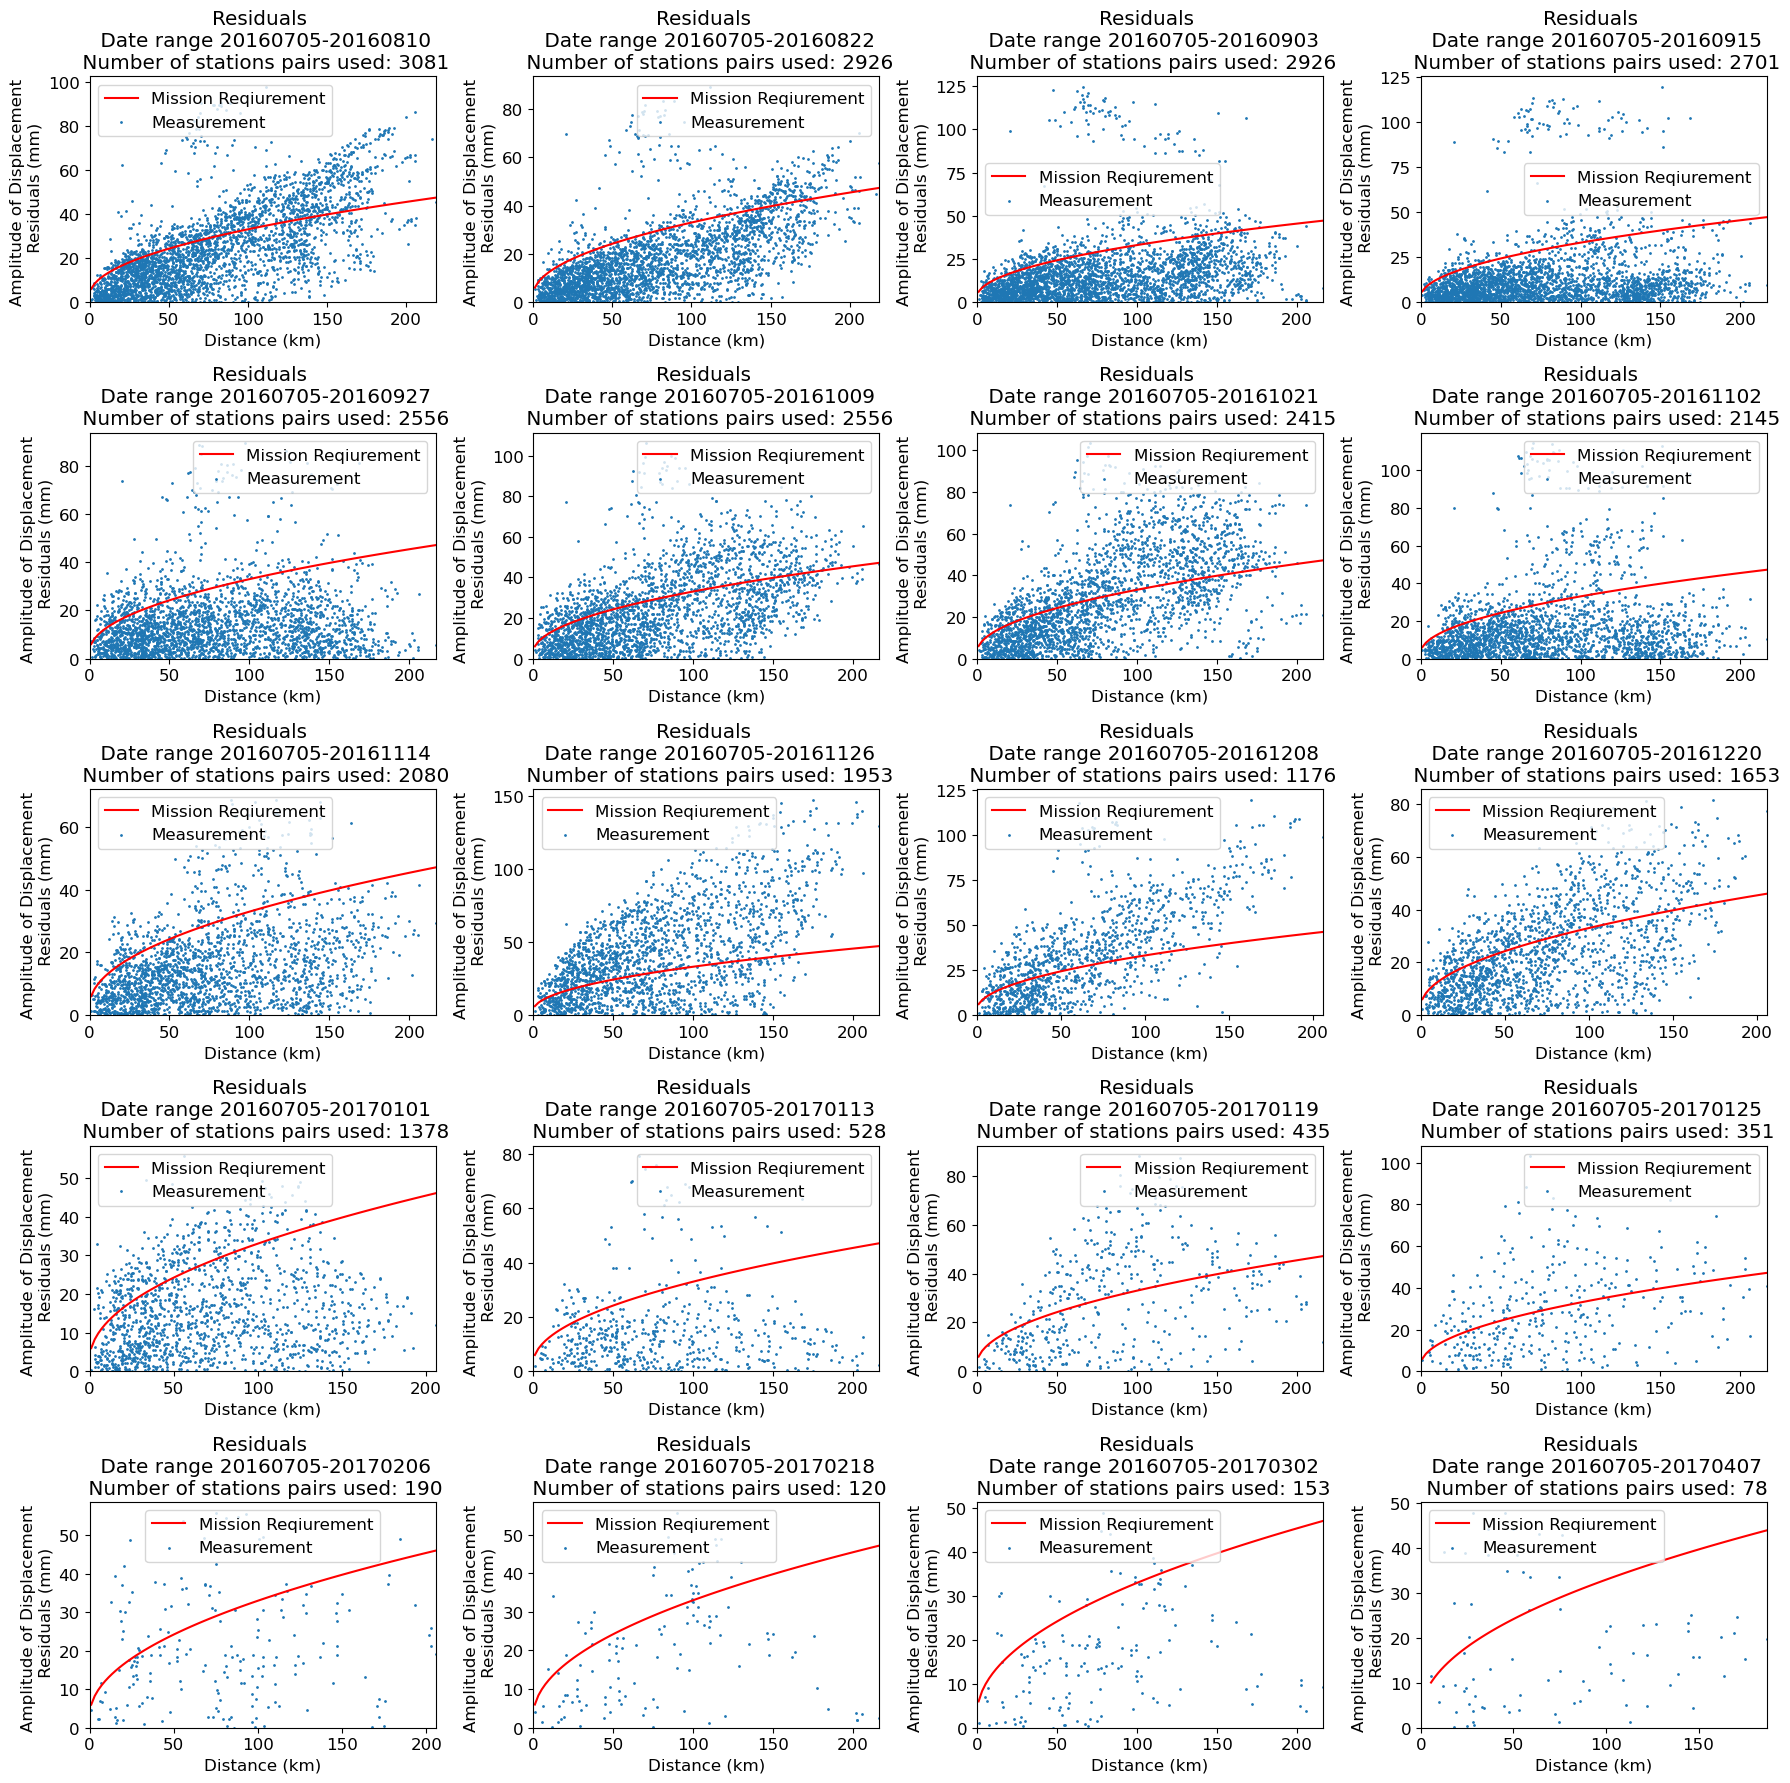

In [27]:
# Plotting only sampled pairs due to a large volume of DISP-S1
n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

col_figs = 4    # number of colums in figures
num_pairs_to_plot = 20

if num_pairs_to_plot > n_pairs:
    num_pairs_to_plot = n_pairs

num_figs = int(np.ceil(num_pairs_to_plot/col_figs)) * col_figs

sampled_index = sorted(random.sample(list(displacement.index.get_level_values(0).unique()),num_pairs_to_plot))

fig, ax = plt.subplots(int(np.ceil(num_pairs_to_plot/col_figs)), col_figs, figsize=[18, 18])
axs = ax.ravel()

for counter in range(num_figs):
    if (counter<n_pairs):
        _ind = displacement.index.get_level_values(0).unique()[counter]
        dist_th = np.linspace(min(ddiff_dist[_ind]),max(ddiff_dist[_ind]),100)
        acpt_error = 3*(1+np.sqrt(dist_th))
        axs[counter].plot(dist_th, acpt_error, 'r', label="Mission Reqiurement")
        axs[counter].scatter(ddiff_dist[_ind],abs_ddiff_disp[_ind],s=1, label="Measurement")
        date_range = f"{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}"
        axs[counter].set_xlabel("Distance (km)")
        axs[counter].set_ylabel("Amplitude of Displacement \n Residuals (mm)")
        axs[counter].set_title(f"Residuals \n Date range {date_range}\n Number of stations pairs used: {len(ddiff_dist[_ind])}")
        axs[counter].set_xlim(0,max(ddiff_dist[_ind]))
        axs[counter].set_ylim(ymin=0)
        axs[counter].legend()

    else:
        axs[counter].axis('off')

fig.tight_layout()

out_fig = f'{output_dir}/VA1_transient_Residuals_DISP-S1_gnss_randomSelected_site{site}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)


In [28]:
separate_figure_flag = False     # if plotting separate figures is needed

if separate_figure_flag:

    cmap = copy.copy(plt.get_cmap('RdBu'))

    n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

    for counter in range(n_pairs):
        fig, ax = plt.subplots(figsize=[12,12])
        _ind = displacement.index.get_level_values(0).unique()[counter]
        dist_th = np.linspace(min(ddiff_dist[_ind]),max(ddiff_dist[_ind]),100)
        acpt_error = 3*(1+np.sqrt(dist_th))
        ax.plot(dist_th, acpt_error, 'r', label="Mission Reqiurement")
        ax.scatter(ddiff_dist[_ind],abs_ddiff_disp[_ind],s=1, label="Measurement")
        date_range = f"{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}"
        ax.set_xlabel("Distance (km)")
        ax.set_ylabel("Amplitude of Displacement Residuals (mm)")
        ax.set_title(f"Residuals \n Date range {date_range}\n Number of stations pairs used: {len(ddiff_dist[_ind])}")
        ax.set_xlim(0,max(ddiff_dist[_ind]))
        ax.set_ylim(ymin=0)
        ax.legend()

        out_fig = f"{output_dir}/VA1_transient_Residuals_DISP-S1_gnss_site{site}_date{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}.png"
        fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
        plt.close()

In [29]:
ddiff_dist_ap1 = list(ddiff_dist.values())
abs_ddiff_disp_ap1 = list(abs_ddiff_disp.values())

We have got all needed data for approach 1:
- `ddiff_dist_ap1`: distance of GNSS pairs,
- `abs_ddiff_disp_ap1`: absolute value of measurement redisuals

<a id='transient_bin1'></a>
## Validate the requirement based on binned measurement residuals

In [30]:
n_ifgs = len(ddiff_dist_ap1)

Bin all measurement residuals to check if they pass the requirements or not:

In [31]:
n_bins = 10
bins = np.linspace(0.1,50.0,num=n_bins+1)

In [32]:
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points pass
for i in range(n_ifgs):
    inds = np.digitize(ddiff_dist_ap1[i],bins)
    for j in range(1,n_bins+1):
        rqmt = 3*(1+np.sqrt(ddiff_dist_ap1[i][inds==j]))# mission requirement for i-th ifgs and j-th bins
        rem = abs_ddiff_disp_ap1[i][inds==j] # relative measurement
        assert len(rqmt) == len(rem)
        n_all[i,j-1] = len(rem)
        n_pass[i,j-1] = np.count_nonzero(rem<rqmt)
    n_all[i,-1] = np.sum(n_all[i,0:-2])
    n_pass[i,-1] = np.sum(n_pass[i,0:-2])

In [33]:
ratio = n_pass/n_all
thresthod = 0.683 
#The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio>thresthod

<a id='transient_result1'></a>
## Result visualization

Convert the result to pandas DataFrame for better visulization:

In [34]:
def to_str(x: bool):
    return 'true ' if x else 'false '

success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in dates_index_gnss:
    index.append(ifgs_date_dt[i,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[i,1].strftime('%Y%m%d'))

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns,index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns,index=index)

Number of data points in each bin:

In [35]:
n_all_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160705-20160810         33          88           99          124   
20160705-20160822         33          86           98          121   
20160705-20160903         34          89           99          120   
20160705-20160915         28          74           88          113   
20160705-20160927         25          63           86           97   
...                      ...         ...          ...          ...   
20160705-20211118          0           0            0            0   
20160705-20211124          0           0            0            0   
20160705-20211130          0           0            0            0   
20160705-20211206          0           0            0            0   
20160705-20211212          0           0            0            0   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160705-20160810          131          133          155          117   
20160705-20160822          128          129          153          113   
20160705-20160903          131          129          153          113   
20160705-20160915          122          113          139          107   
20160705-20160927          114          102          131          100   
...                        ...          ...          ...          ...   
20160705-20211118            1            0            0            0   
20160705-20211124            1            0            1            0   
20160705-20211130            1            0            1            0   
20160705-20211206            1            0            0            0   
20160705-20211212            1            0            1            0   

                   40.02-45.01  45.01-50.00  total  
20160705-20160810          126          105   1006  
20160705-20160822          121          100    982  
20160705-20160903          119           99    987  
20160705-20160915          114           93    898  
20160705-20160927          110           87    828  
...                        ...          ...    ...  
20160705-20211118            0            0      1  
20160705-20211124            0            0      2  
20160705-20211130            0            0      2  
20160705-20211206            0            0      1  
20160705-20211212            0            0      2  

[224 rows x 11 columns]

Number of data points that below the curve:

In [36]:
n_pass_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160705-20160810         31          84           85          110   
20160705-20160822         28          80           94          115   
20160705-20160903         27          80           91          112   
20160705-20160915         22          73           81          100   
20160705-20160927         17          49           60           80   
...                      ...         ...          ...          ...   
20160705-20211118          0           0            0            0   
20160705-20211124          0           0            0            0   
20160705-20211130          0           0            0            0   
20160705-20211206          0           0            0            0   
20160705-20211212          0           0            0            0   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160705-20160810          104          113          131          100   
20160705-20160822          122          118          144          106   
20160705-20160903          119          107          134          103   
20160705-20160915          111          104          131          102   
20160705-20160927           86           80          114           93   
...                        ...          ...          ...          ...   
20160705-20211118            1            0            0            0   
20160705-20211124            1            0            0            0   
20160705-20211130            1            0            0            0   
20160705-20211206            1            0            0            0   
20160705-20211212            0            0            0            0   

                   40.02-45.01  45.01-50.00  total  
20160705-20160810          106           88    864  
20160705-20160822          115           92    922  
20160705-20160903          101           82    874  
20160705-20160915          108           86    832  
20160705-20160927           91           71    670  
...                        ...          ...    ...  
20160705-20211118            0            0      1  
20160705-20211124            0            0      1  
20160705-20211130            0            0      1  
20160705-20211206            0            0      1  
20160705-20211212            0            0      0  

[224 rows x 11 columns]

Percentage of pass:

In [37]:
ratio_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160705-20160810   0.939394    0.954545     0.858586     0.887097   
20160705-20160822   0.848485    0.930233     0.959184     0.950413   
20160705-20160903   0.794118    0.898876     0.919192     0.933333   
20160705-20160915   0.785714    0.986486     0.920455     0.884956   
20160705-20160927   0.680000    0.777778     0.697674     0.824742   
...                      ...         ...          ...          ...   
20160705-20211118        NaN         NaN          NaN          NaN   
20160705-20211124        NaN         NaN          NaN          NaN   
20160705-20211130        NaN         NaN          NaN          NaN   
20160705-20211206        NaN         NaN          NaN          NaN   
20160705-20211212        NaN         NaN          NaN          NaN   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160705-20160810     0.793893     0.849624     0.845161     0.854701   
20160705-20160822     0.953125     0.914729     0.941176     0.938053   
20160705-20160903     0.908397     0.829457     0.875817     0.911504   
20160705-20160915     0.909836     0.920354     0.942446     0.953271   
20160705-20160927     0.754386     0.784314     0.870229     0.930000   
...                        ...          ...          ...          ...   
20160705-20211118     1.000000          NaN          NaN          NaN   
20160705-20211124     1.000000          NaN     0.000000          NaN   
20160705-20211130     1.000000          NaN     0.000000          NaN   
20160705-20211206     1.000000          NaN          NaN          NaN   
20160705-20211212     0.000000          NaN     0.000000          NaN   

                   40.02-45.01  45.01-50.00     total  
20160705-20160810     0.841270     0.838095  0.858847  
20160705-20160822     0.950413     0.920000  0.938900  
20160705-20160903     0.848739     0.828283  0.885512  
20160705-20160915     0.947368     0.924731  0.926503  
20160705-20160927     0.827273     0.816092  0.809179  
...                        ...          ...       ...  
20160705-20211118          NaN          NaN  1.000000  
20160705-20211124          NaN          NaN  0.500000  
20160705-20211130          NaN          NaN  0.500000  
20160705-20211206          NaN          NaN  1.000000  
20160705-20211212          NaN          NaN  0.000000  

[224 rows x 11 columns]

In [38]:
df_ratio = ratio_pd.copy()
df_success = success_or_fail_pd.copy()
s = None

In [39]:
# Assuming your dataframe is called 'df'
s = df_ratio.style.format(precision=3)

# Format the index (date ranges) for better readability
df_ratio.index = df_ratio.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_ratio.index.name = "Date range"
df_ratio.columns = [f"{col} km" if col != "total" else col for col in df_ratio.columns]     # Add units to column headers

df_success.index = df_success.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_success.index.name = "Date range"
df_success.columns = [f"{col} km" if col != "total" else col for col in df_success.columns] 

# Set table styles
s.set_table_styles([
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle; border: 1px solid black;'},
    {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.25em; font-weight: bold; background-color: #f2f2f2; padding: 8px;'},
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle;'},
    {'selector': 'table', 'props': 'border-collapse: collapse;'},
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
    {'selector': f'td:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'th:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': '.index_name', 'props': 'font-weight: bold; font-size: 1.1em; text-align: center;'},
    {'selector': 'tr:first-child', 'props': 'border-top: none;'},
    {'selector': 'tr:last-child', 'props': 'border-bottom: none;'},
    {'selector': 'td:first-child, th:first-child', 'props': 'border-left: none;'},
    {'selector': 'td:last-child, th:last-child', 'props': 'border-right: none;'},
])

s.set_td_classes(df_success)

# Set caption
s.set_caption("Distance")

s.set_properties(**{'text-align': 'center'})

# Display the styled table
s

In [40]:
ratio_pd.to_csv(f'{output_dir}/VA1_transient_DISP-S1-gnss_distance_table_site{site}.csv')

html = s.to_html()

html_filename = f'{output_dir}/VA1_transient_DISP-S1-gnss_distance_table_site{site}.html'
with open(html_filename, "w") as f:
    f.write(html)

<a id='transient_conclusion1'></a>
## Conclusion

In [41]:
percentage = np.count_nonzero(ratio_pd['total']>thresthod)/n_ifgs
print(f"Percentage of DISP-S1s passes the requirement: {percentage}")
if percentage >= 0.70:
    print('The DISP-S1 stack passes the requirement.')
else:
    print('The DISP-S1 stack fails the requirement.')

Percentage of DISP-S1s passes the requirement: 0.13392857142857142
The DISP-S1 stack fails the requirement.


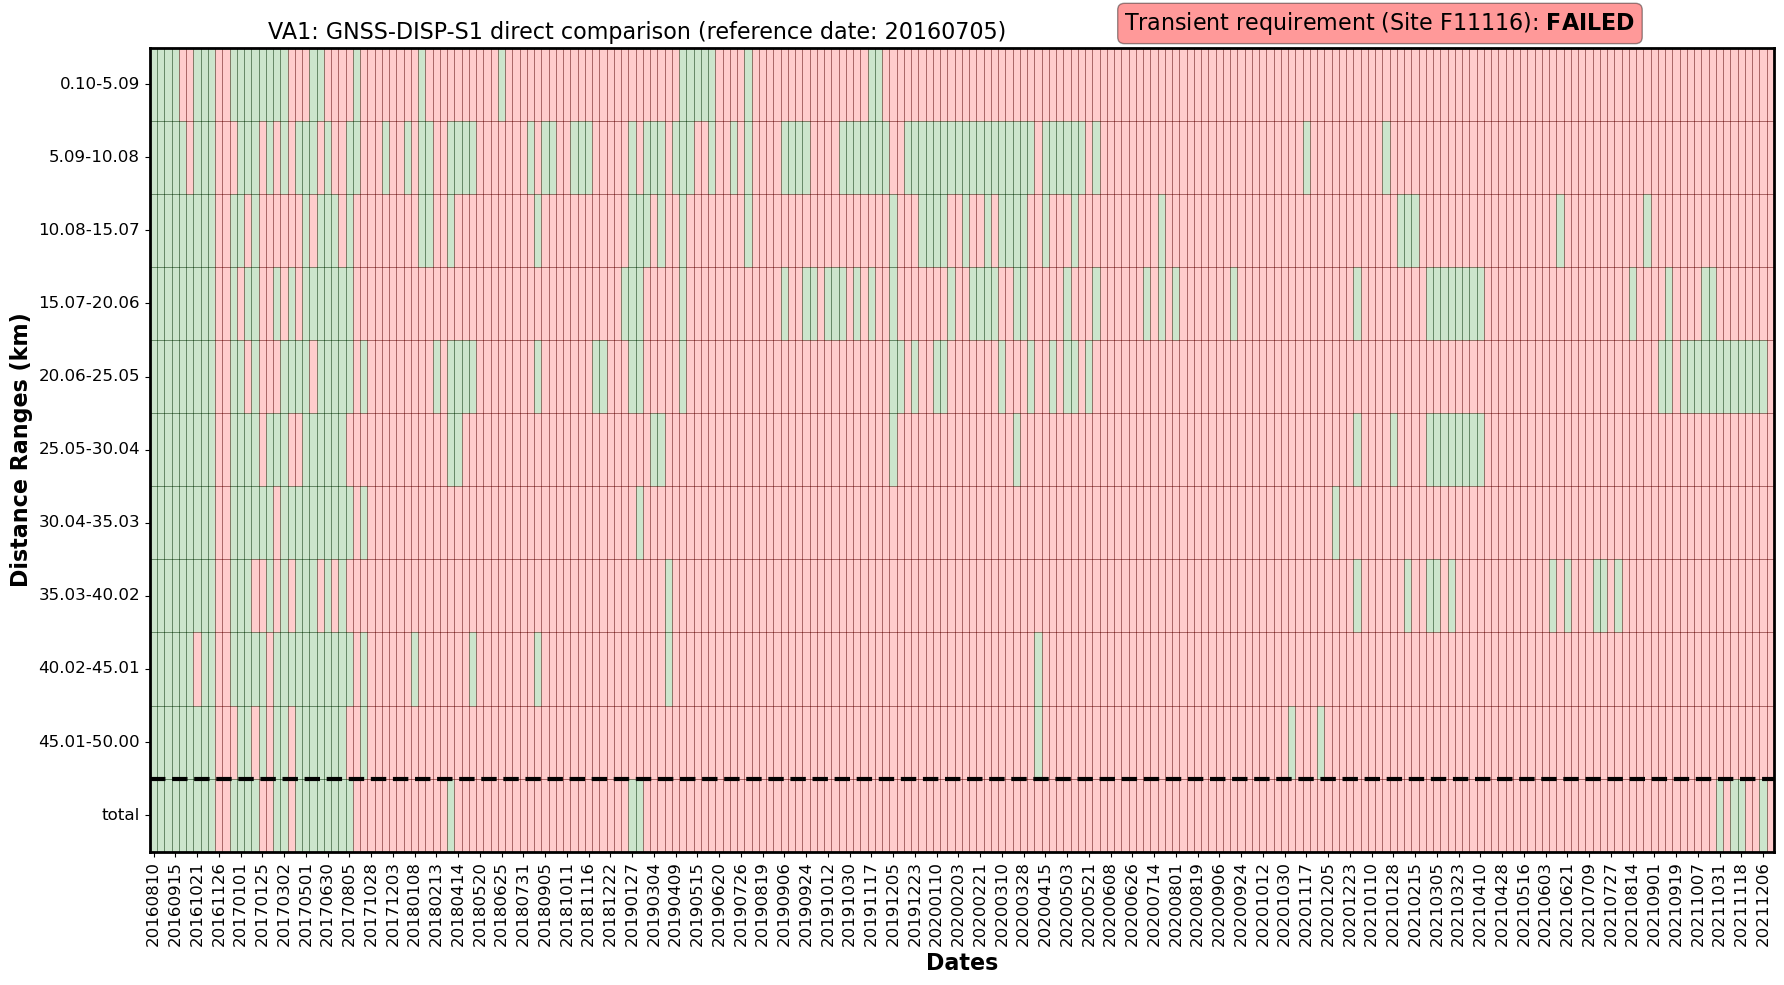

In [42]:
# output figure for displaying a validation result
reference_date = ifgs_date_dt[0,0].strftime('%Y%m%d') 
title_text = f'VA1: GNSS-DISP-S1 direct comparison (reference date: {reference_date})'
out_fig = f'{output_dir}/VA1_result_Transient_DISP-S1_vs_gnss_site{site}.png'
plot_transient_table(ratio_pd, site, percentage, thresthod, title_text, out_fig, annot=False) # generate a figure (annot=True means each cell has a value. Not recommended for large datasets)

<div class="alert alert-warning">
Approach 1 final result for CentralValleyA144: around 79% of DISP-S1s passes the requirement.
</div>

<a id='transient_validation2'></a>
# NISAR Validation Approach 2: Noise Level Validation

In this validation (Approach #2), we evaluate the estimated secular deformation rate (Requirements 658) or co-seismic displacement (Requirement 660) from time series processing or the individual DISP-S1 (Requirement 663) over selected cal/val areas with negligible deformation. Any estimated deformation should thus be treated as noise and our goal is to evaluate the significance of this noise. In general, noise in the modeled displacement or the unwrapped DISP-S1 is anisotropic, but here we neglect this anisotropy. Also, we assume the noise is stationary.

We first randomly sample measurements and pair up sampled pixel measurements. For each pixel-pair, the difference of their measurement becomes:
$$d\left(r\right)=|(f\left(x\right)-f\left(x-r\right))|$$
Estimates of $d(r)$ from all pairs are binned according to the distance r. In each bin, $d(r)$ is assumed to be a normal distribution.

**Note:** Now we simply assume there is no deformation in this study area and time interval. But in fact, it is hard to find a enough large area without any deformation. An more realistic solution is to apply a mask to mask out deformed regions.

<a id='transient_pair2'></a>
## Randomly sample pixels and pair them up

Calculate the coordinate for every pixel:

In [43]:
X0,Y0 = load_geo_utm(disp_S1_metadata)
X0_2d,Y0_2d = np.meshgrid(X0,Y0)

For each DISP-S1, randomly selected pixels need to be paired up. In order to keep measurements independent, different pixel pairs can not share same pixel. This is achieved by pairing up in sequence, i.e., pairing up pixel number 1 and number 2, 3 and 4...

In [44]:
dist = {}; rel_measure = {}
for i in dates_index:
    ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=i, coh_thr=minCoherence_parm) * phase2range*1000    # unit in mm   
    if apply_nonlinear_mask:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score])
    else:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr])

    dist_i, rel_measure_i = samp_pair(X0_2d,Y0_2d,ifgs_slice,num_samples=1000000)
    dist[i] = dist_i / 1000     # unit: km
    rel_measure[i] = rel_measure_i

Show the statistical property of selected pixel pairs:

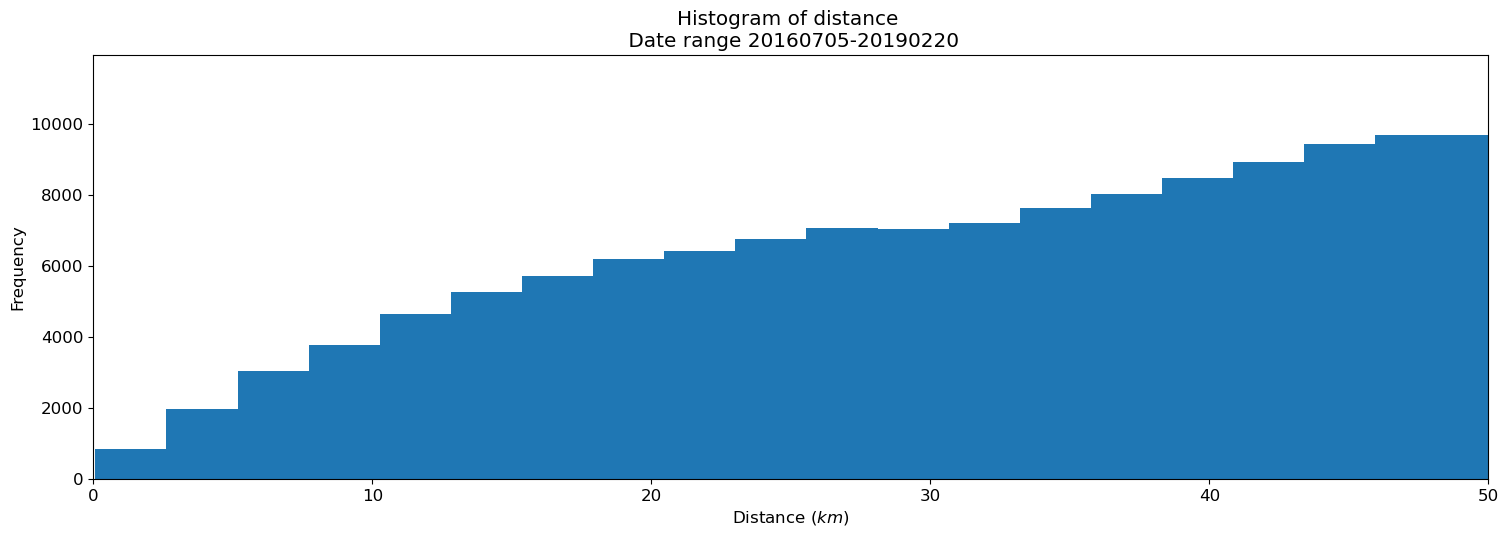

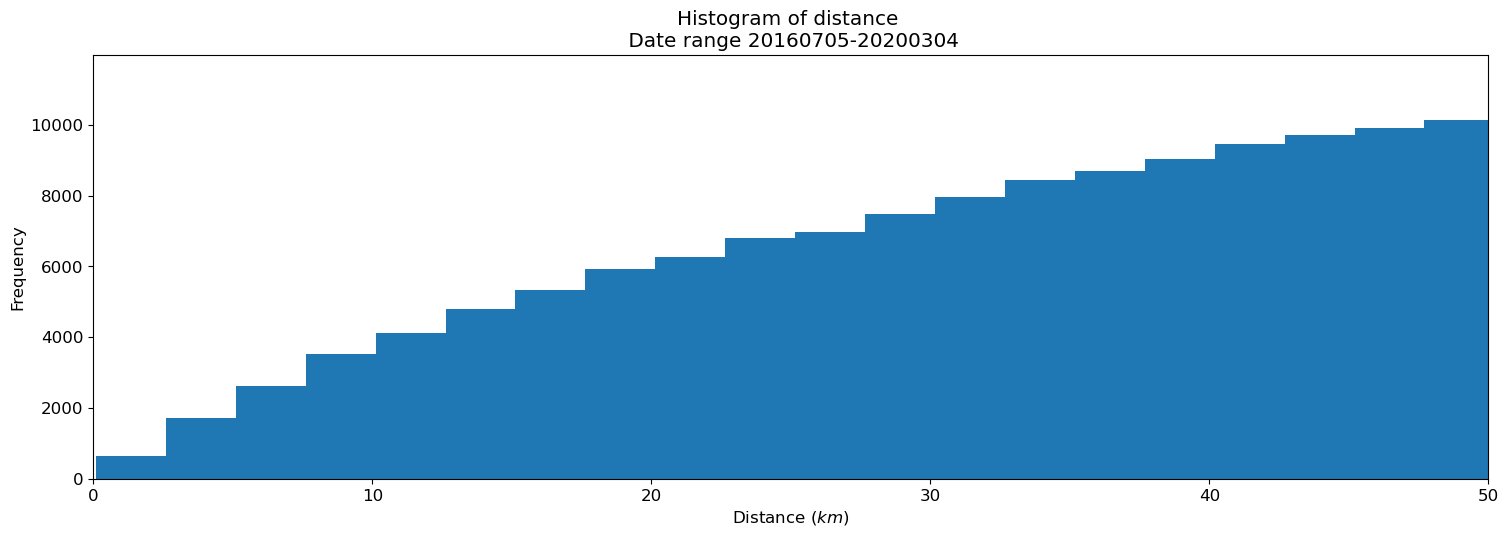

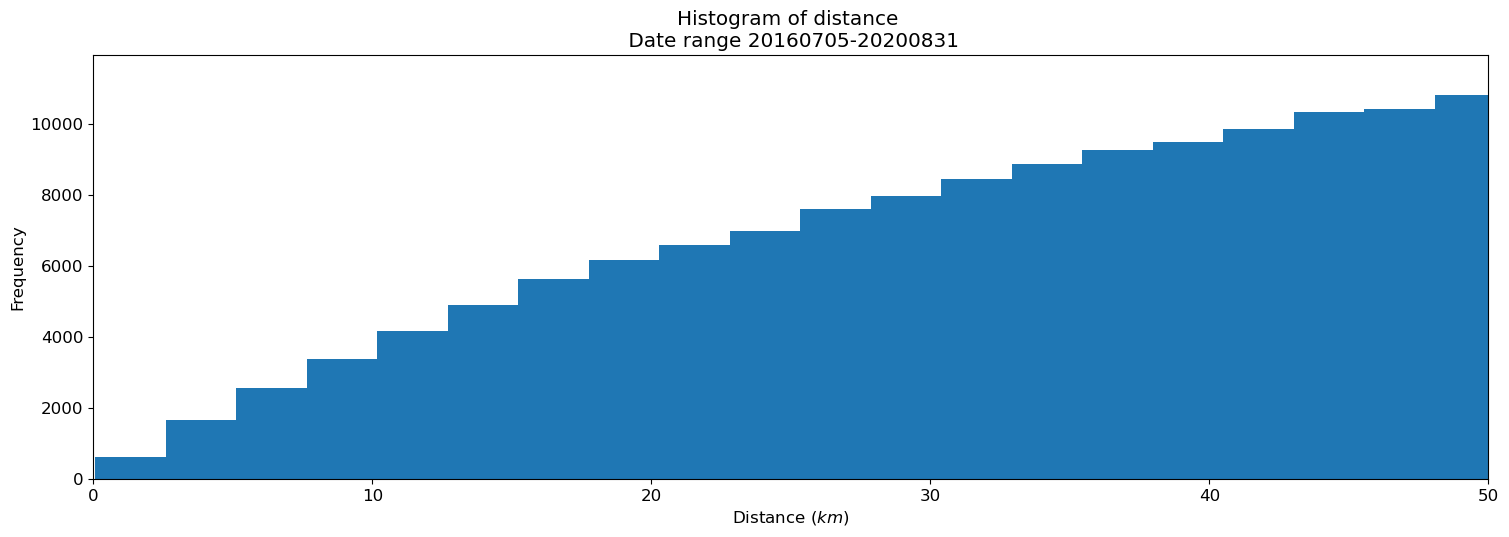

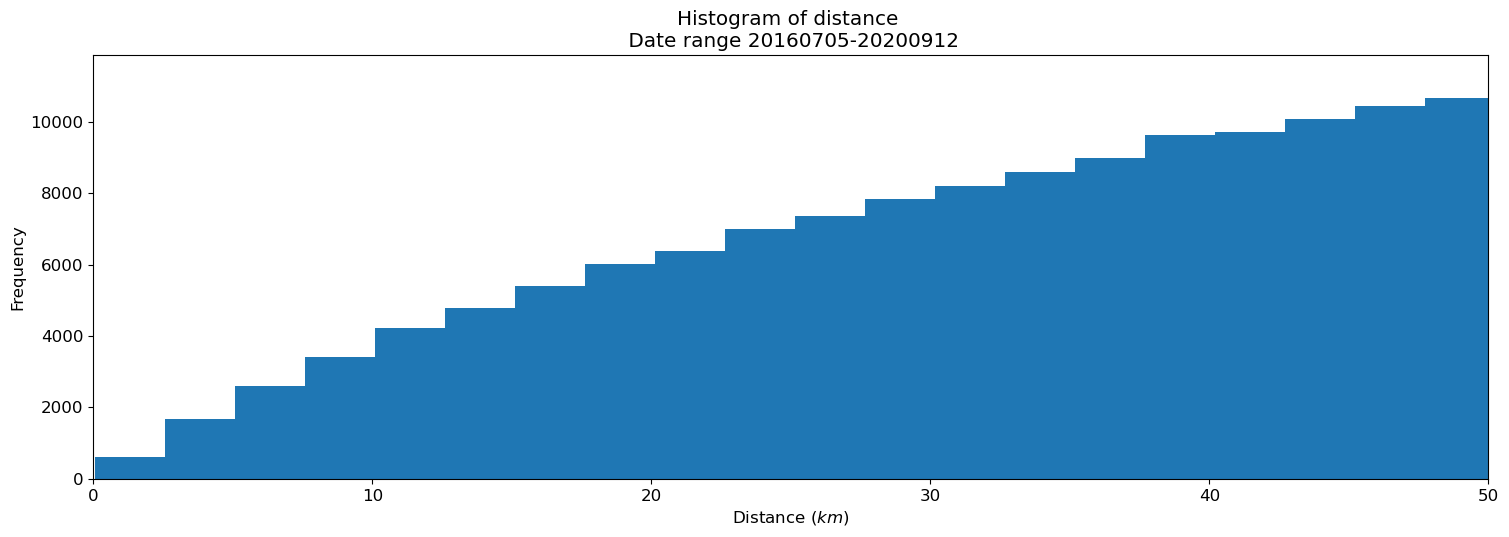

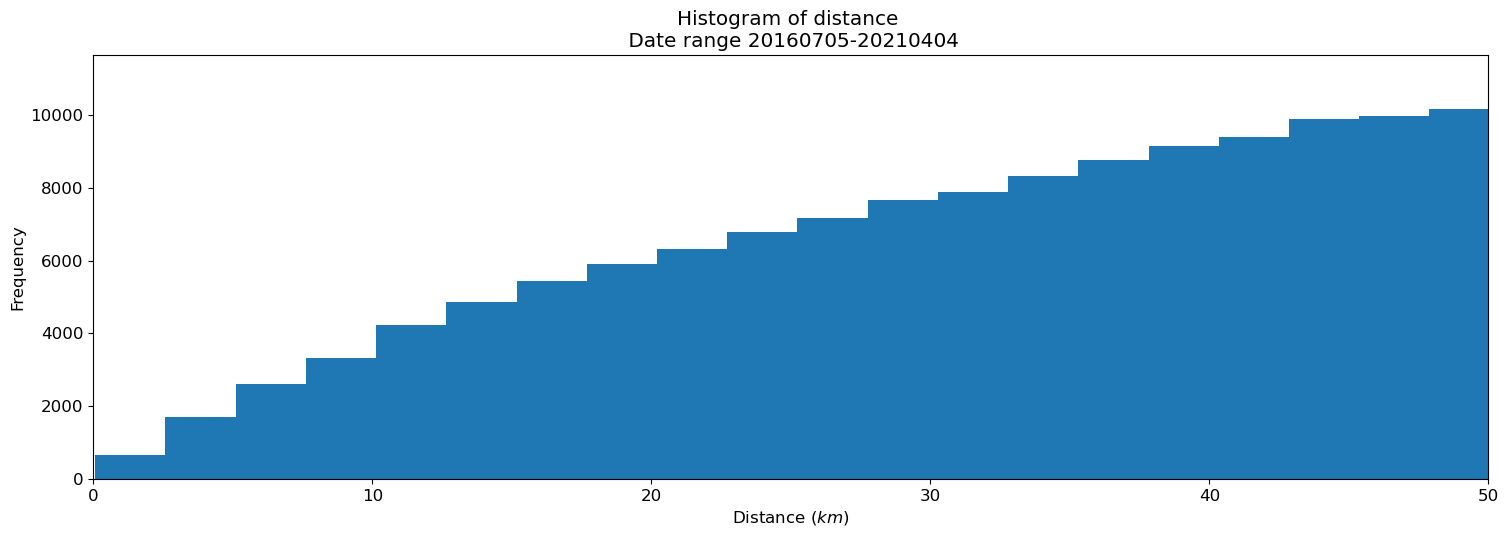

In [45]:
num_figs = 5  

sampled_index = sorted(random.sample(dates_index,num_figs))

for i in sampled_index:
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.hist(dist[i], bins=100)
    ax.set_title(f"Histogram of distance \n Date range {ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}")
    ax.set_xlabel(r'Distance ($km$)')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0,50)

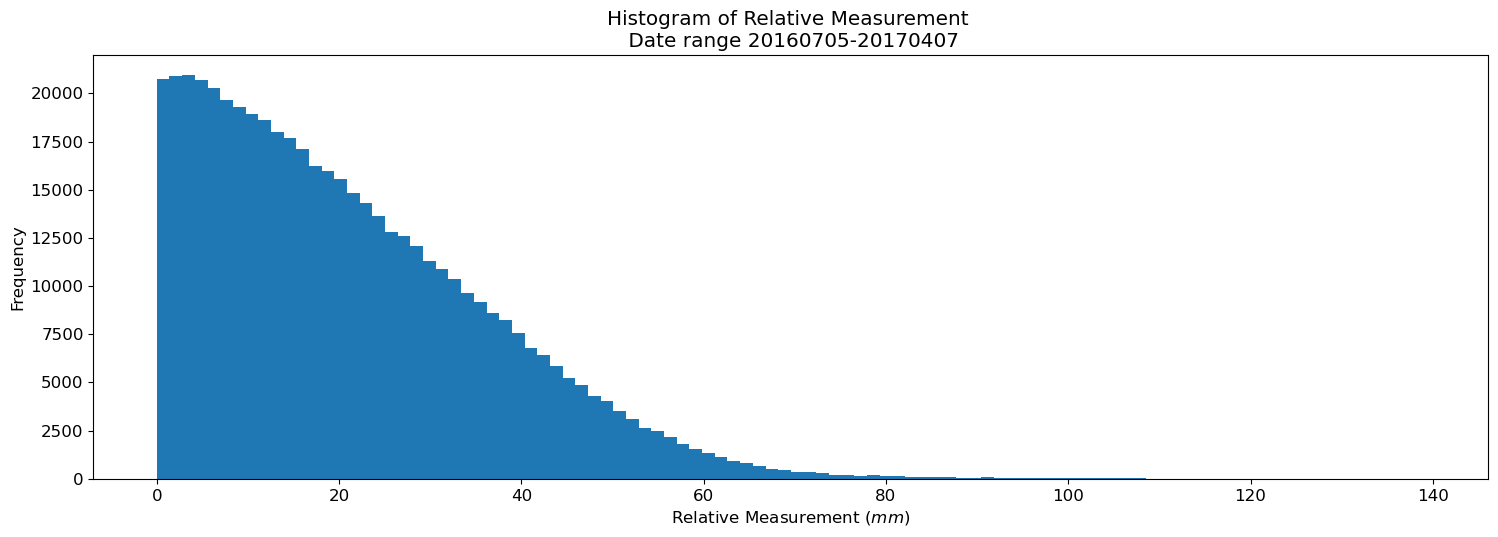

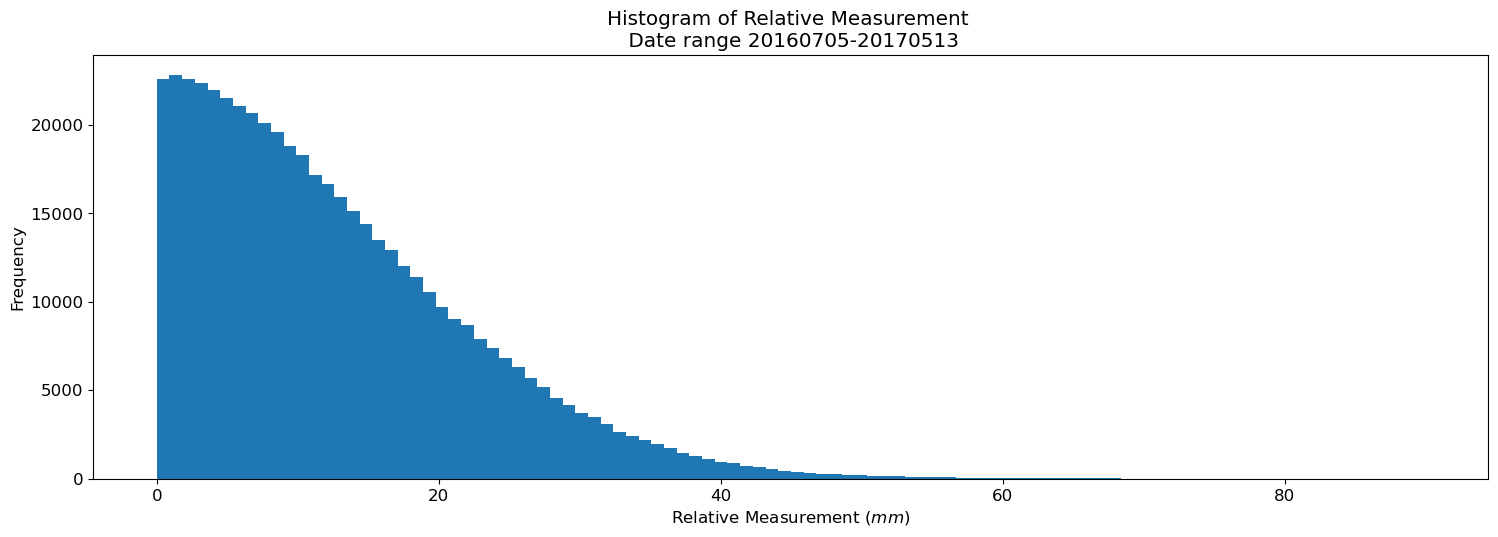

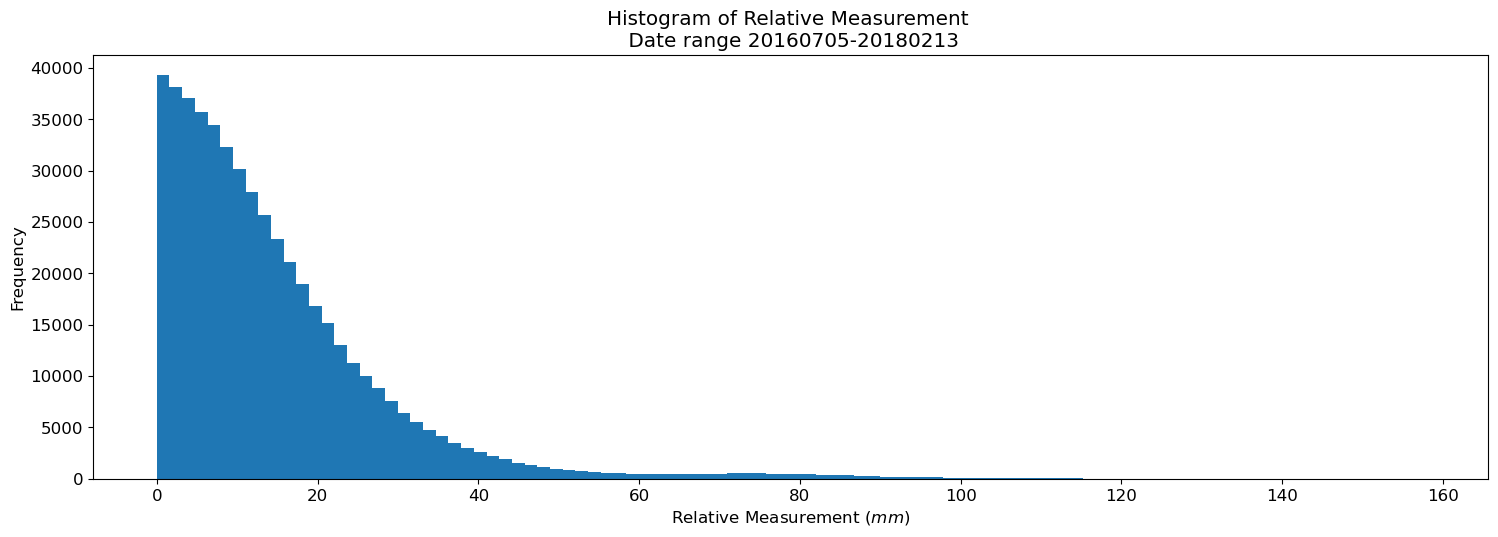

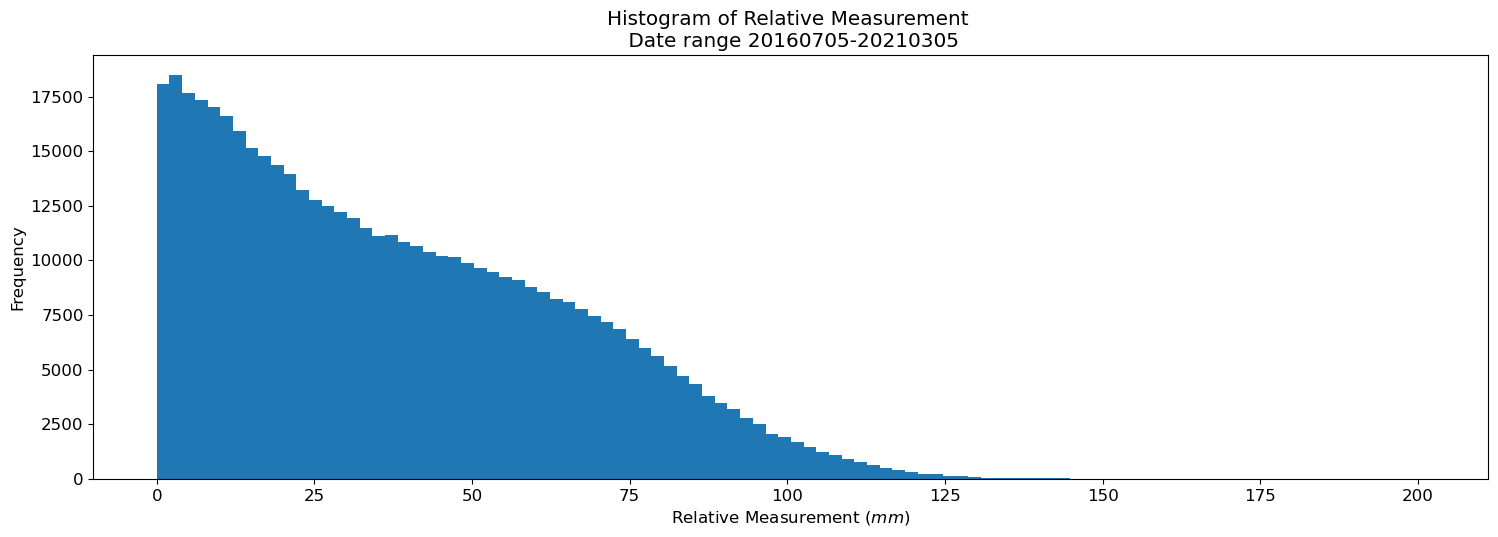

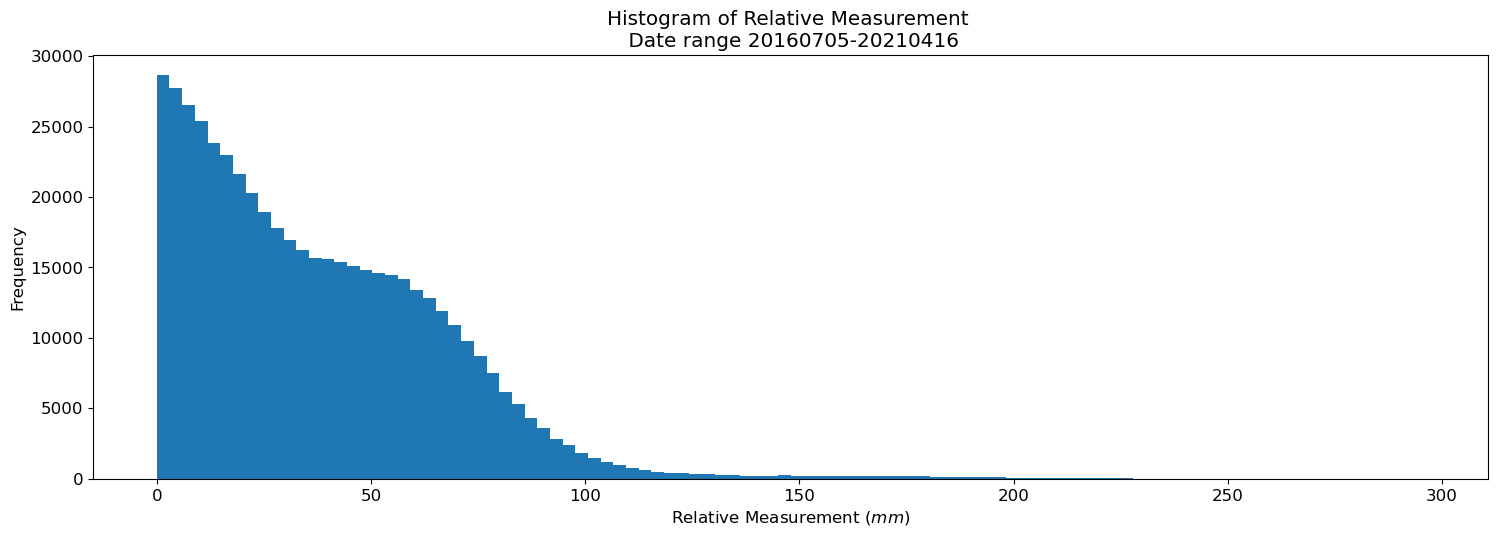

In [46]:
num_figs = 5  

sampled_index = sorted(random.sample(dates_index,num_figs))

for i in sampled_index:
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.hist(rel_measure[i], bins=100)
    ax.set_title(f"Histogram of Relative Measurement \n Date range {ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}")
    ax.set_xlabel(r'Relative Measurement ($mm$)')
    ax.set_ylabel('Frequency')

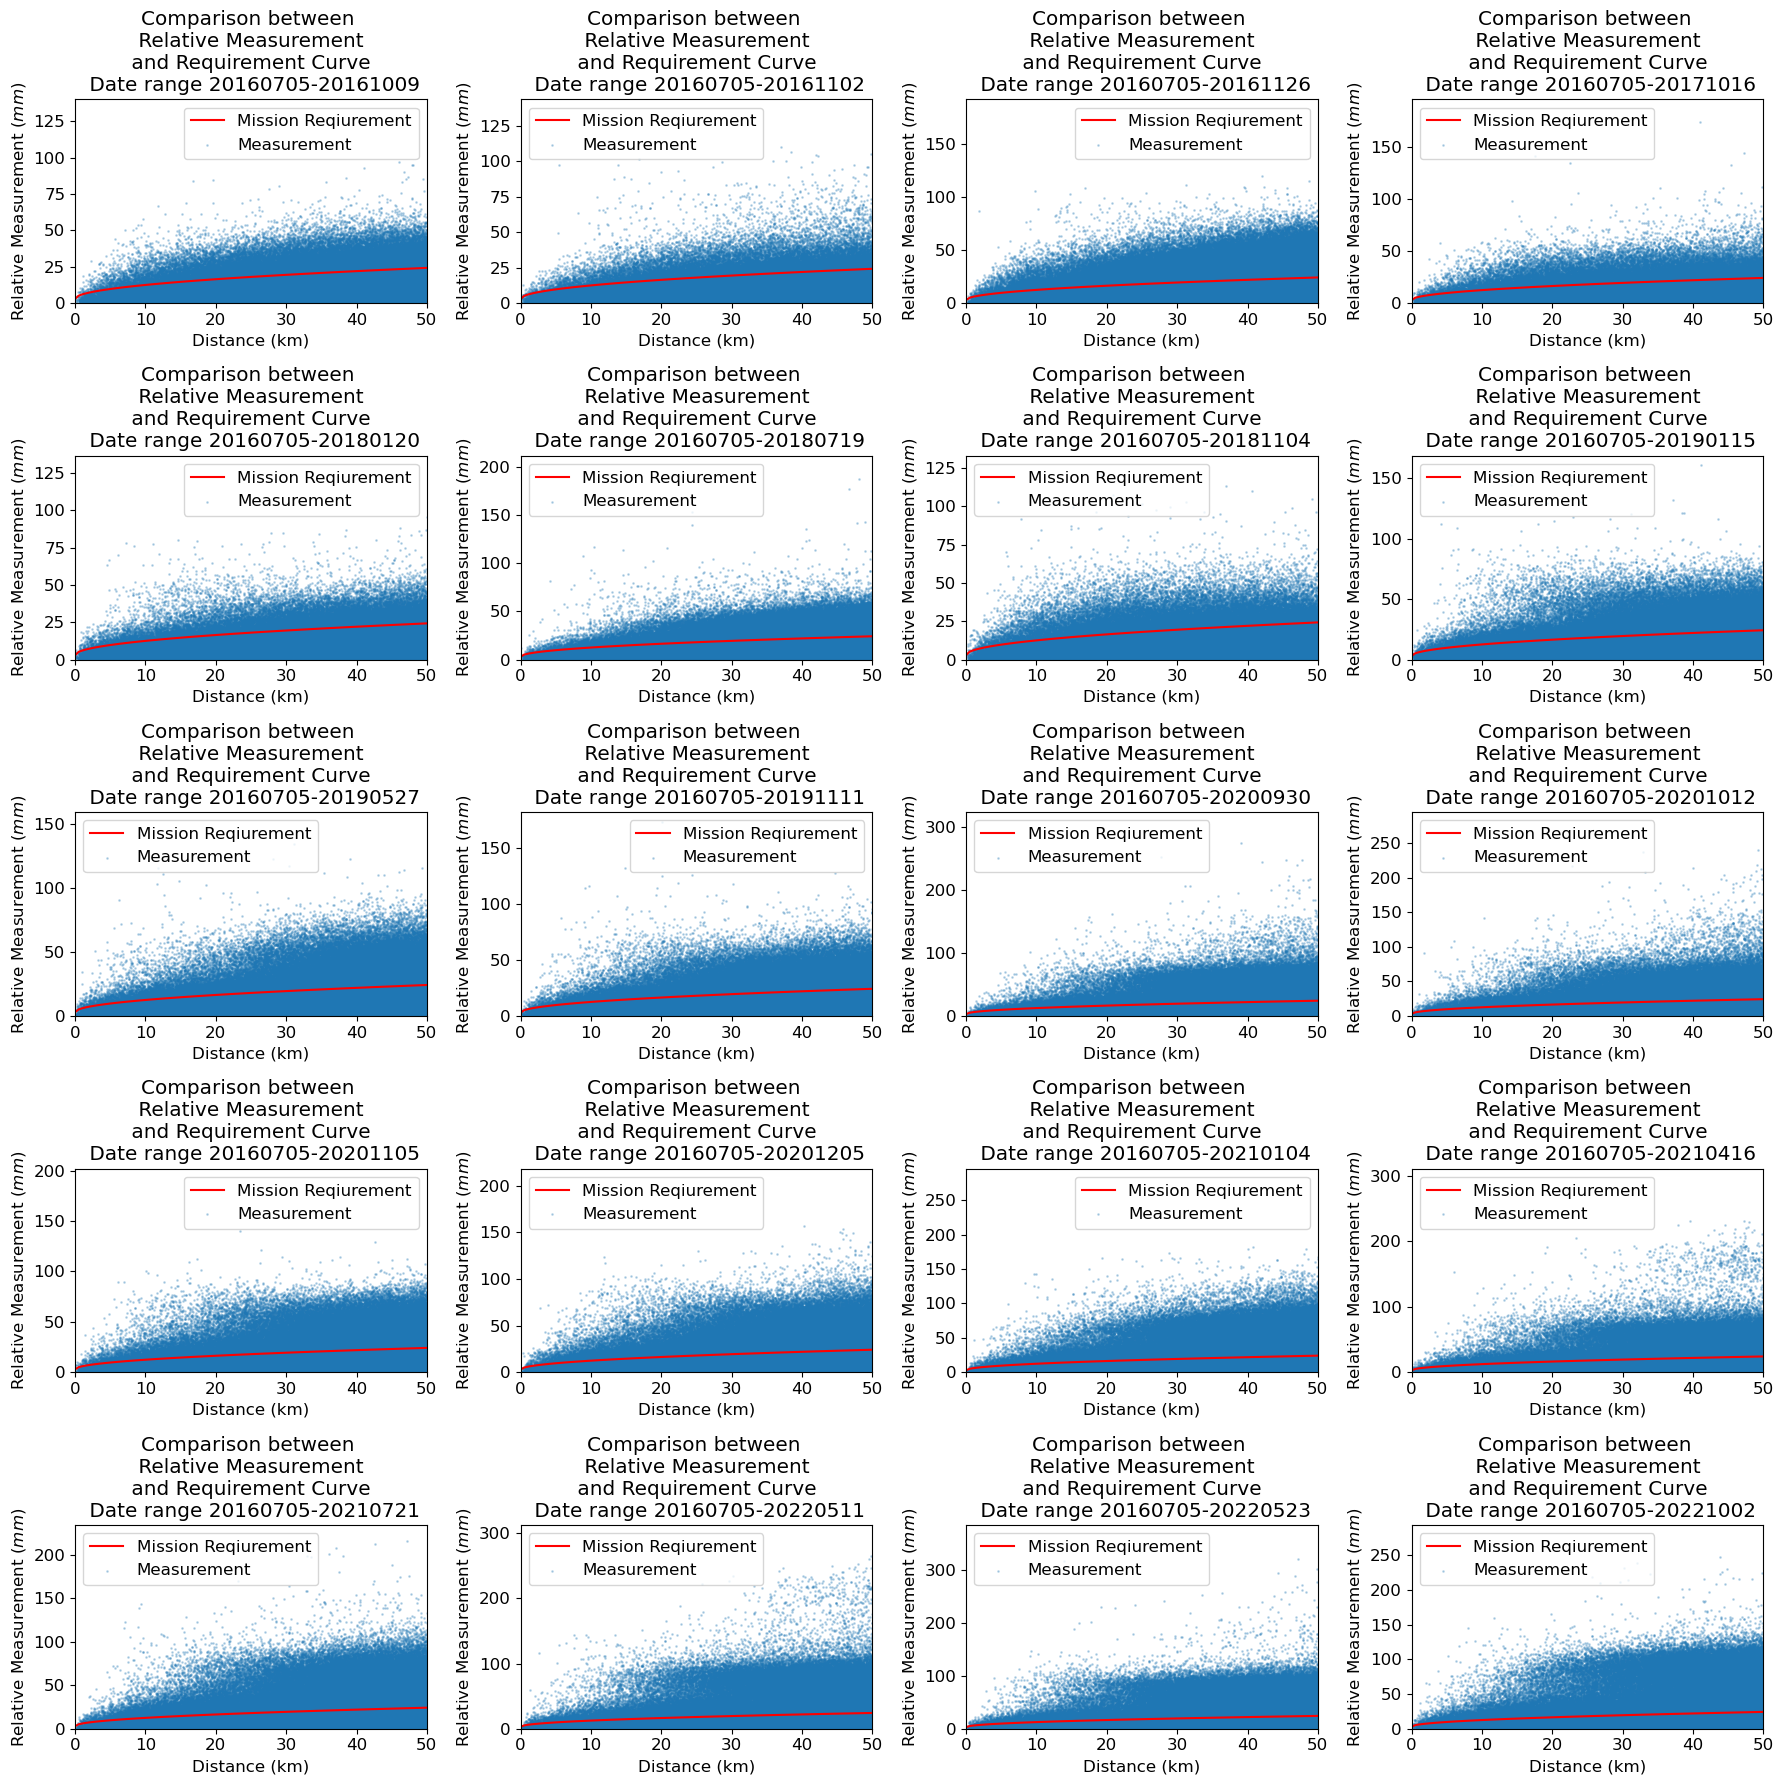

In [47]:
# Plotting only sampled pairs due to a large volume of DISP-S1
n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

col_figs = 4    # number of colums in figures
num_pairs_to_plot = 20

if num_pairs_to_plot > n_pairs:
    num_pairs_to_plot = n_pairs

num_figs = int(np.ceil(num_pairs_to_plot/col_figs)) * col_figs

sampled_index = sorted(random.sample(dates_index,num_pairs_to_plot))

fig, ax = plt.subplots(int(np.ceil(num_pairs_to_plot/col_figs)), col_figs, figsize=[18, 18])
axs = ax.ravel()

dist_th = np.linspace(0,50,100)
rqmt = 3*(1+np.sqrt(dist_th))

for counter in range(num_figs):
    if (counter<n_pairs):
        _ind = sampled_index[counter]
        axs[counter].plot(dist_th, rqmt, 'r', label="Mission Reqiurement")
        axs[counter].scatter(dist[_ind], rel_measure[_ind], s=1, alpha=0.25, label="Measurement")
        axs[counter].set_title(f"Comparison between \n Relative Measurement \n and Requirement Curve \n Date range {ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}")
        axs[counter].set_ylabel(r'Relative Measurement ($mm$)')
        axs[counter].set_xlabel('Distance (km)')
        axs[counter].set_xlim(0,50)
        axs[counter].set_ylim(ymin=0)
        axs[counter].legend()
    else:
        axs[counter].axis('off')

fig.tight_layout()

out_fig = f'{output_dir}/VA2_transient_relative_DISP-S1_measurements_randomSelected_site{site}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

In [48]:
separate_figure_flag = False     # if plotting separate figures is needed

if separate_figure_flag:

    cmap = copy.copy(plt.get_cmap('RdBu'))

    n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

    dist_th = np.linspace(0,50,100)
    rqmt = 3*(1+np.sqrt(dist_th))

    for counter in range(n_pairs):

        fig, ax = plt.subplots(figsize=[12,12])
        _ind = dates_index[counter]
        ax.plot(dist_th, rqmt, 'r', label="Mission Reqiurement")
        ax.scatter(dist[_ind], rel_measure[_ind], s=1, alpha=0.25, label="Measurement")
        ax.set_title(f"Comparison between \n Relative Measurement \n and Requirement Curve \n Date range {ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}")
        ax.set_ylabel(r'Relative Measurement ($mm$)')
        ax.set_xlabel('Distance (km)')
        ax.set_xlim(0,50)
        ax.set_ylim(ymin=0)

        out_fig = f"{output_dir}/VA2_transient_relative_DISP-S1_measurements_site{site}_date{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}.png"
        fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
        plt.close()

We have got data used of approach 2:
- `dist`: distance of pixel pairs,
- `rel_measure`: relative measurement of pixel pairs,

<a id='transient_bin2'></a>
## Validate the requirement based on binned measurement residuals

In [49]:
n_ifgs = len(dist)

Bin all measurement residuals to check if they pass the requirements or not:

In [50]:
n_bins = 10
bins = np.linspace(0.1,50.0,num=n_bins+1)

In [51]:
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points pass

for counter, i in enumerate(dates_index):
    inds = np.digitize(dist[i],bins)
    for j in range(1,n_bins+1):
        rqmt = 3*(1+np.sqrt(dist[i][inds==j]))# mission requirement for i-th ifgs and j-th bins
        rem = rel_measure[i][inds==j] # relative measurement
        assert len(rqmt) == len(rem)
        n_all[counter,j-1] = len(rem)
        n_pass[counter,j-1] = np.count_nonzero(rem<rqmt)
    n_all[counter,-1] = np.sum(n_all[counter,0:-2])
    n_pass[counter,-1] = np.sum(n_pass[counter,0:-2])

In [52]:
ratio = n_pass/n_all
mean_ratio = np.array([np.mean(ratio[:,:-1],axis=1)])
ratio = np.hstack((ratio,mean_ratio.T))
thresthod = 0.683
#The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio>thresthod

<a id='transient_result2'></a>
## Result visualization

Convert the result to pandas DataFrame for better visulization:

In [53]:
def to_str(x: bool):
    return 'true ' if x else 'false '

success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in dates_index:
    index.append(ifgs_date_dt[i,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[i,1].strftime('%Y%m%d'))

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns+['mean'],index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns+['mean'],index=index)

Number of data points in each bin:

In [54]:
n_all_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160705-20160810       1952        5090         8060        10847   
20160705-20160822       1864        5107         8023        10955   
20160705-20160903       1907        5138         8282        10995   
20160705-20160915       1819        5047         8185        10995   
20160705-20160927       1870        5314         8293        11071   
...                      ...         ...          ...          ...   
20160705-20230130       2935        6762         9510        11280   
20160705-20230211       3190        6870         9576        11192   
20160705-20230223       3183        7419        10053        11442   
20160705-20230307       3298        7089         9663        11117   
20160705-20230319       3787        7813        10397        11334   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160705-20160810        13469        15409        17563        19491   
20160705-20160822        13463        15888        17773        19168   
20160705-20160903        13648        15530        17545        19450   
20160705-20160915        13494        15865        17715        19352   
20160705-20160927        13685        15826        17750        19777   
...                        ...          ...          ...          ...   
20160705-20230130        11943        12813        13829        15309   
20160705-20230211        11895        12861        13908        15161   
20160705-20230223        12222        13112        14028        15546   
20160705-20230307        11741        12624        13612        15071   
20160705-20230319        11540        12167        13150        14425   

                   40.02-45.01  45.01-50.00   total  
20160705-20160810        20487        21723  112368  
20160705-20160822        20792        21527  113033  
20160705-20160903        20941        21524  113436  
20160705-20160915        20705        22024  113177  
20160705-20160927        20950        22062  114536  
...                        ...          ...     ...  
20160705-20230130        17167        18556  101548  
20160705-20230211        17166        18501  101819  
20160705-20230223        17475        18740  104480  
20160705-20230307        16687        18327  100902  
20160705-20230319        15926        17243  100539  

[262 rows x 11 columns]

Number of data points that below the curve:

In [55]:
n_pass_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160705-20160810       1840        4691         7410         9784   
20160705-20160822       1715        4689         7383        10043   
20160705-20160903       1685        4394         6923         9165   
20160705-20160915       1650        4575         7399         9994   
20160705-20160927       1560        4256         6607         8632   
...                      ...         ...          ...          ...   
20160705-20230130       2016        4468         6068         7170   
20160705-20230211       2108        4331         5566         6092   
20160705-20230223       2187        5039         6324         6911   
20160705-20230307       2224        4658         6277         7108   
20160705-20230319       2265        4093         5116         5575   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160705-20160810        12033        13583        15240        16845   
20160705-20160822        12294        14563        16348        17696   
20160705-20160903        11329        12874        14763        16516   
20160705-20160915        12219        14379        16074        17576   
20160705-20160927        10730        12624        14512        16229   
...                        ...          ...          ...          ...   
20160705-20230130         7290         7464         7725         7643   
20160705-20230211         5874         5526         5307         5079   
20160705-20230223         7000         7049         7056         7195   
20160705-20230307         7419         7455         7446         7463   
20160705-20230319         5673         6072         6572         7480   

                   40.02-45.01  45.01-50.00   total  
20160705-20160810        17550        18361   98976  
20160705-20160822        19259        20063  103990  
20160705-20160903        18095        18722   95744  
20160705-20160915        18795        20025  102661  
20160705-20160927        17293        18479   92443  
...                        ...          ...     ...  
20160705-20230130         7743         7839   57587  
20160705-20230211         5081         4807   44964  
20160705-20230223         7616         7342   56377  
20160705-20230307         7704         7876   57754  
20160705-20230319         8597         9603   51443  

[262 rows x 11 columns]

Ratio of pass:

In [56]:
ratio_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160705-20160810   0.942623    0.921611     0.919355     0.902001   
20160705-20160822   0.920064    0.918152     0.920229     0.916750   
20160705-20160903   0.883587    0.855197     0.835909     0.833561   
20160705-20160915   0.907092    0.906479     0.903971     0.908959   
20160705-20160927   0.834225    0.800903     0.796696     0.779695   
...                      ...         ...          ...          ...   
20160705-20230130   0.686882    0.660751     0.638065     0.635638   
20160705-20230211   0.660815    0.630422     0.581245     0.544317   
20160705-20230223   0.687088    0.679202     0.629066     0.604003   
20160705-20230307   0.674348    0.657074     0.649591     0.639381   
20160705-20230319   0.598099    0.523870     0.492065     0.491883   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160705-20160810     0.893385     0.881498     0.867733     0.864245   
20160705-20160822     0.913169     0.916604     0.919822     0.923205   
20160705-20160903     0.830085     0.828976     0.841436     0.849152   
20160705-20160915     0.905514     0.906335     0.907367     0.908227   
20160705-20160927     0.784070     0.797675     0.817577     0.820600   
...                        ...          ...          ...          ...   
20160705-20230130     0.610399     0.582533     0.558609     0.499249   
20160705-20230211     0.493821     0.429671     0.381579     0.335004   
20160705-20230223     0.572738     0.537599     0.502994     0.462820   
20160705-20230307     0.631888     0.590542     0.547017     0.495189   
20160705-20230319     0.491594     0.499055     0.499772     0.518544   

                   40.02-45.01  45.01-50.00     total      mean  
20160705-20160810     0.856641     0.845233  0.880820  0.889432  
20160705-20160822     0.926270     0.931992  0.919997  0.920626  
20160705-20160903     0.864094     0.869820  0.844035  0.849182  
20160705-20160915     0.907752     0.909235  0.907084  0.907093  
20160705-20160927     0.825442     0.837594  0.807109  0.809448  
...                        ...          ...       ...       ...  
20160705-20230130     0.451040     0.422451  0.567091  0.574562  
20160705-20230211     0.295992     0.259824  0.441607  0.461269  
20160705-20230223     0.435823     0.391782  0.539596  0.550311  
20160705-20230307     0.461677     0.429748  0.572377  0.577646  
20160705-20230319     0.539809     0.556922  0.511672  0.521161  

[262 rows x 12 columns]

In [57]:
df_ratio = ratio_pd.copy()
df_success = success_or_fail_pd.copy()

In [58]:
# Assuming your dataframe is called 'df'
s = df_ratio.style.format(precision=3)

# Format the index (date ranges) for better readability
df_ratio.index = df_ratio.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_ratio.index.name = "Date range"
df_ratio.columns = [f"{col} km" if (col != "total") and (col != "mean") else col for col in df_ratio.columns]     # Add units to column headers

df_success.index = df_success.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_success.index.name = "Date range"
df_success.columns = [f"{col} km" if (col != "total") and (col != "mean") else col for col in df_success.columns] 

# Set table styles
s.set_table_styles([
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle; border: 1px solid black;'},
    {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.25em; font-weight: bold; background-color: #f2f2f2; padding: 8px;'},
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle;'},
    {'selector': 'table', 'props': 'border-collapse: collapse;'},
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
    {'selector': f'td:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'th:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'td:nth-child({len(df_ratio.columns) - 1})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'th:nth-child({len(df_ratio.columns) - 1})', 'props': 'border-right: 2px dashed black;'},
    {'selector': '.index_name', 'props': 'font-weight: bold; font-size: 1.1em; text-align: center;'},
    {'selector': 'tr:first-child', 'props': 'border-top: none;'},
    {'selector': 'tr:last-child', 'props': 'border-bottom: none;'},
    {'selector': 'td:first-child, th:first-child', 'props': 'border-left: none;'},
    {'selector': 'td:last-child, th:last-child', 'props': 'border-right: none;'},
])

s.set_td_classes(df_success)

# Set caption
s.set_caption("Distance")

s.set_properties(**{'text-align': 'center'})

# Display the styled table
s

In [59]:
ratio_pd.to_csv(f'{output_dir}/VA2_transient_insa_relative_distance_table_site{site}.csv')

html = s.to_html()

html_filename = f'{output_dir}/VA2_transient_insa_relative_distance_table_site{site}.html'
with open(html_filename, "w") as f:
    f.write(html)

<a id='transient_conclusion2'></a>
## Conclusion

Compared with percentage of total passed pairs, the mean value of percentage of passed pairs in all bin is a better indicator since it gives all bins same weight. 

In [60]:
percentage = np.count_nonzero(ratio_pd['mean']>thresthod)/n_ifgs

In [61]:
print(f"Percentage of DISP-S1s passes the requirement (70%): {percentage}.")
if percentage >= 0.70:
    print('The DISP-S1 stack passes the requirement.')
else:
    print('The DISP-S1 stack fails the requirement.')

Percentage of DISP-S1s passes the requirement (70%): 0.3244274809160305.
The DISP-S1 stack fails the requirement.


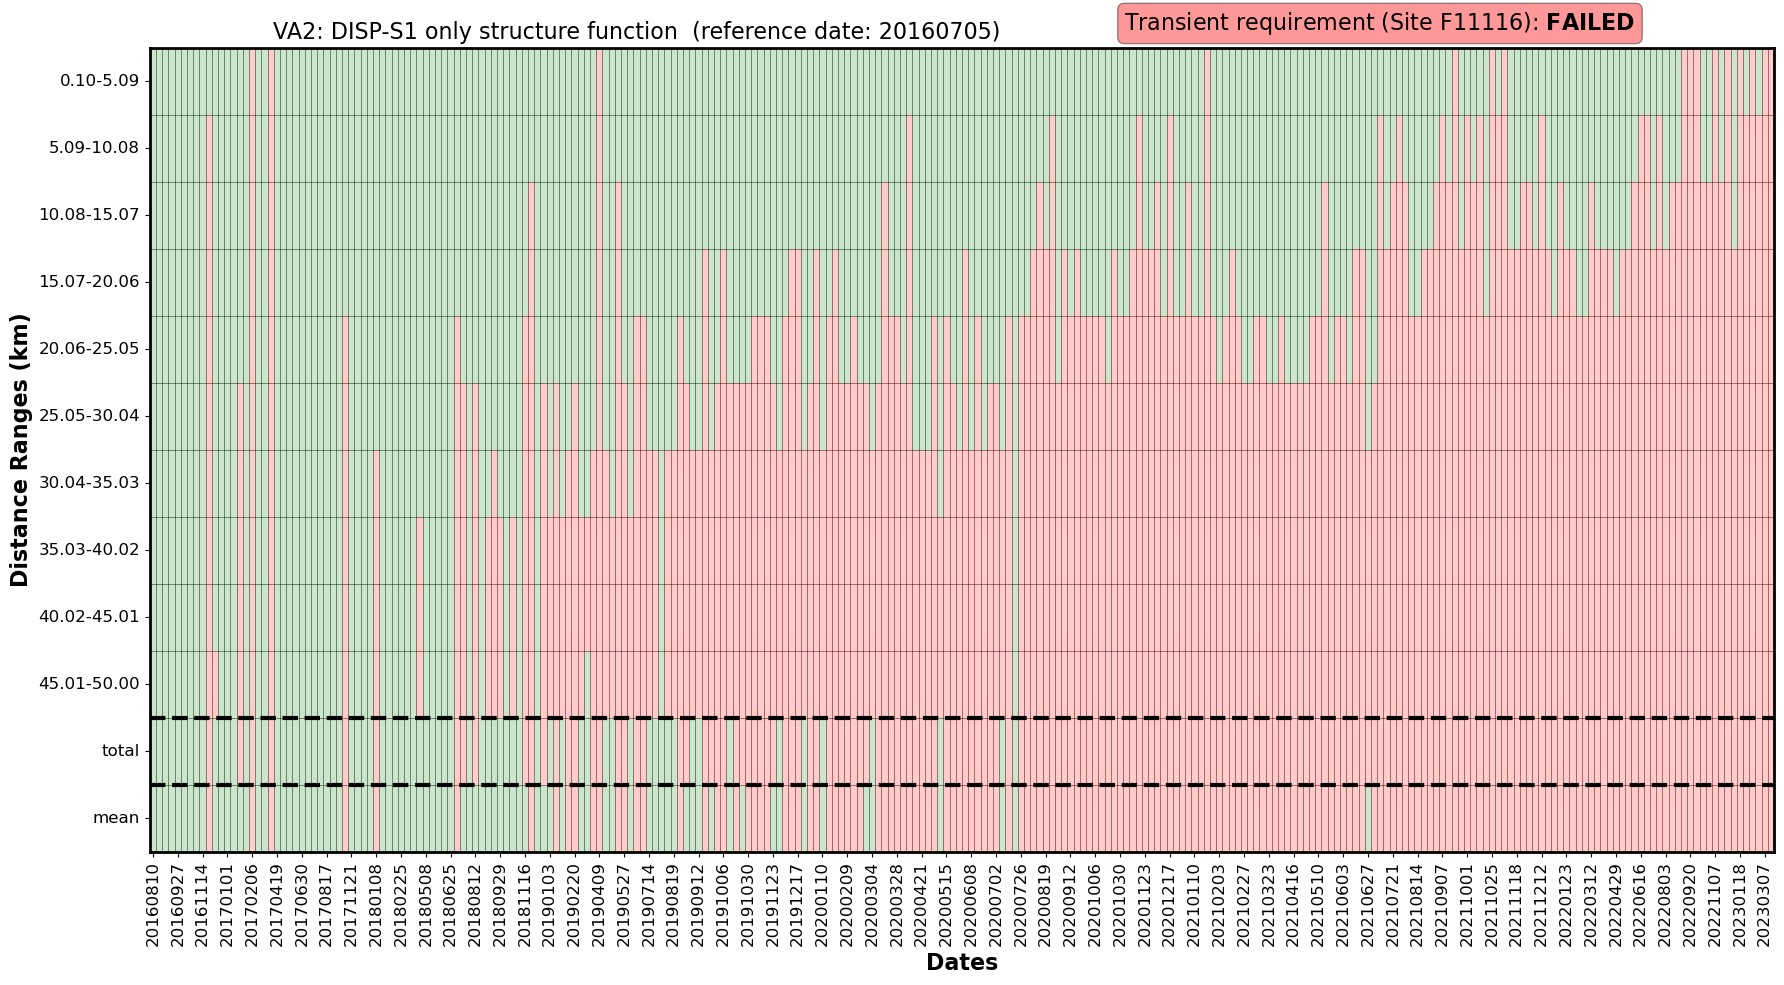

In [62]:
# output figure for displaying a validation result
reference_date = ifgs_date_dt[0,0].strftime('%Y%m%d') 
title_text = f'VA2: DISP-S1 only structure function  (reference date: {reference_date})'
out_fig = f'{output_dir}/VA2_result_Transient_relative_DISP-S1_measurements_site{site}.png'
plot_transient_table(ratio_pd, site, percentage, thresthod, title_text, out_fig, annot=False) # generate a figure (annot=True means each cell has a value. Not recommended for large datasets)

<div class="alert alert-warning">
Approach 2 final result for CentralValleyA144: 100% of DISP-S1s passes the requirement.
</div>

<a id='transient_appendix'></a>
# Appendix: GNSS Position Plots

GNSS vs DISP-S1 scatter plots

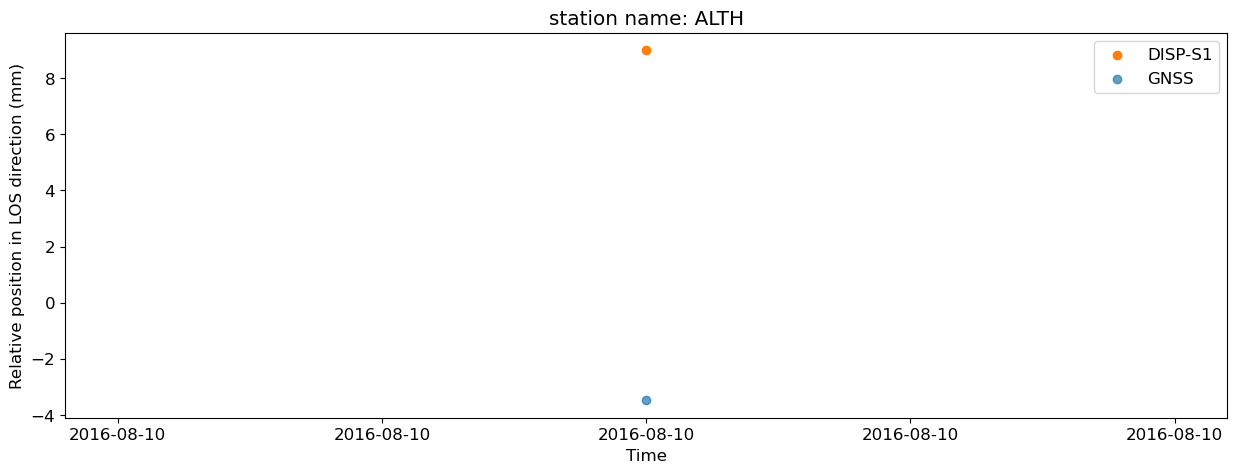

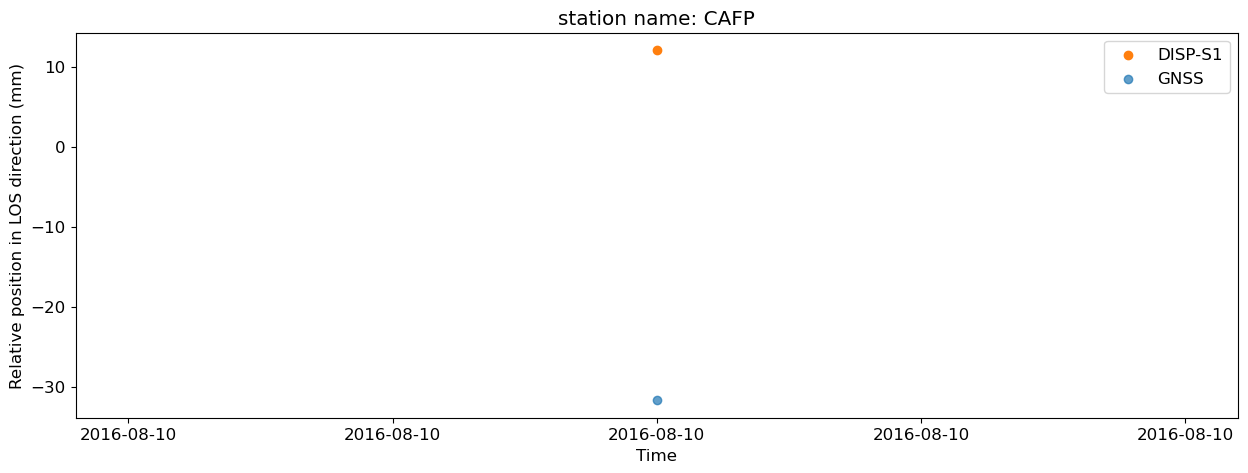

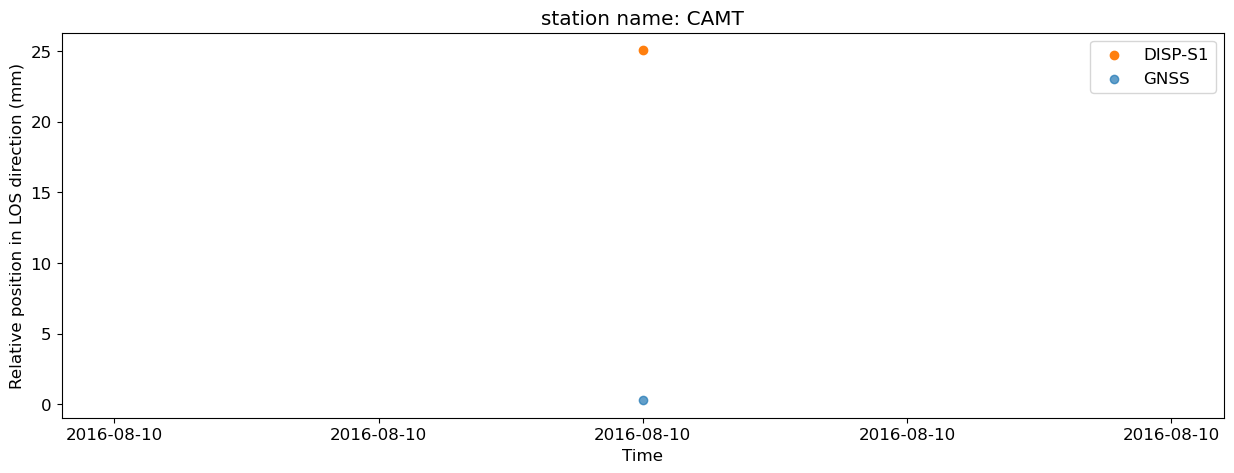

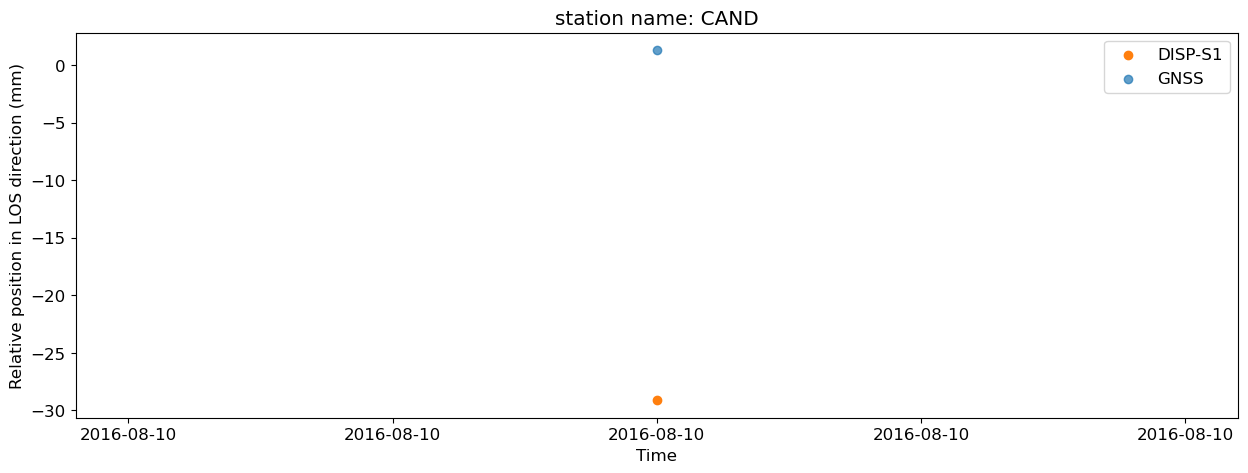

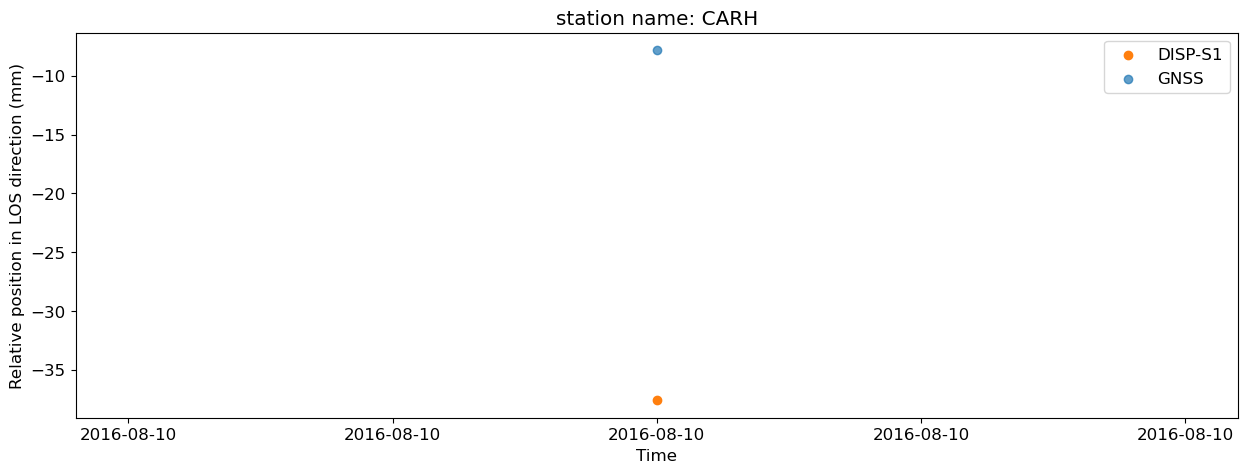

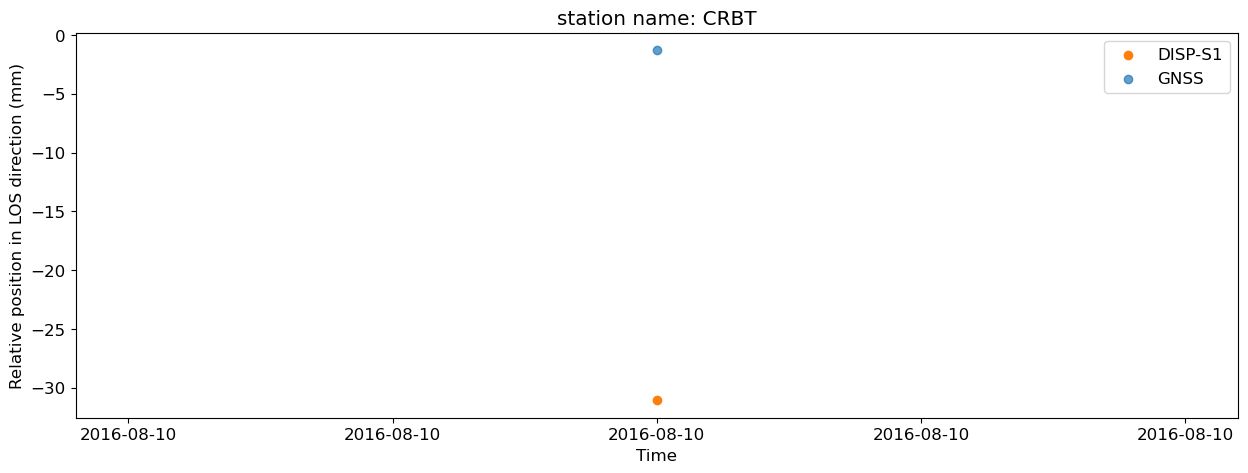

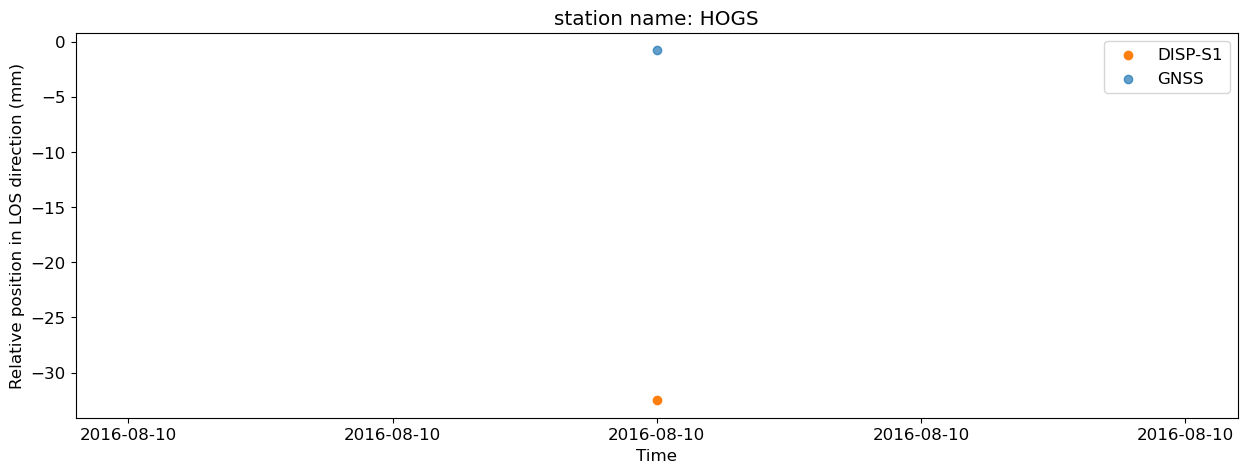

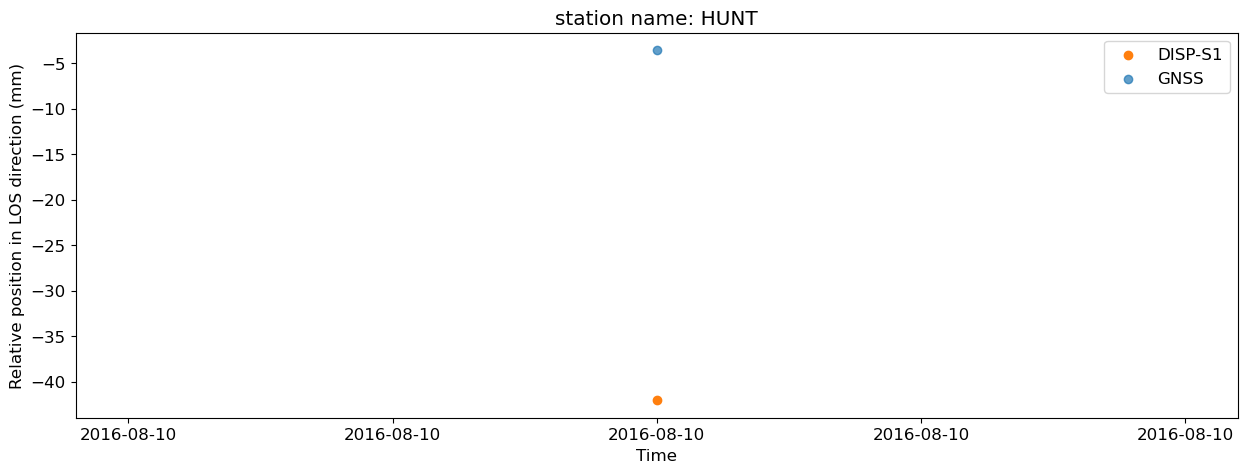

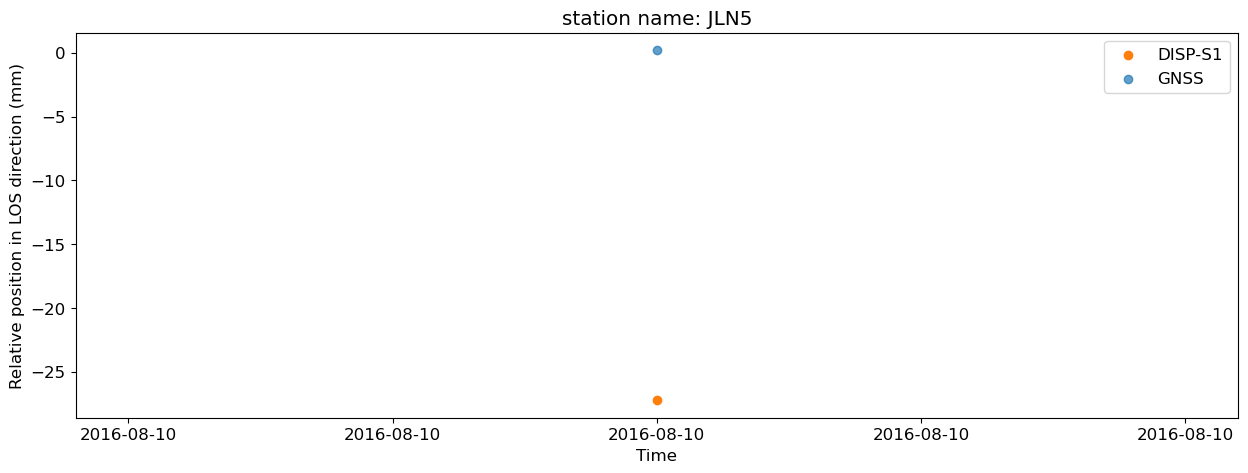

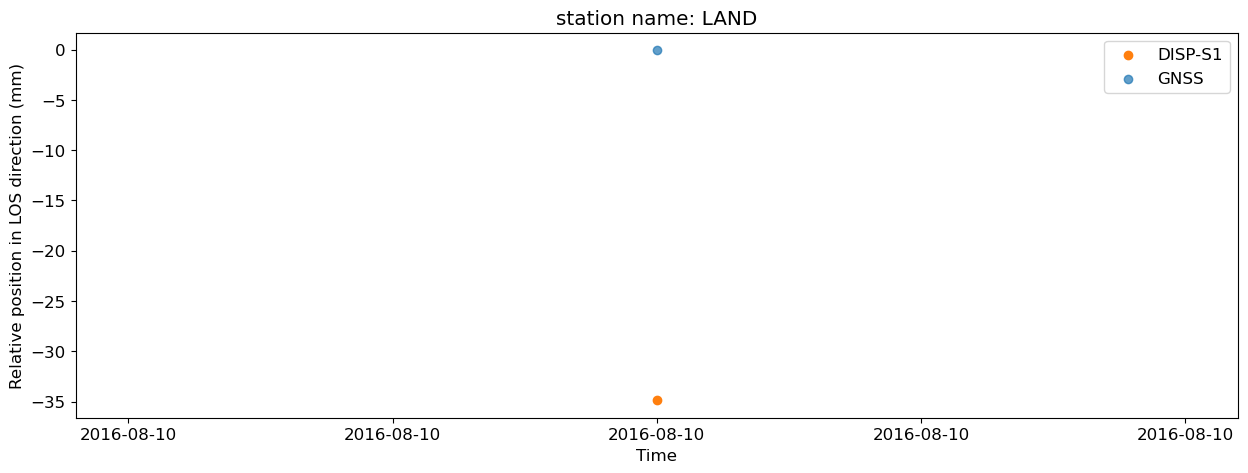

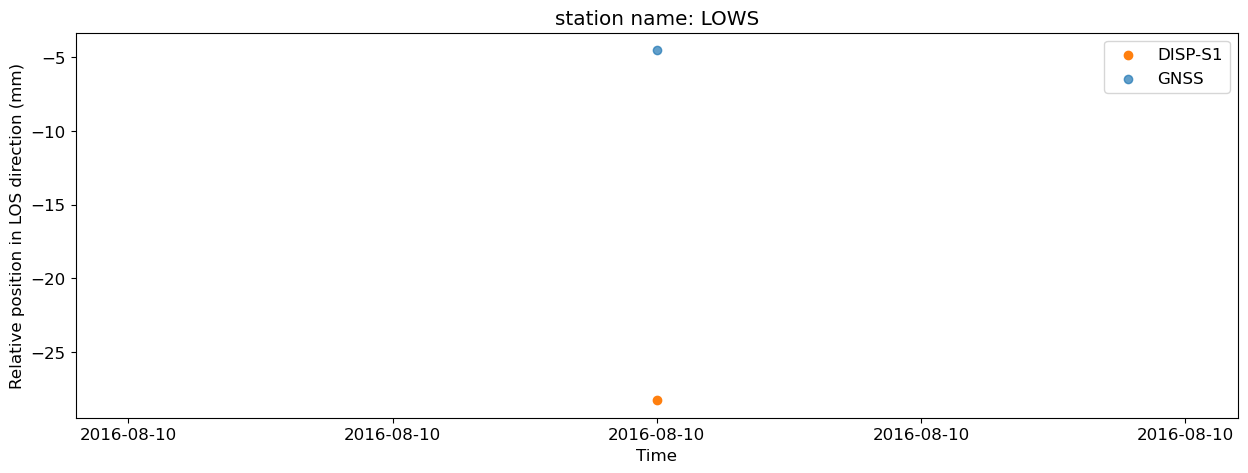

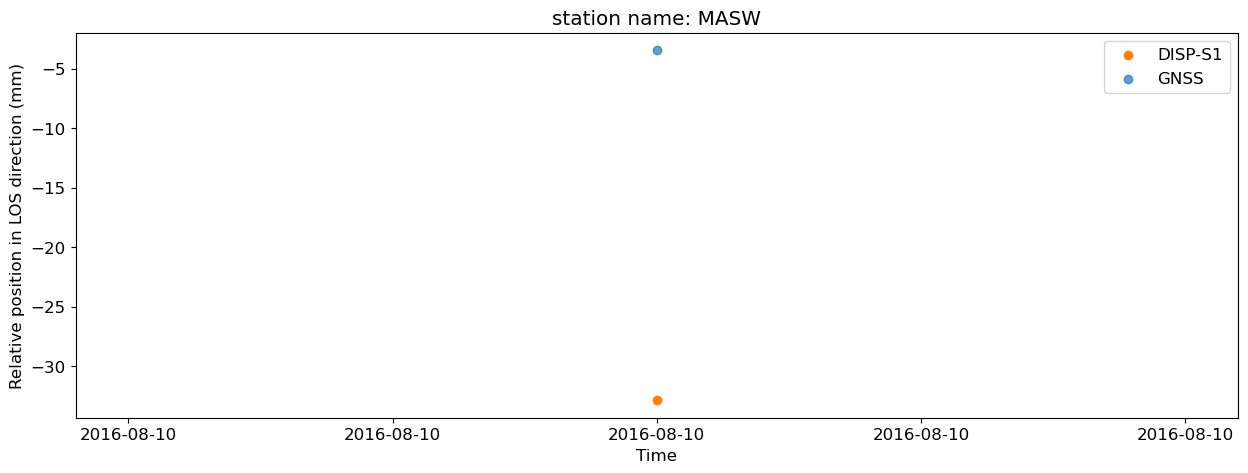

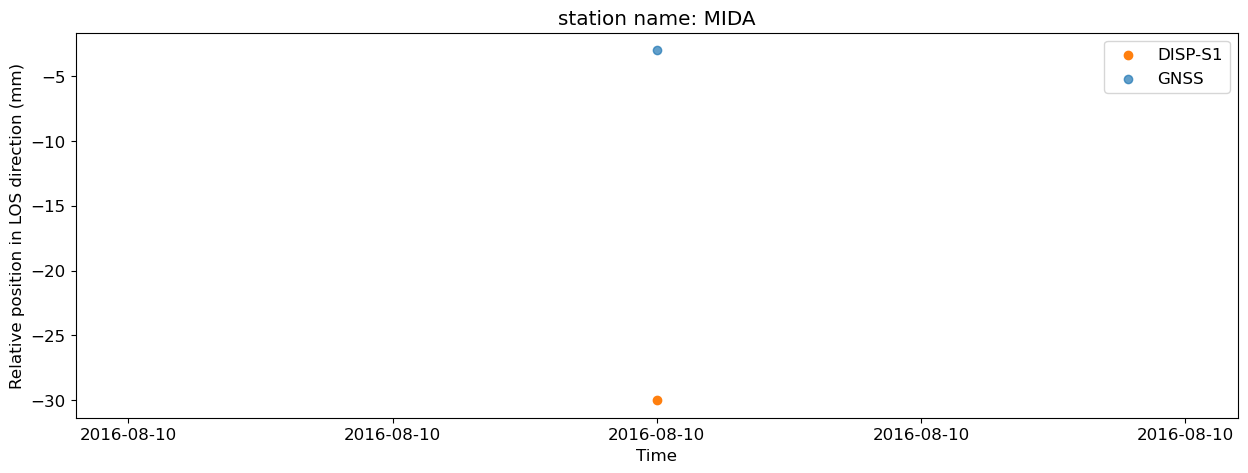

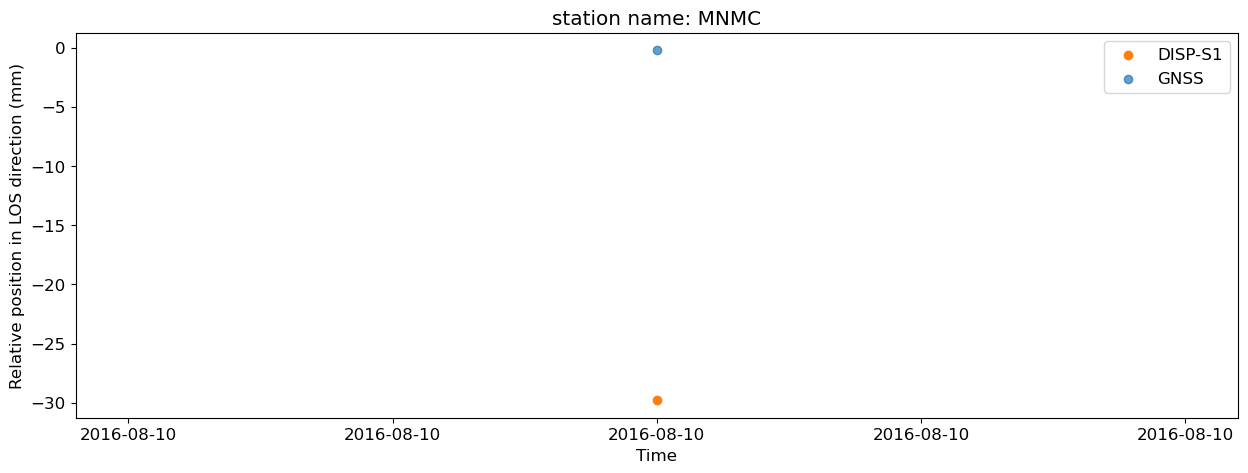

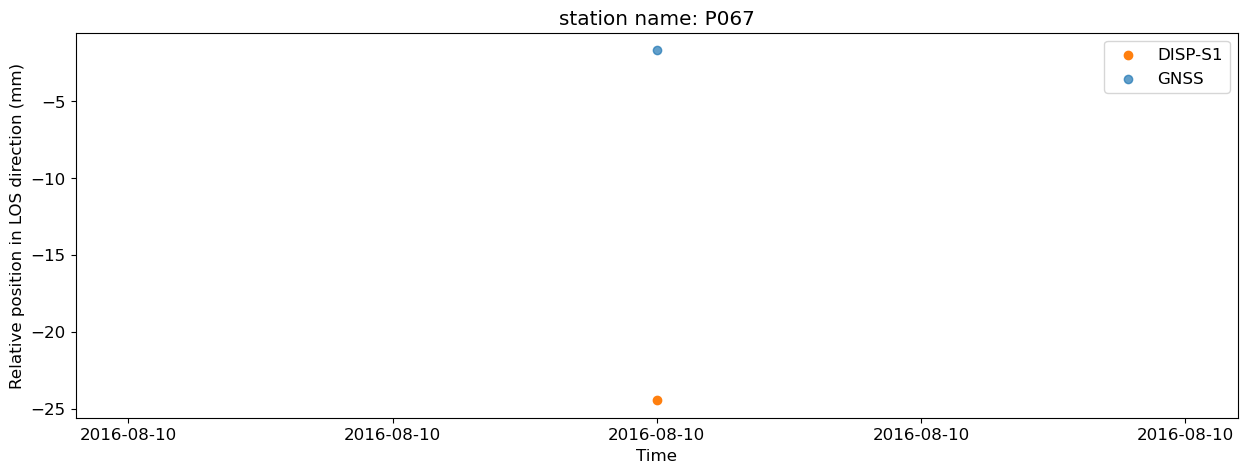

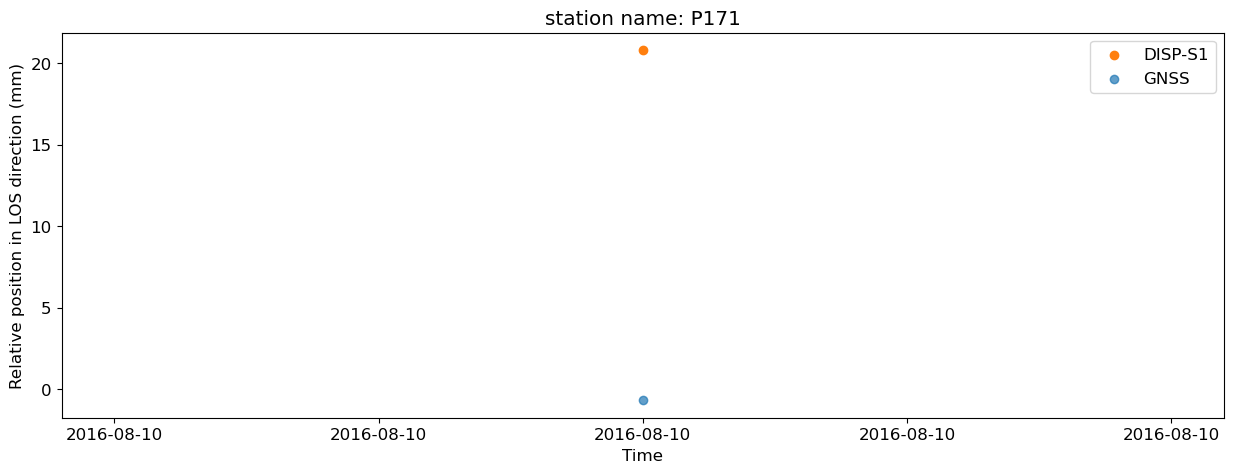

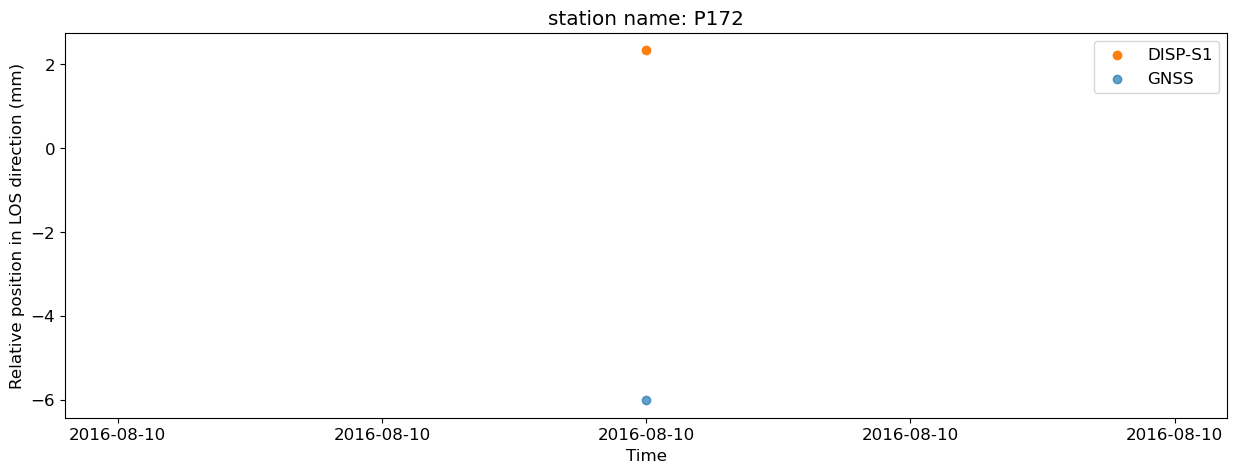

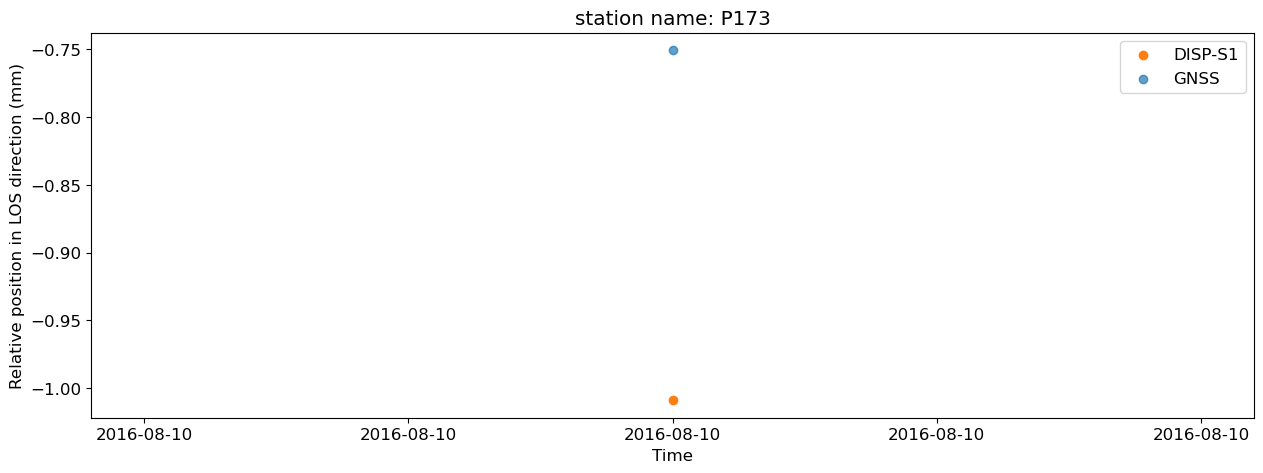

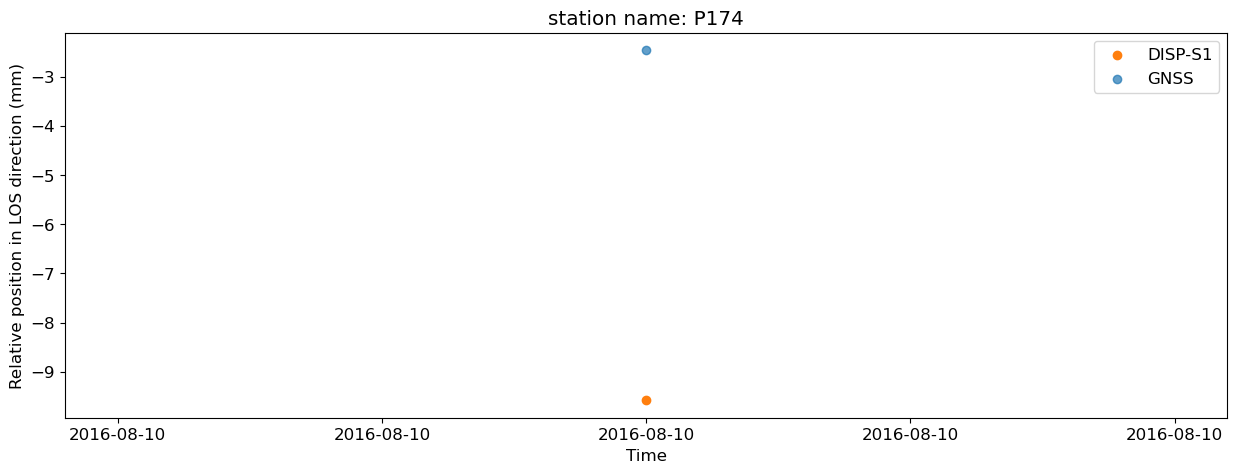

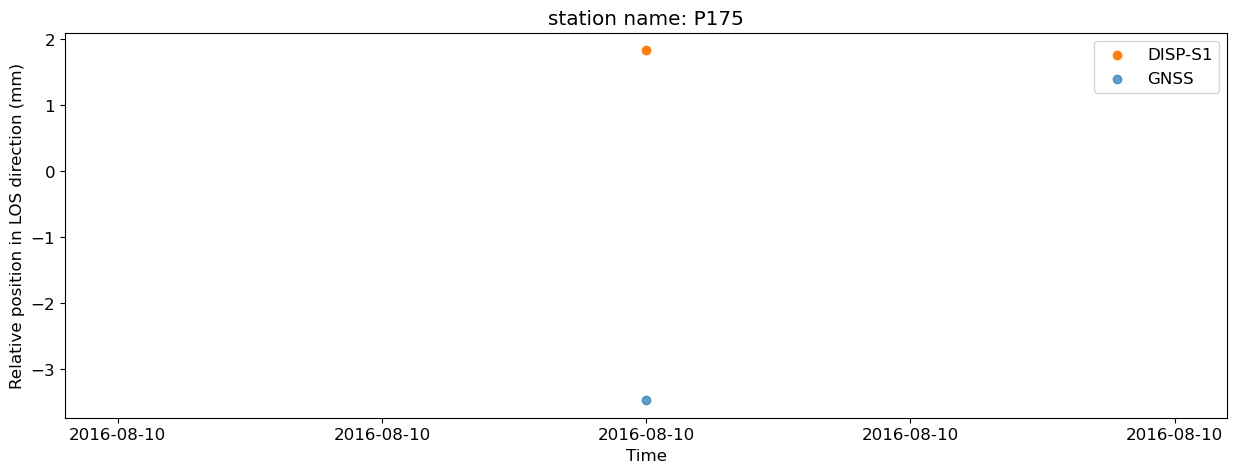

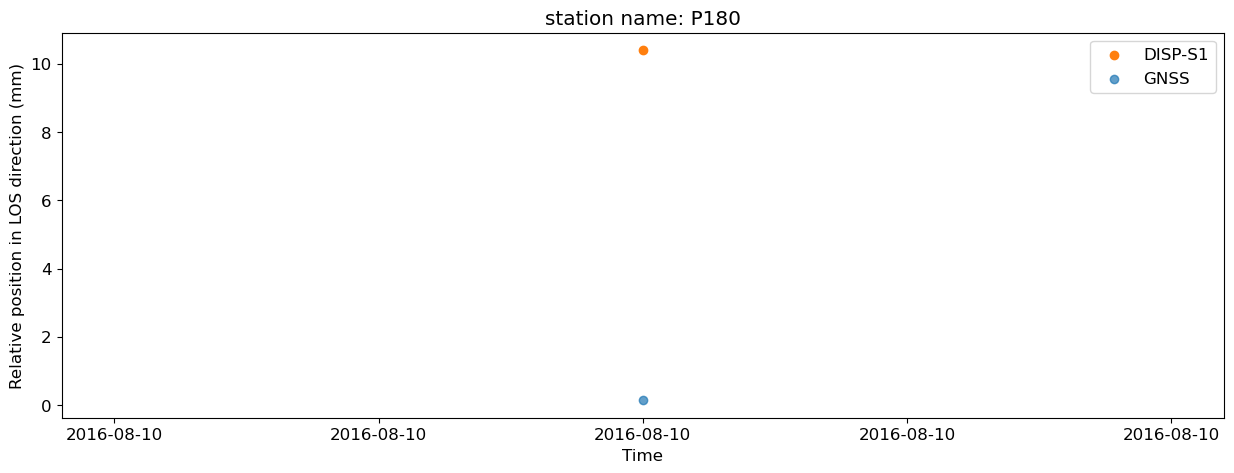

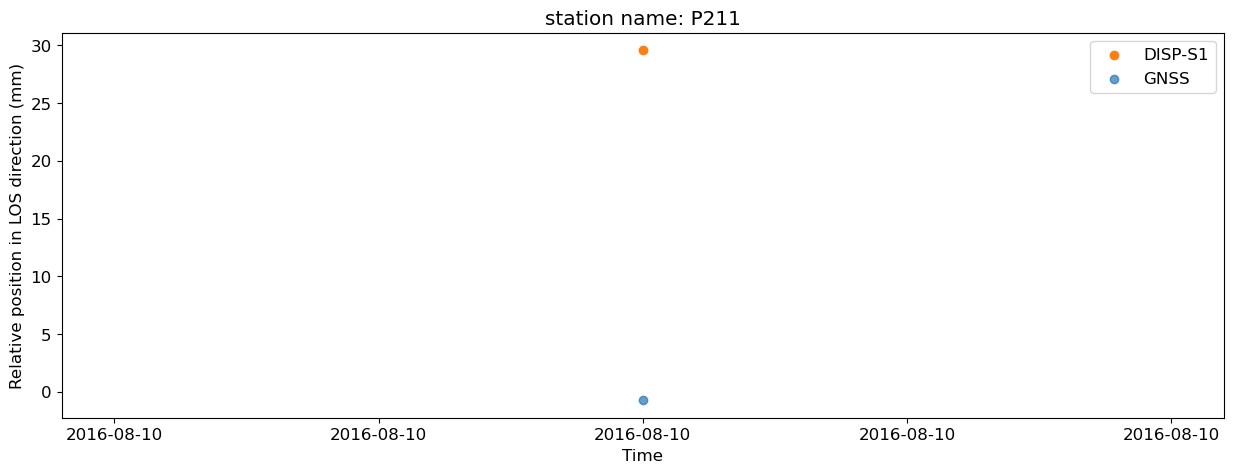

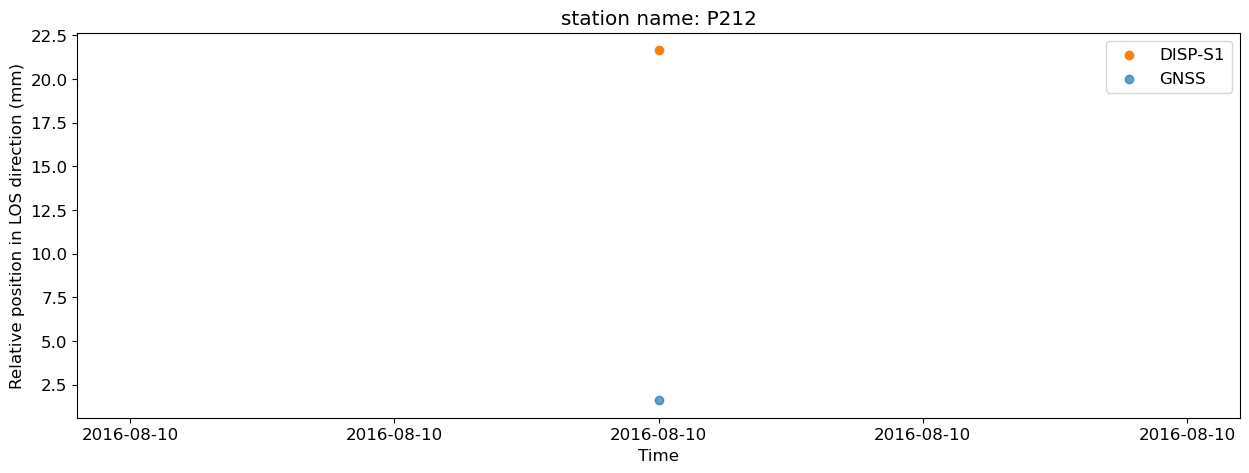

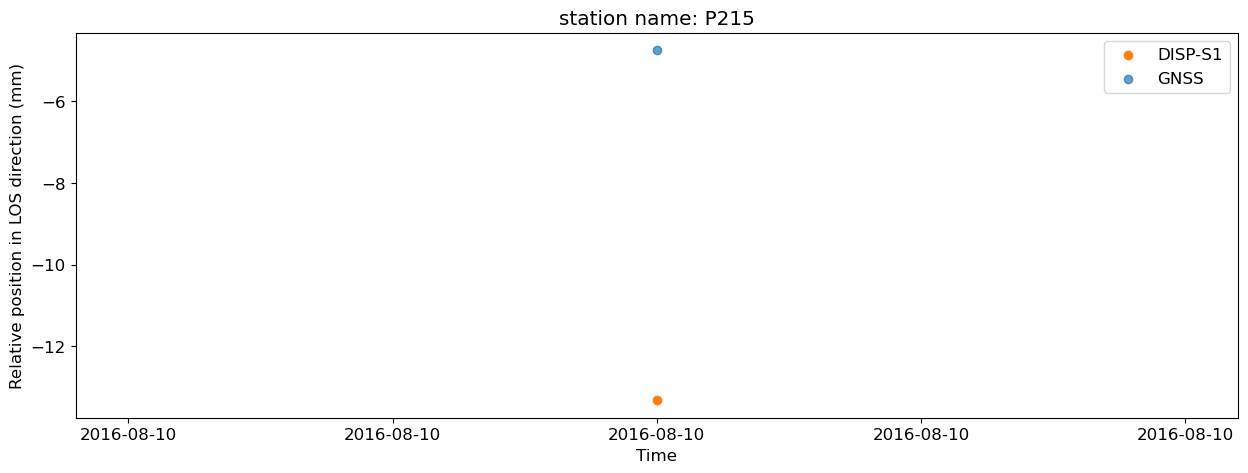

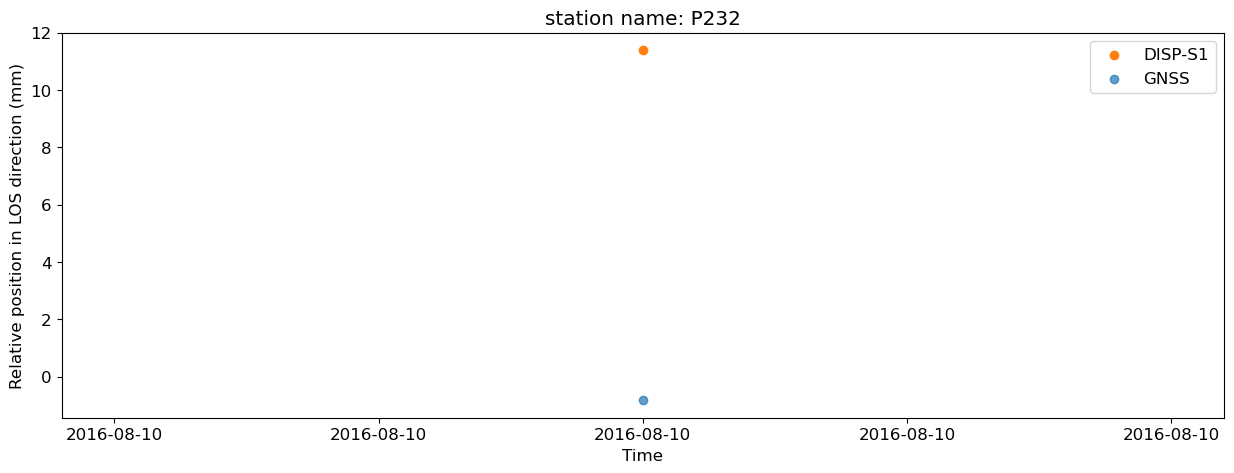

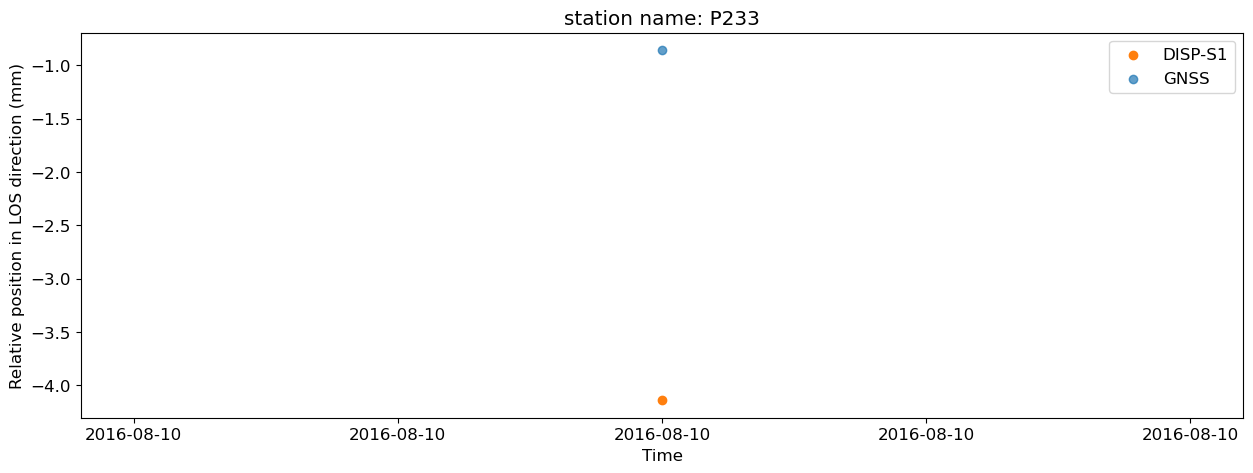

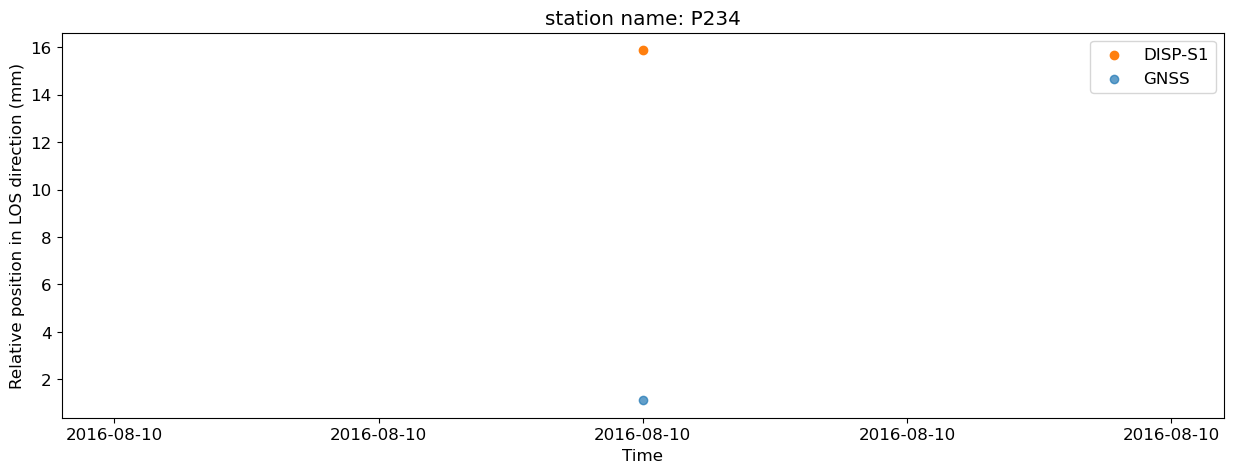

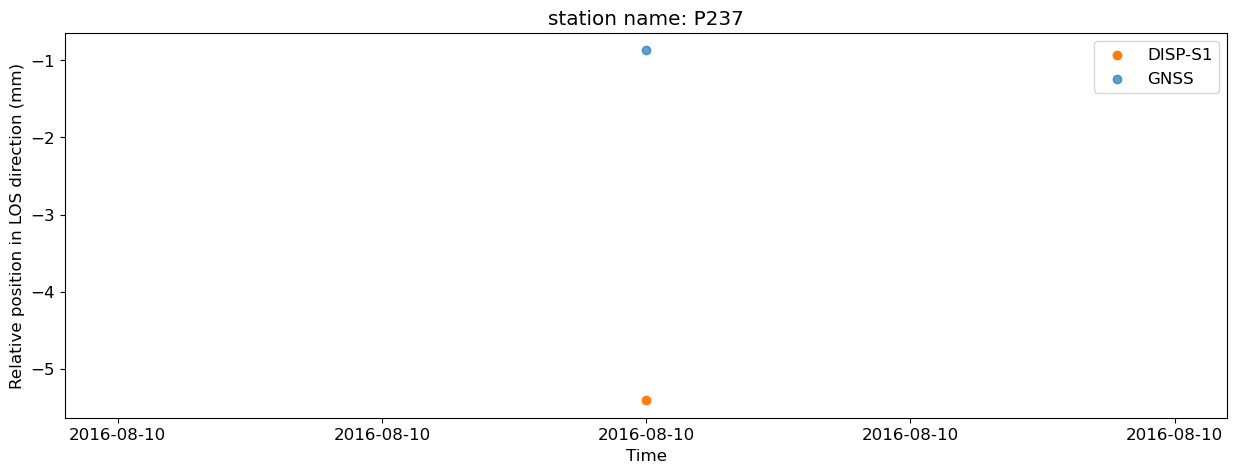

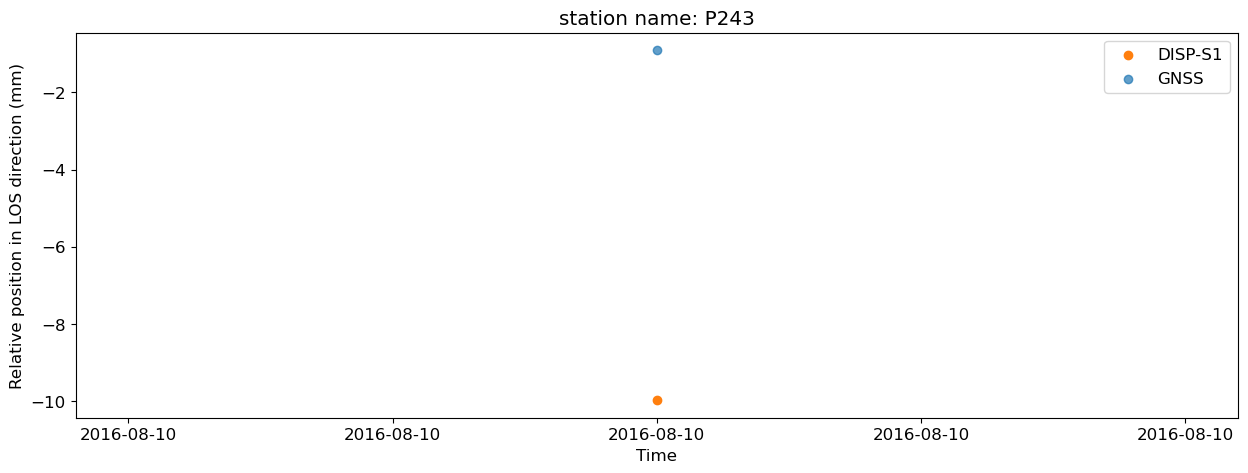

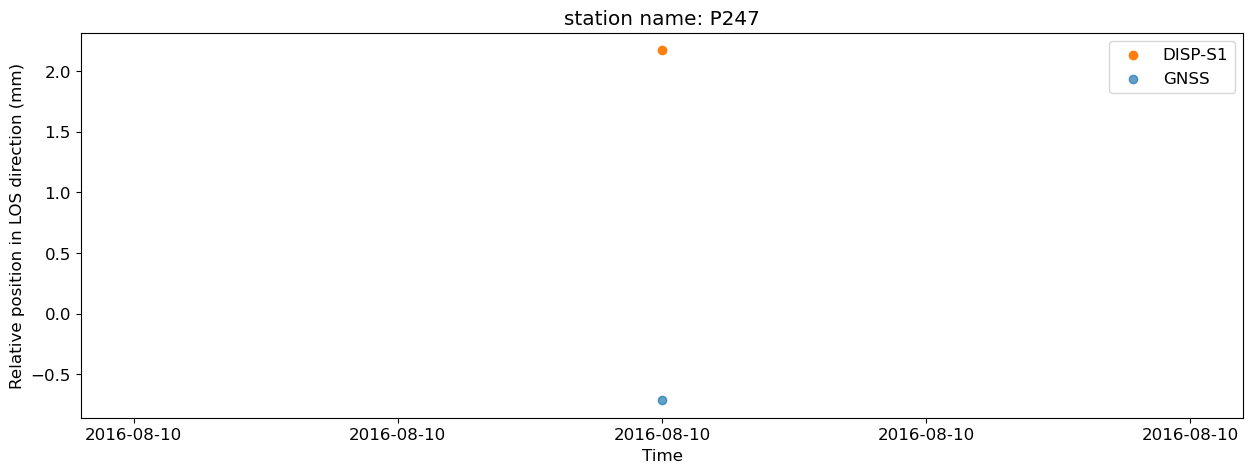

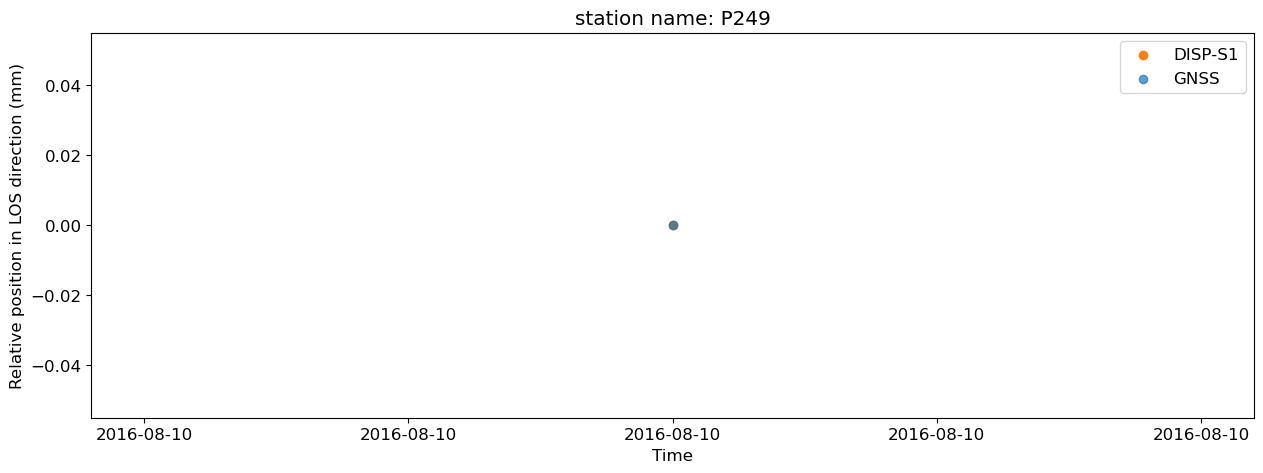

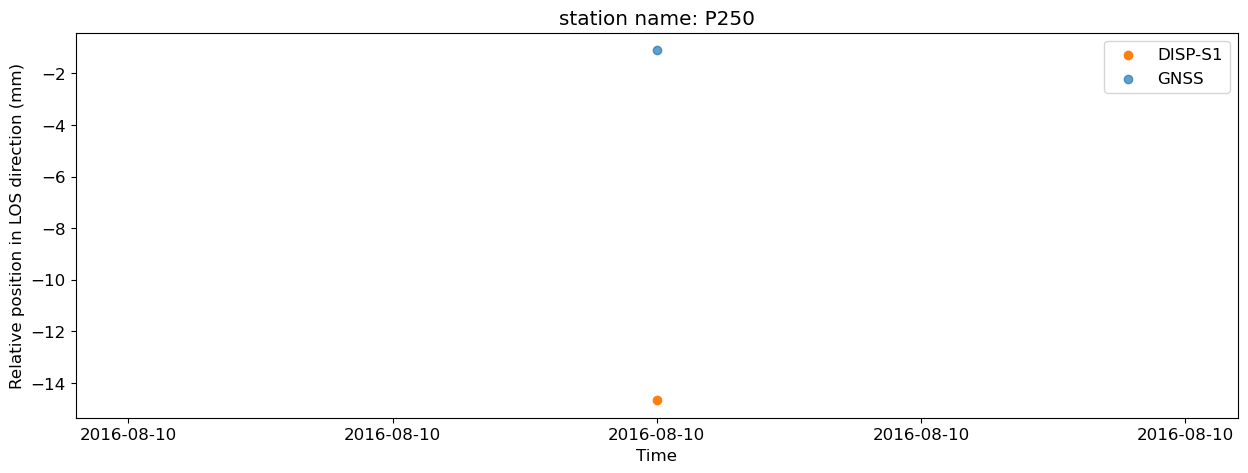

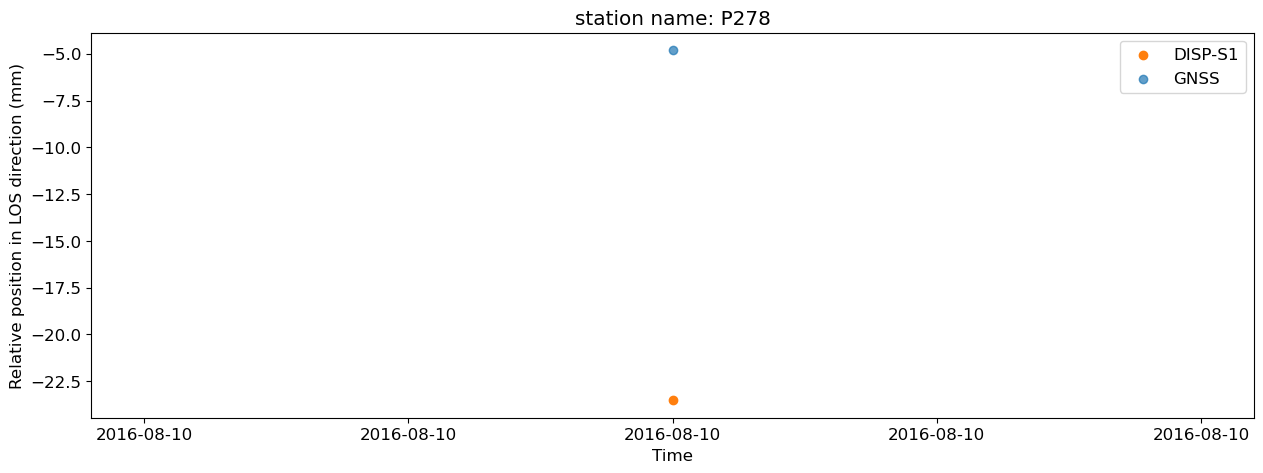

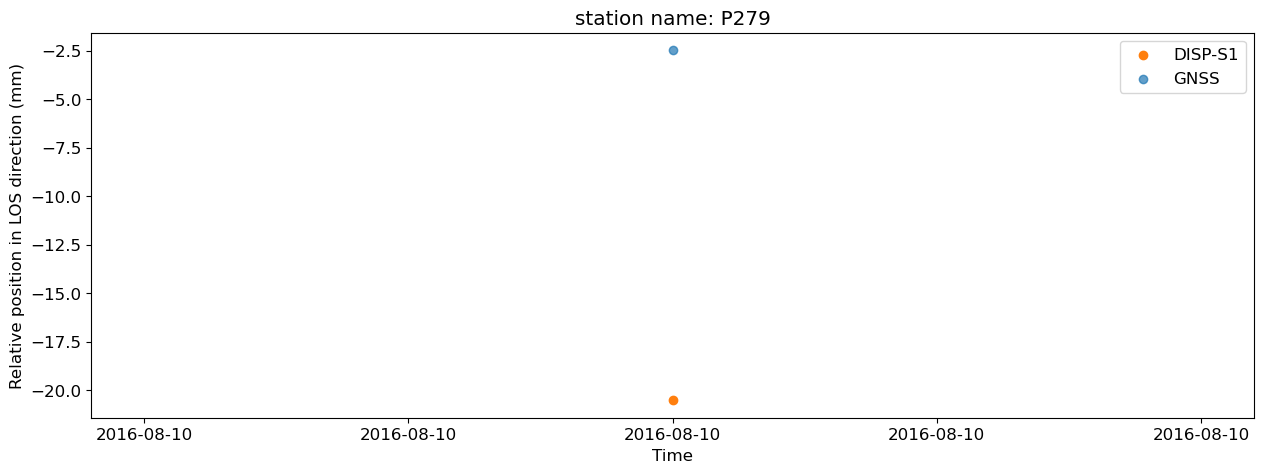

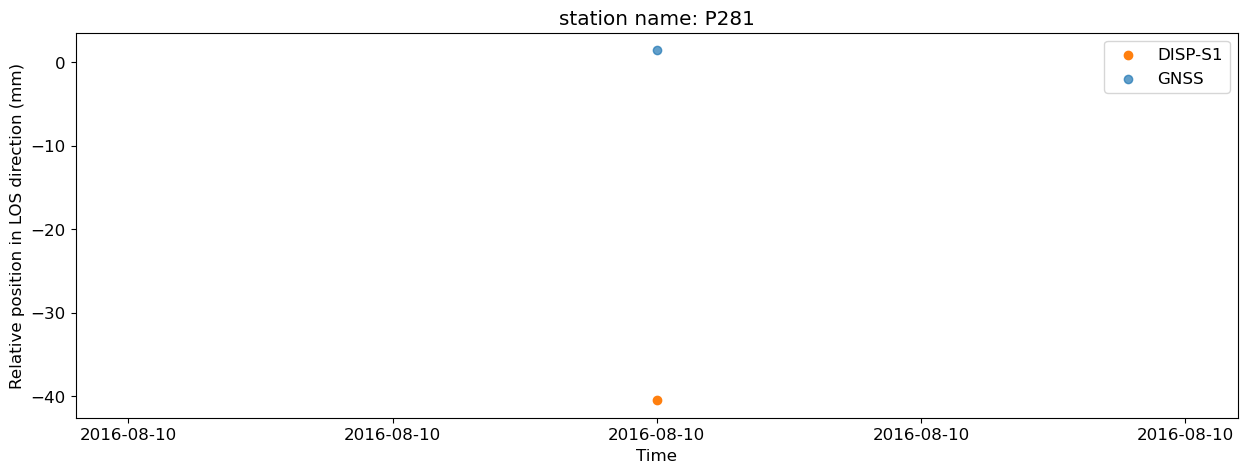

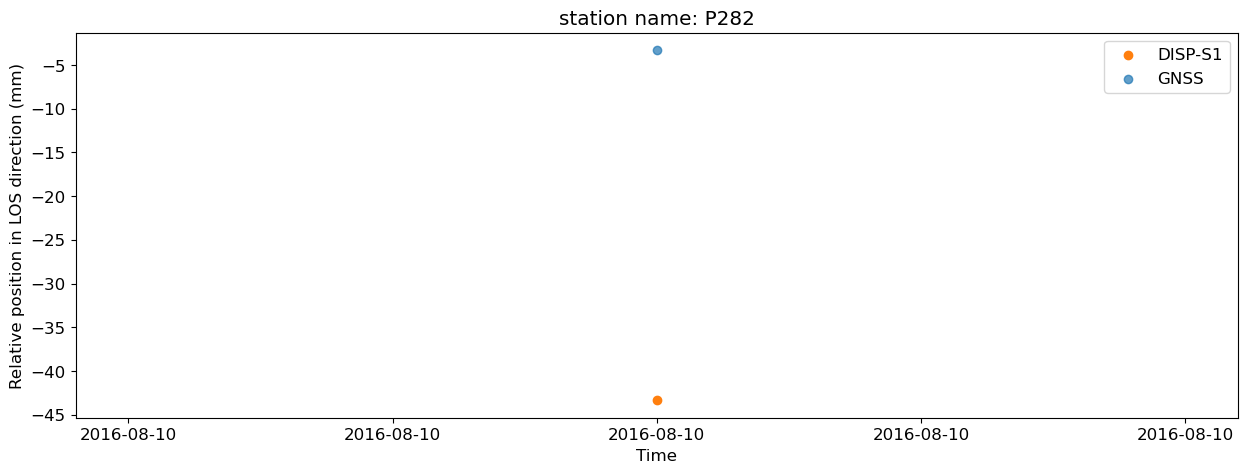

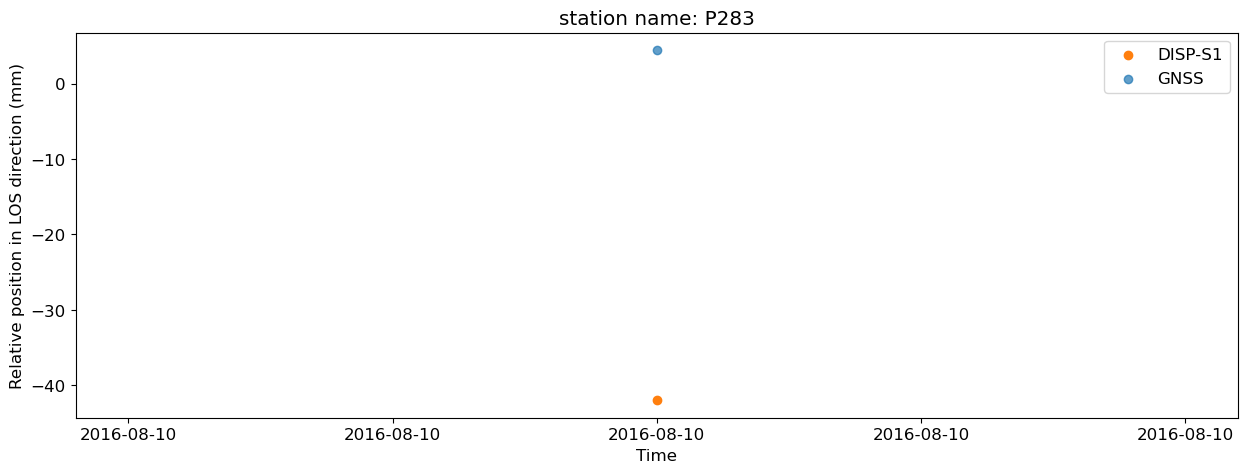

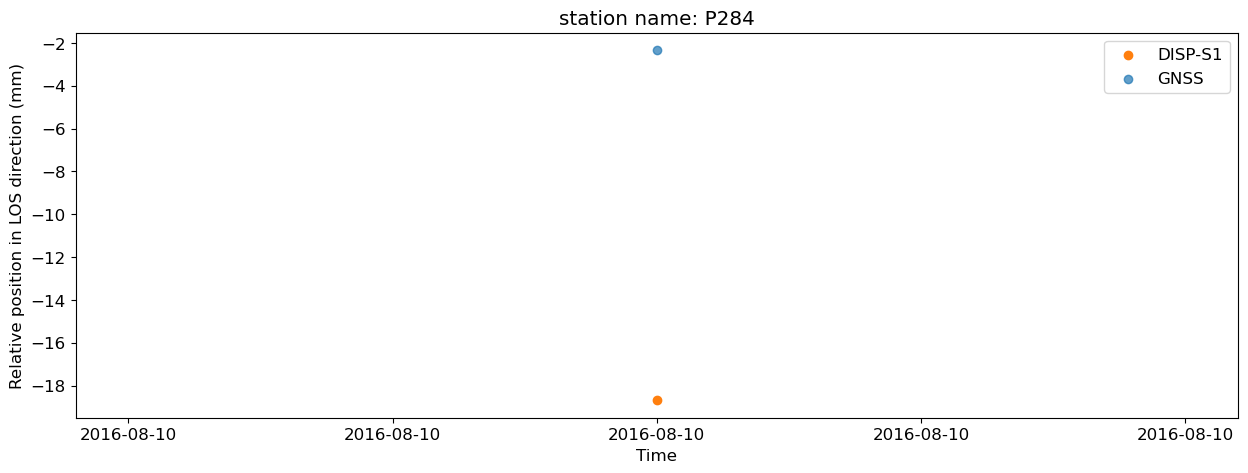

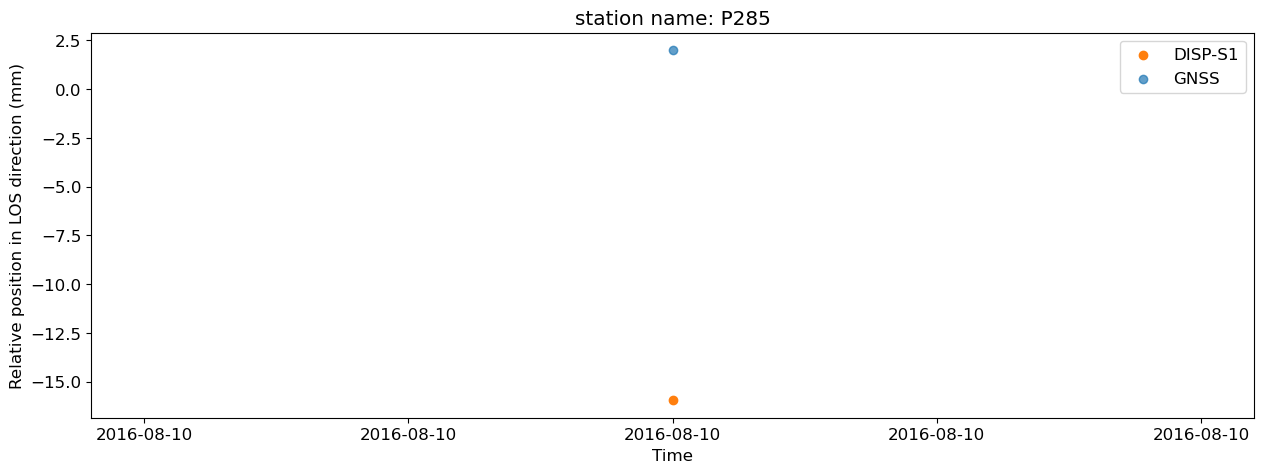

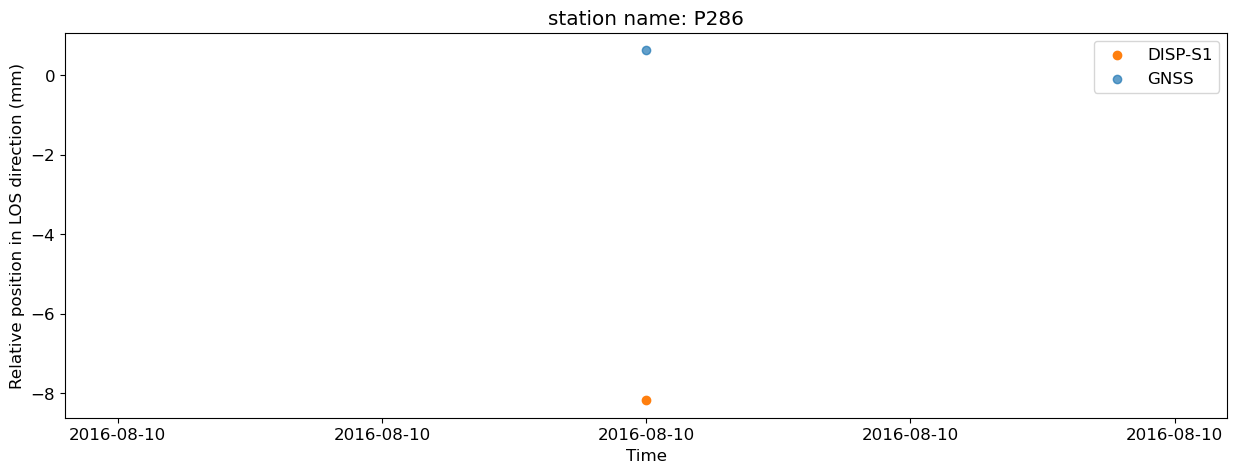

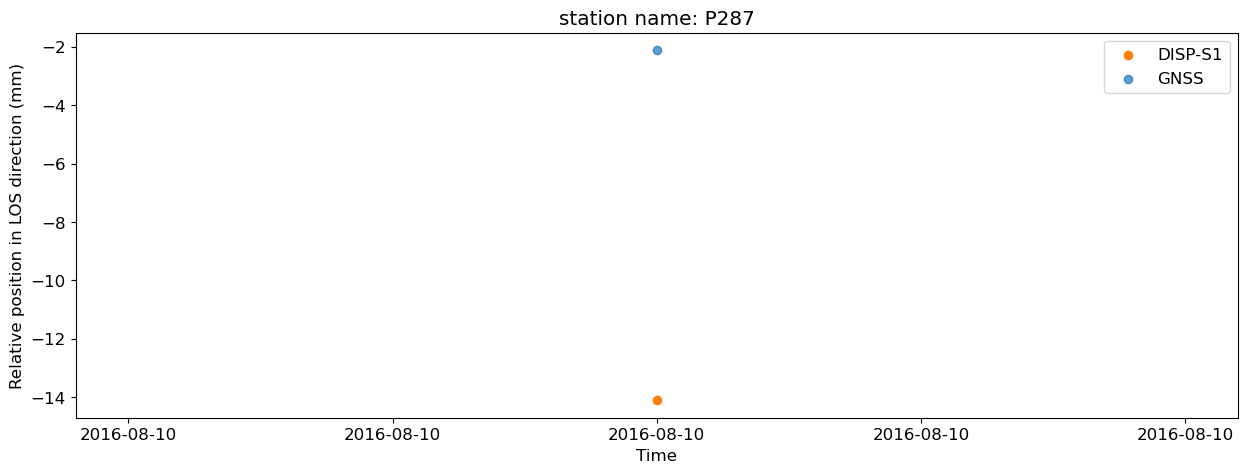

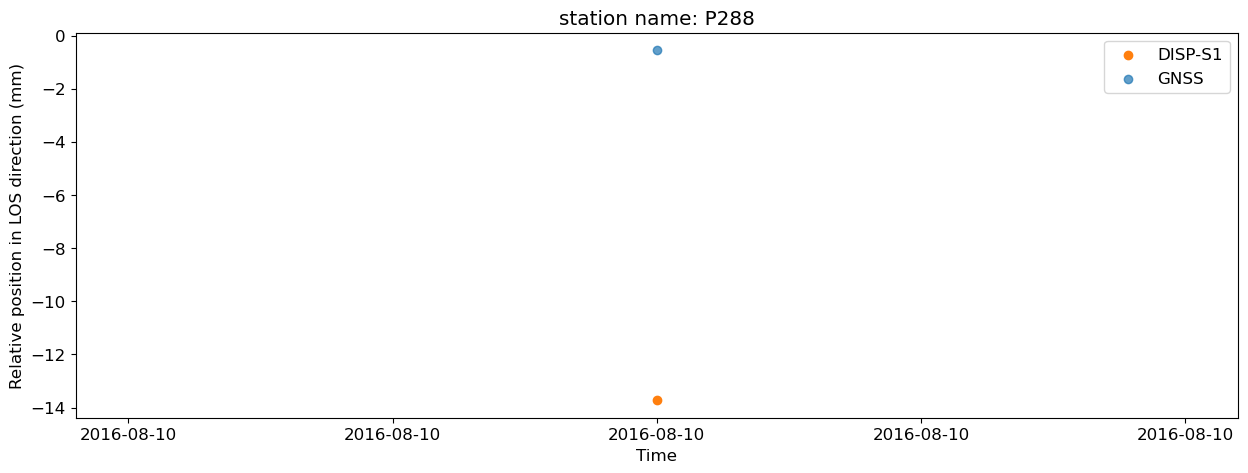

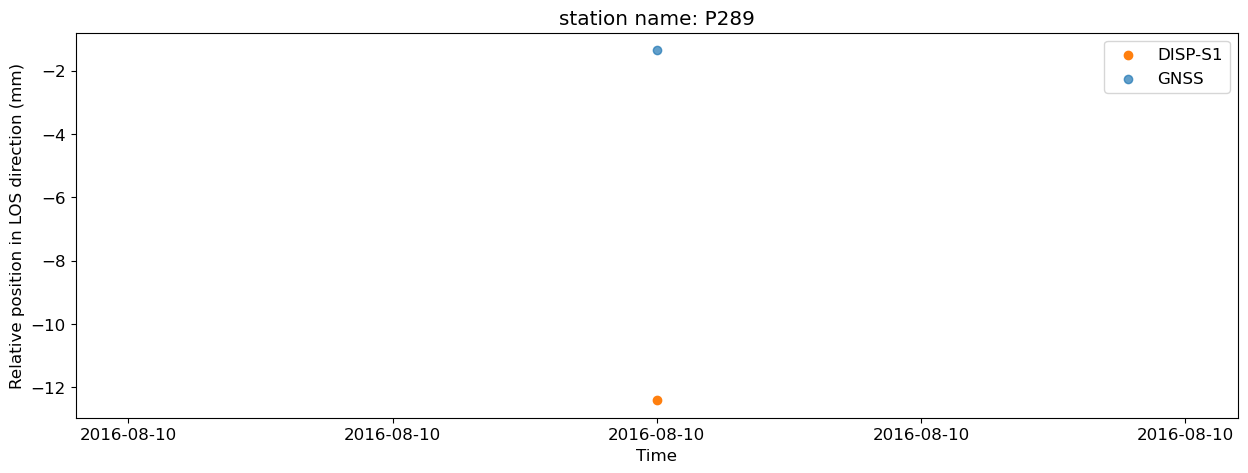

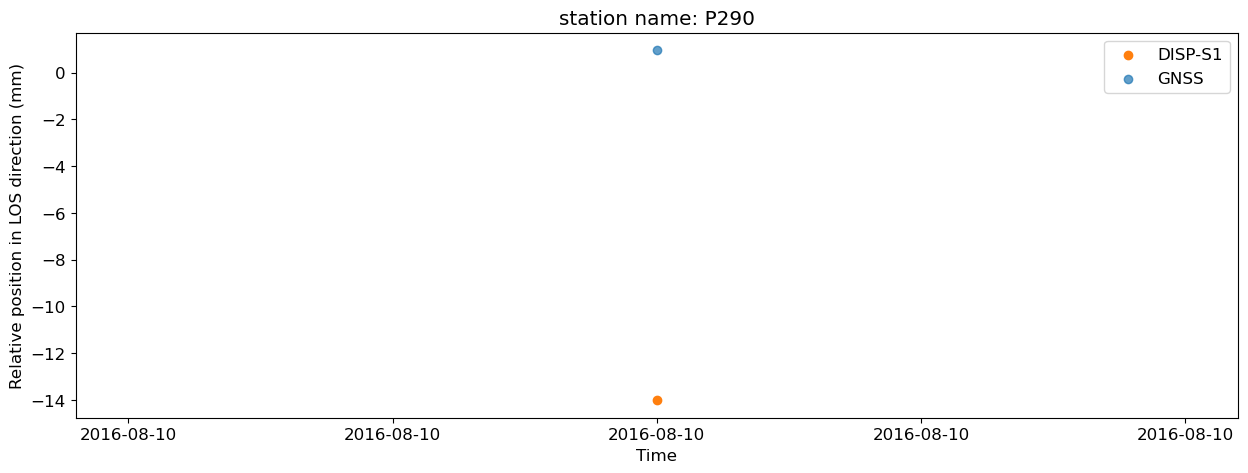

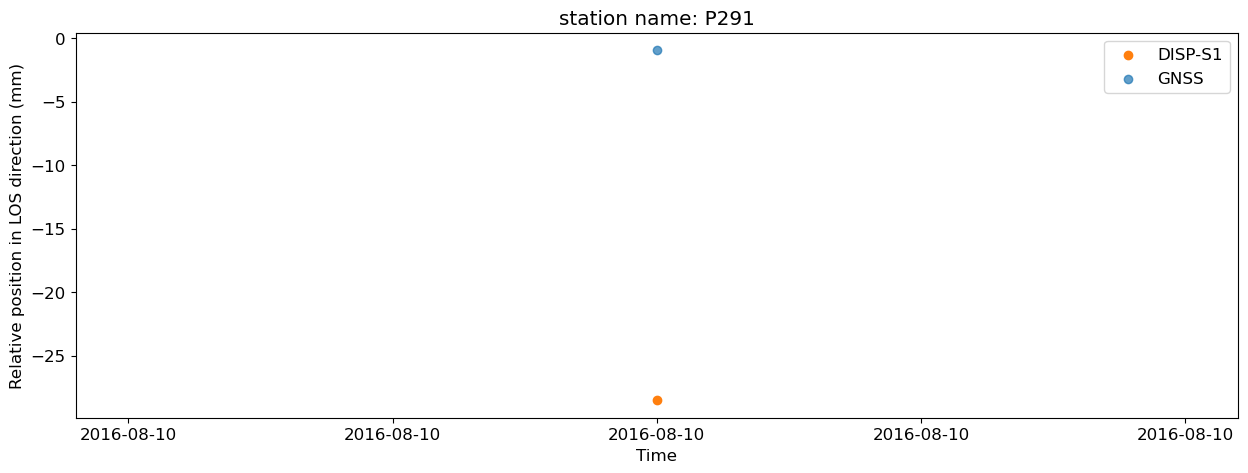

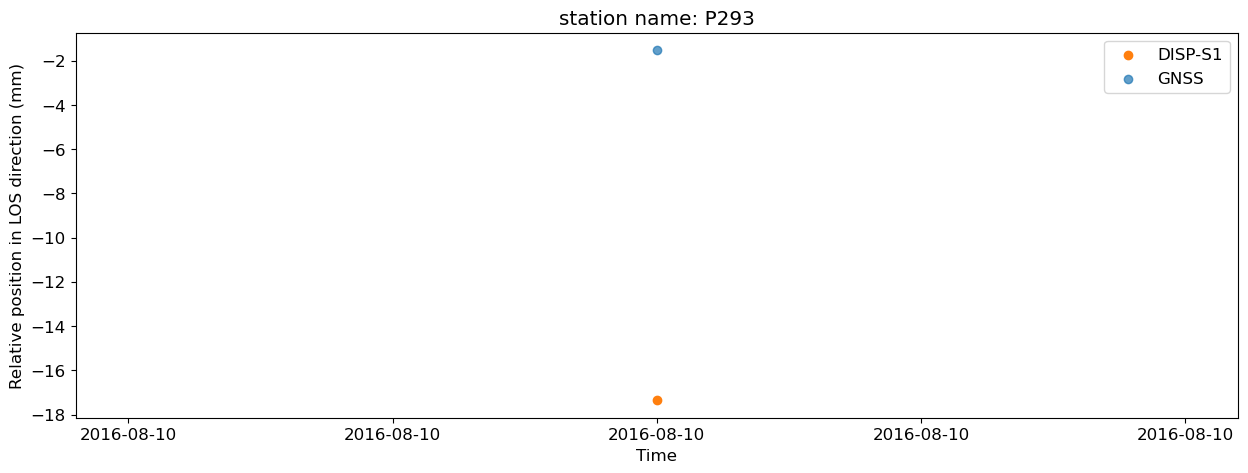

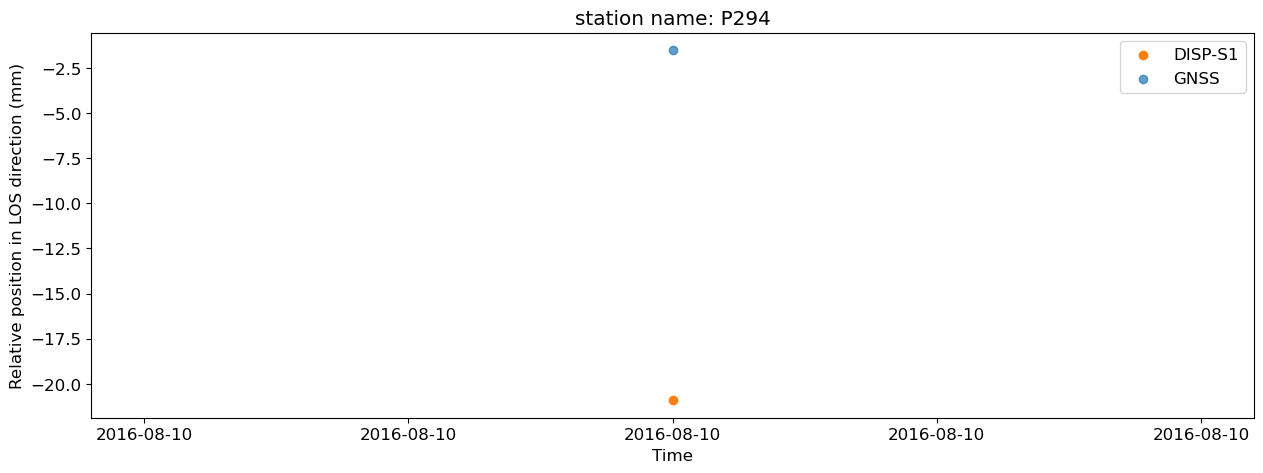

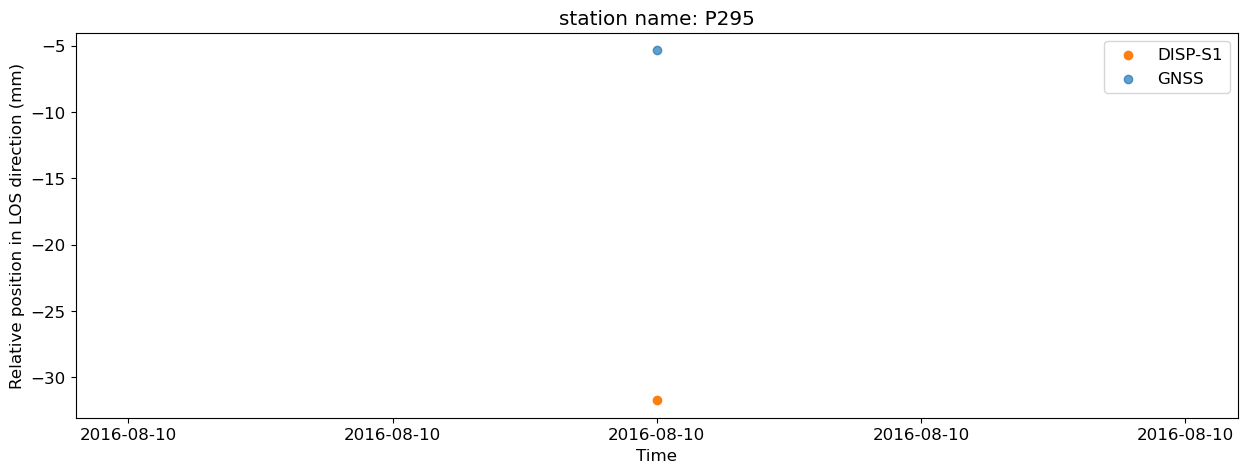

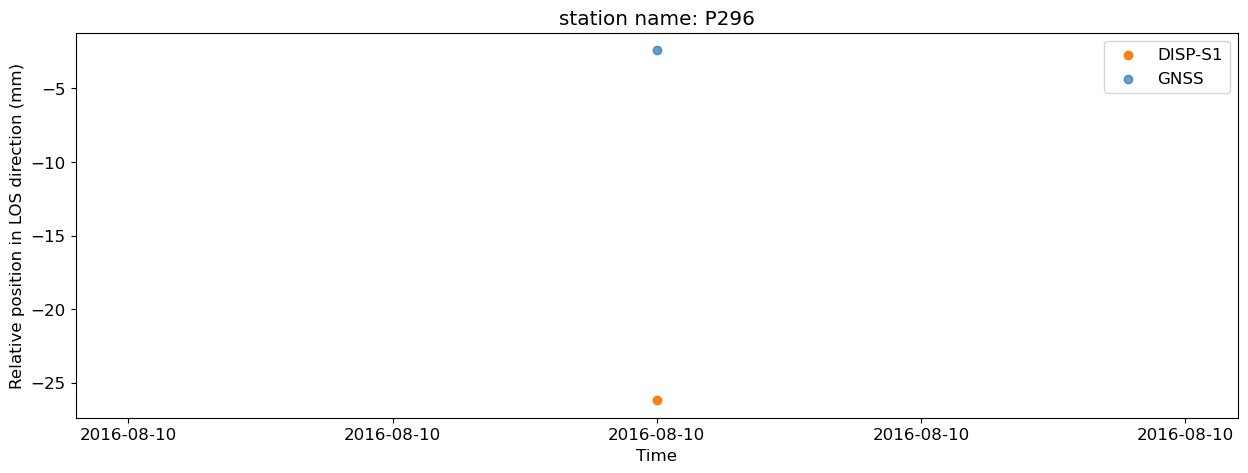

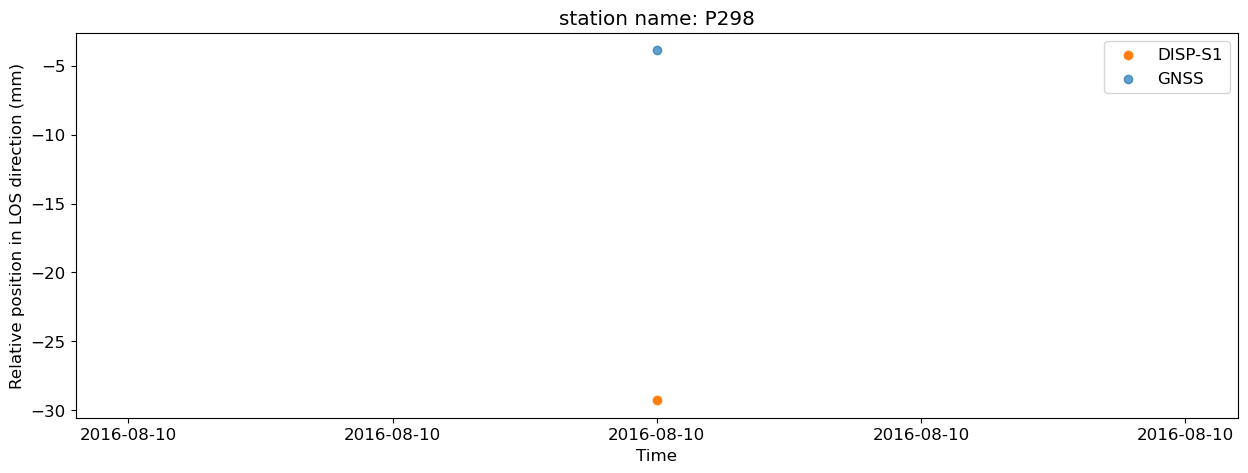

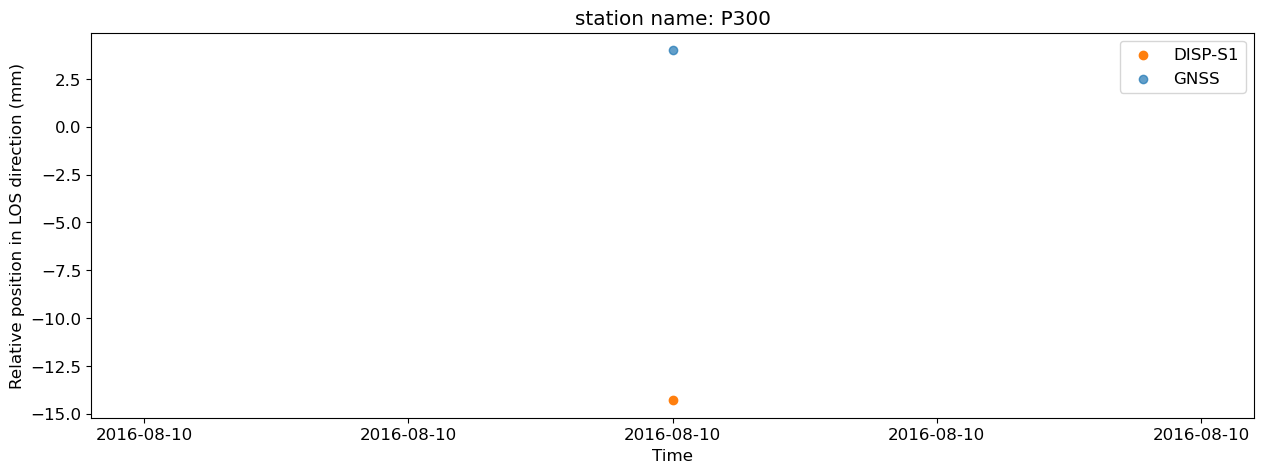

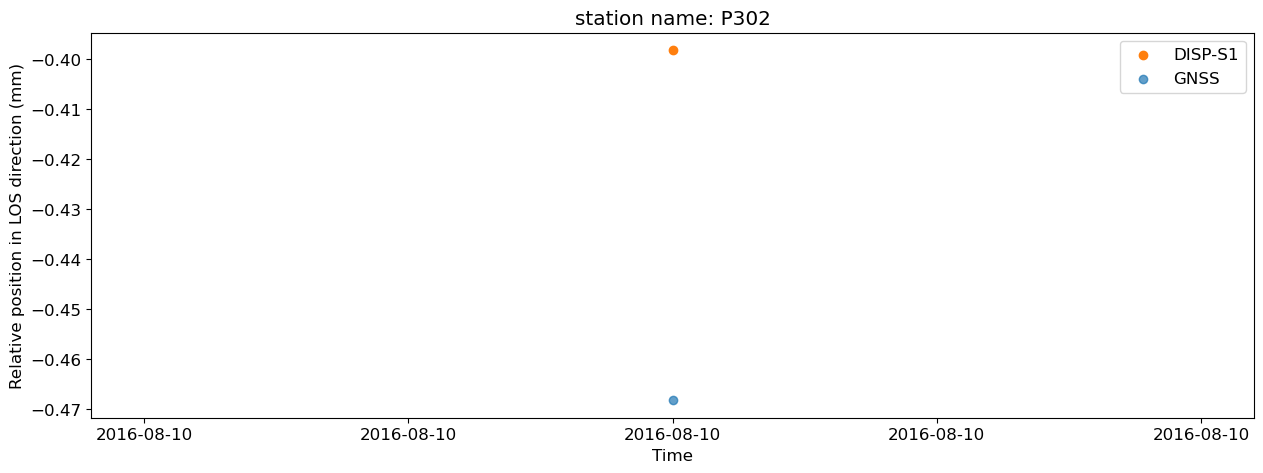

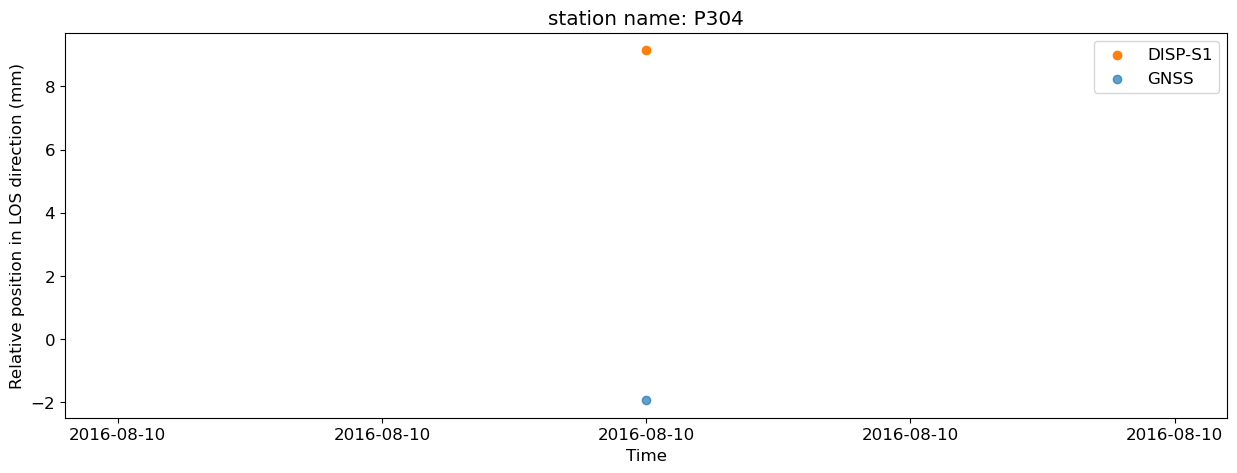

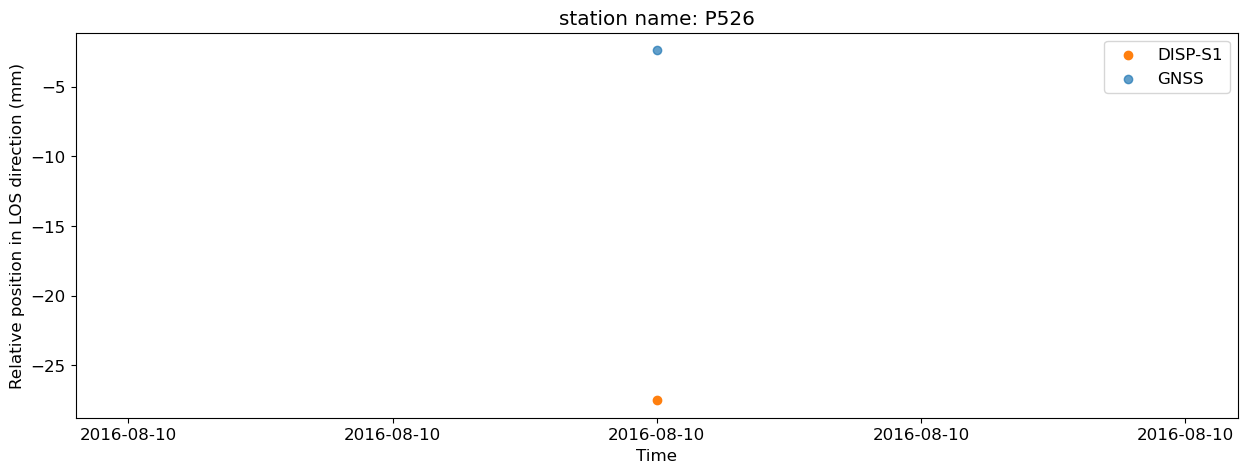

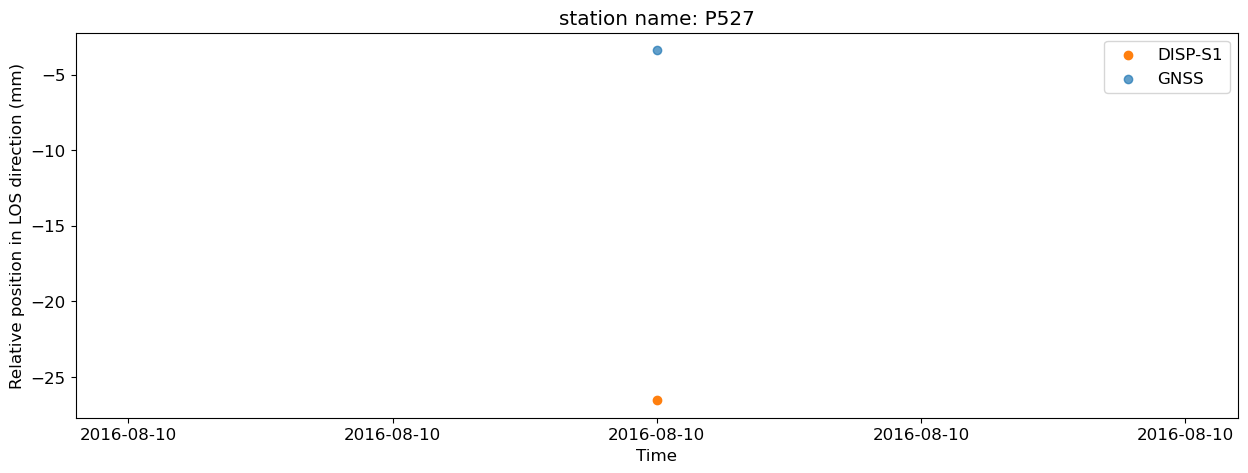

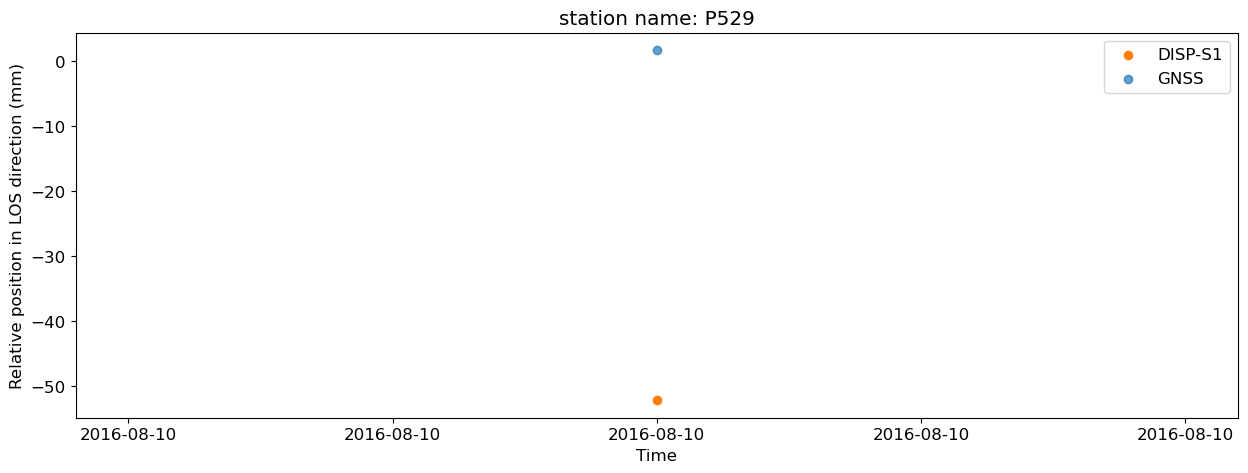

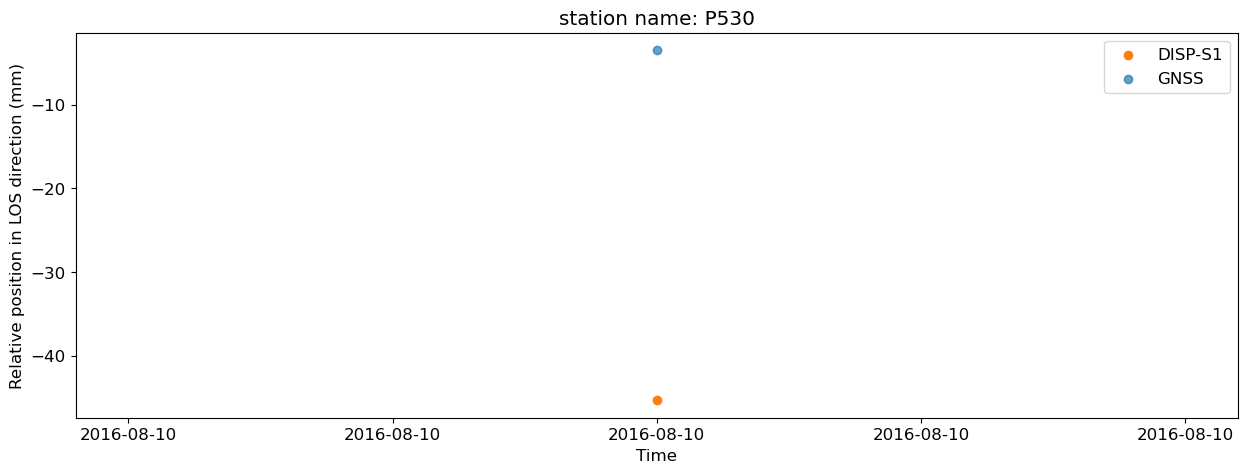

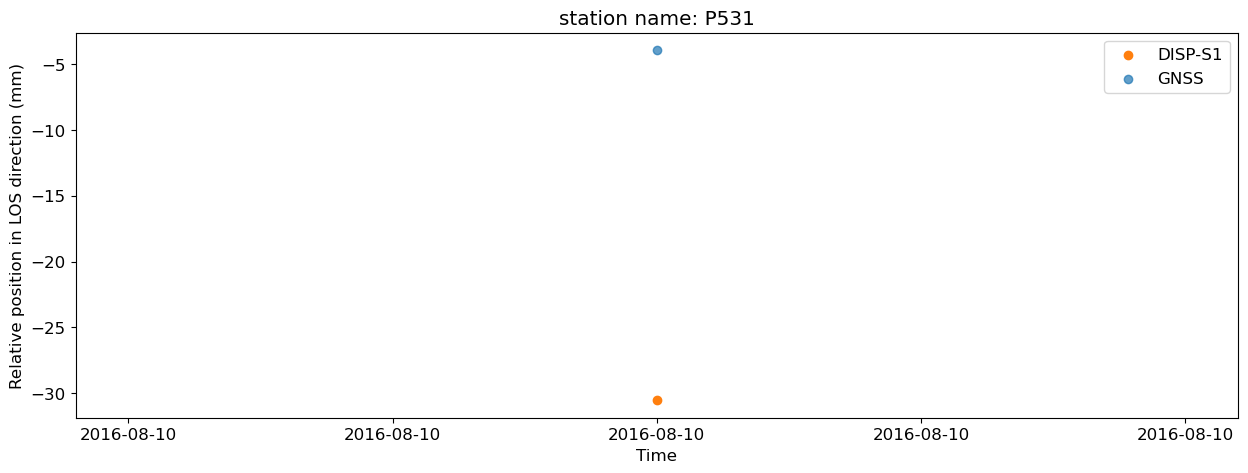

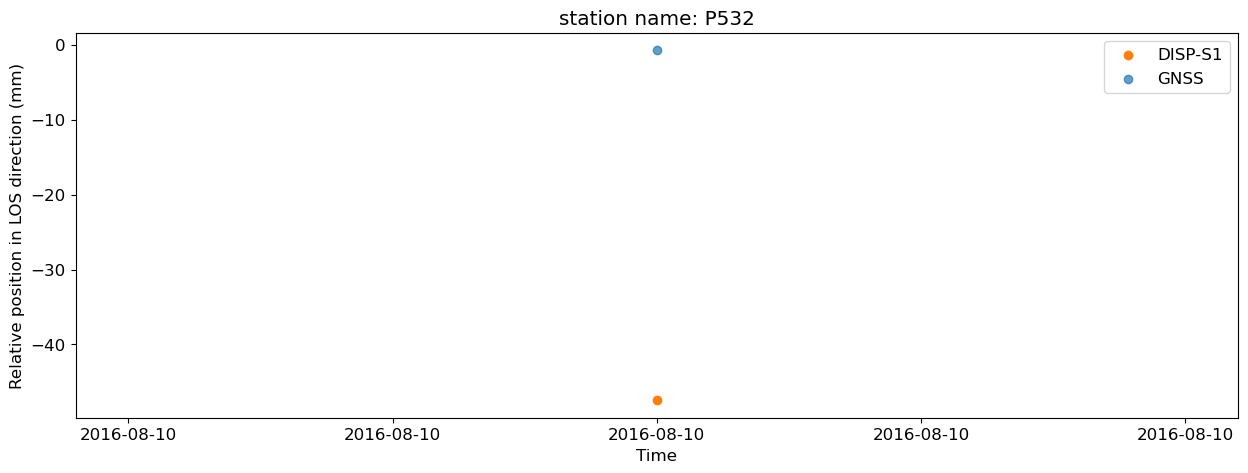

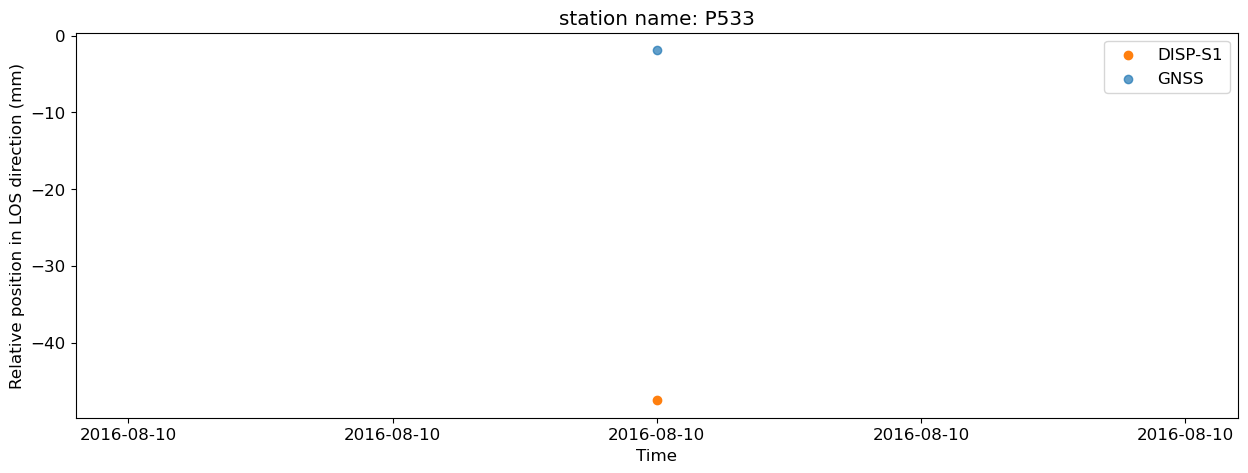

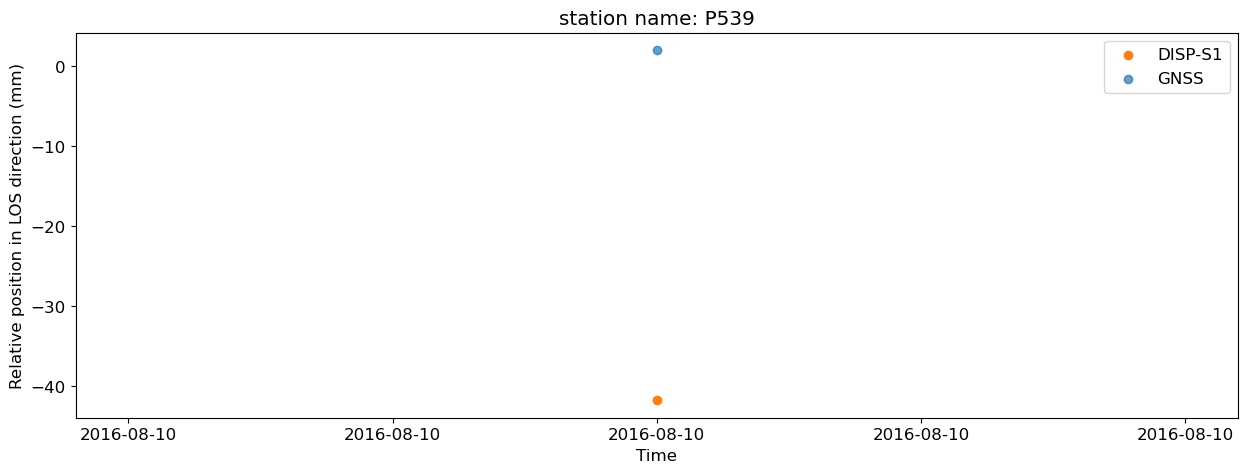

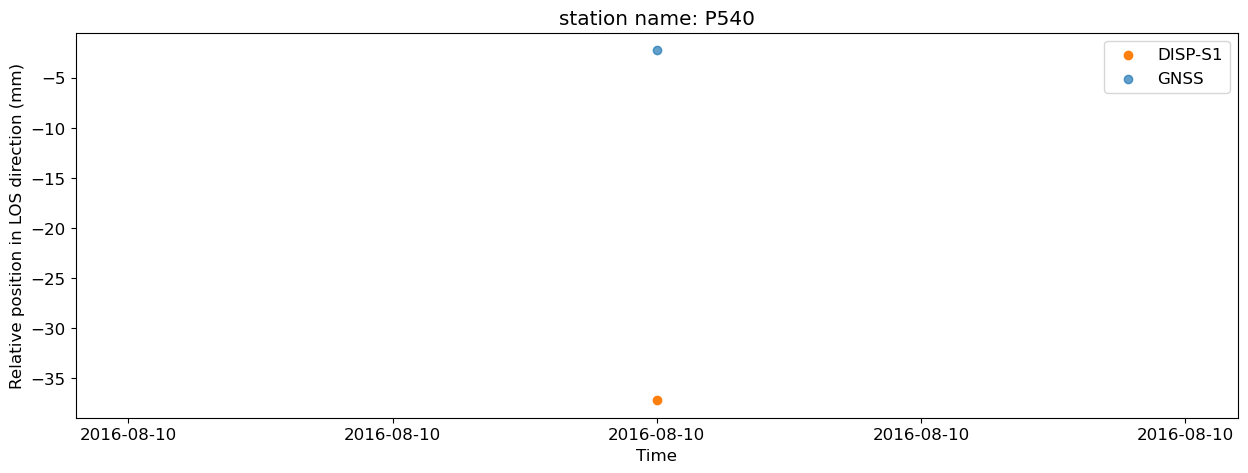

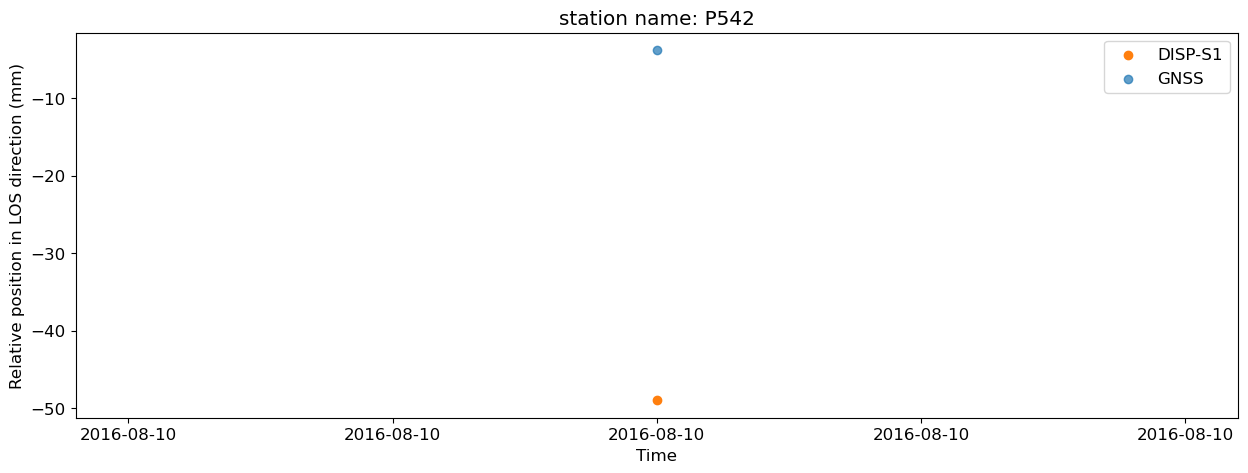

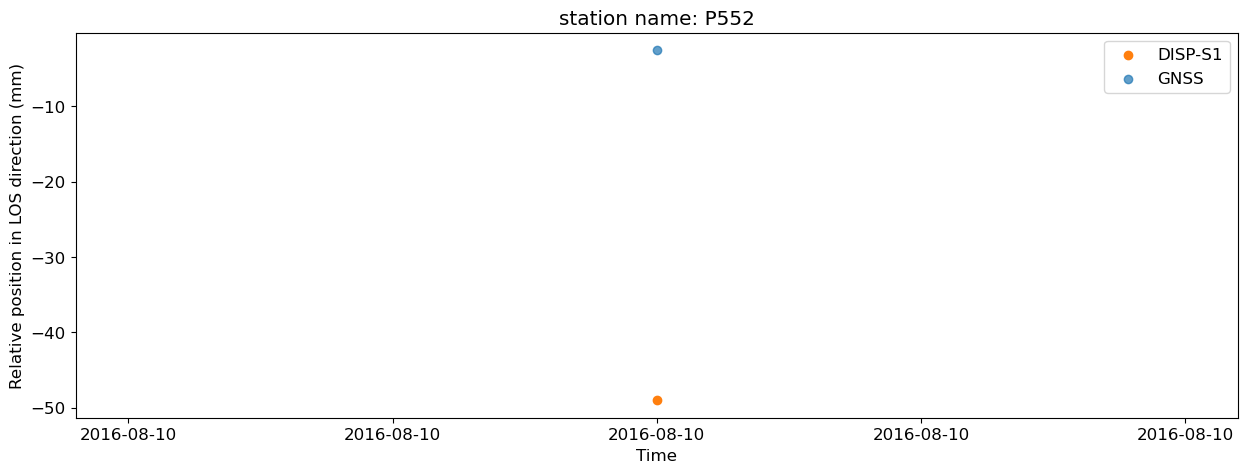

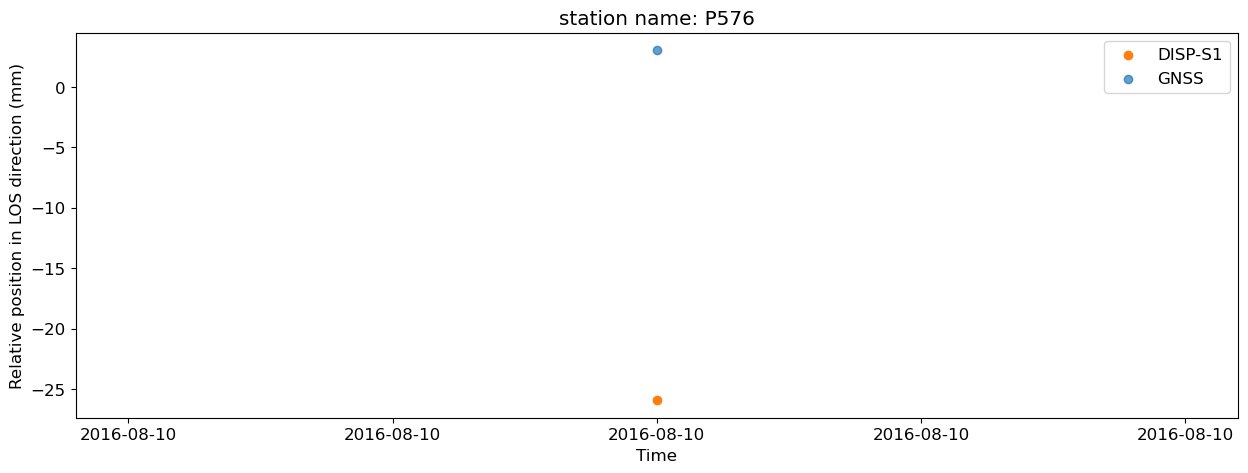

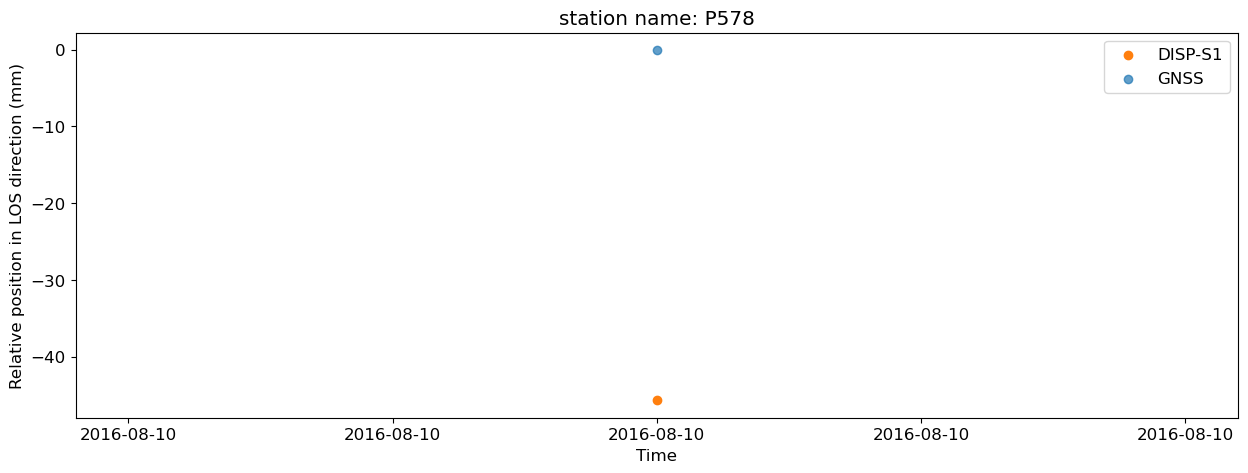

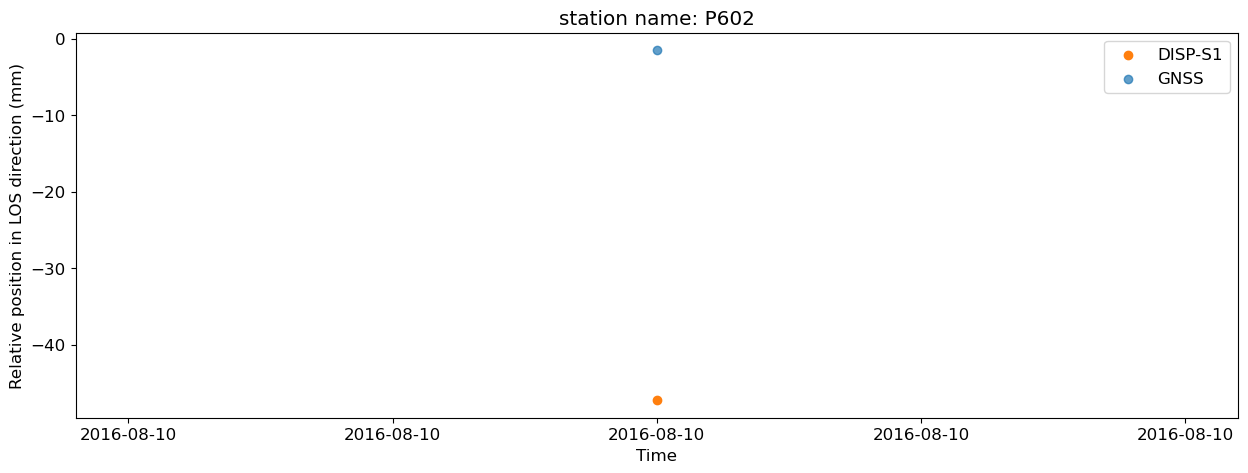

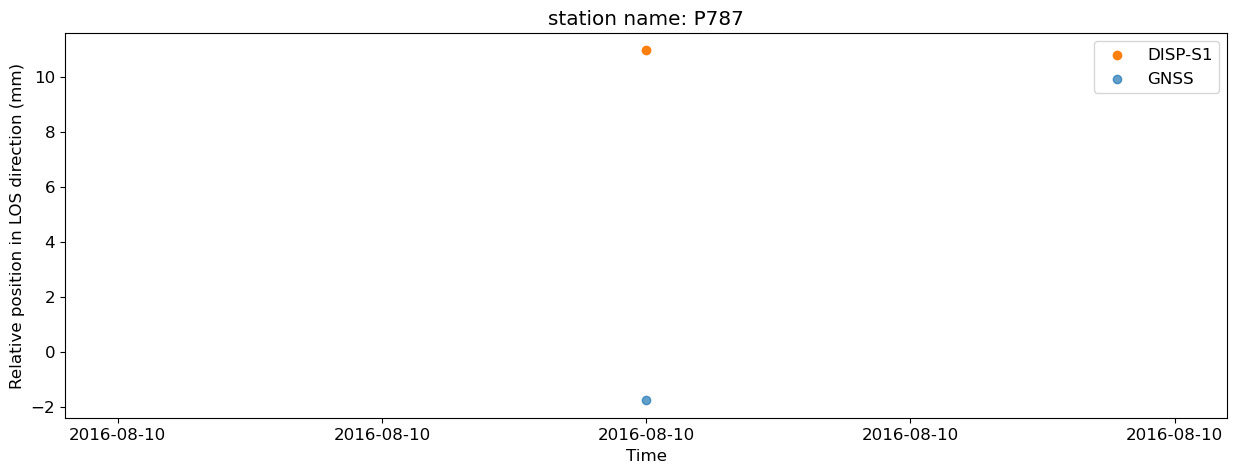

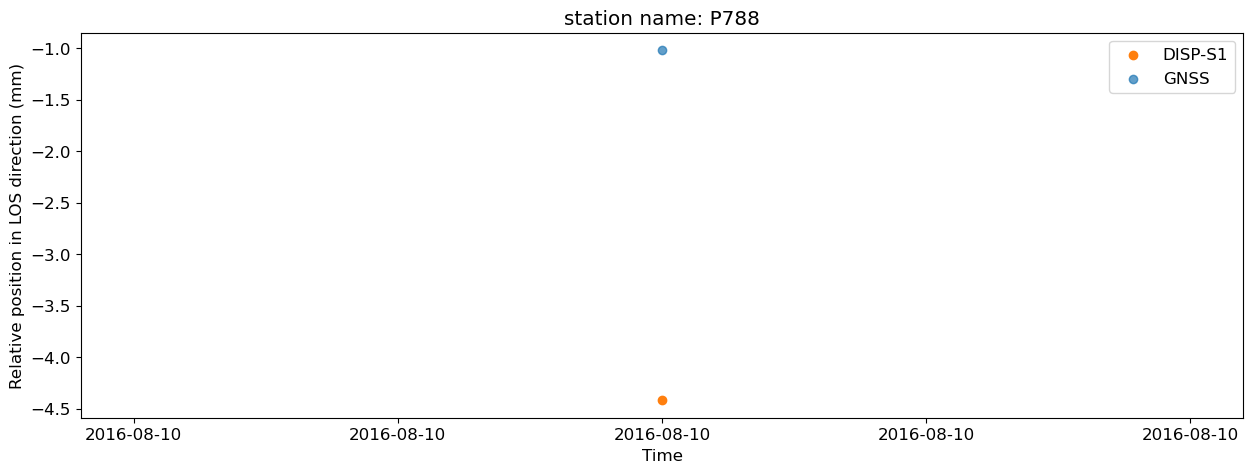

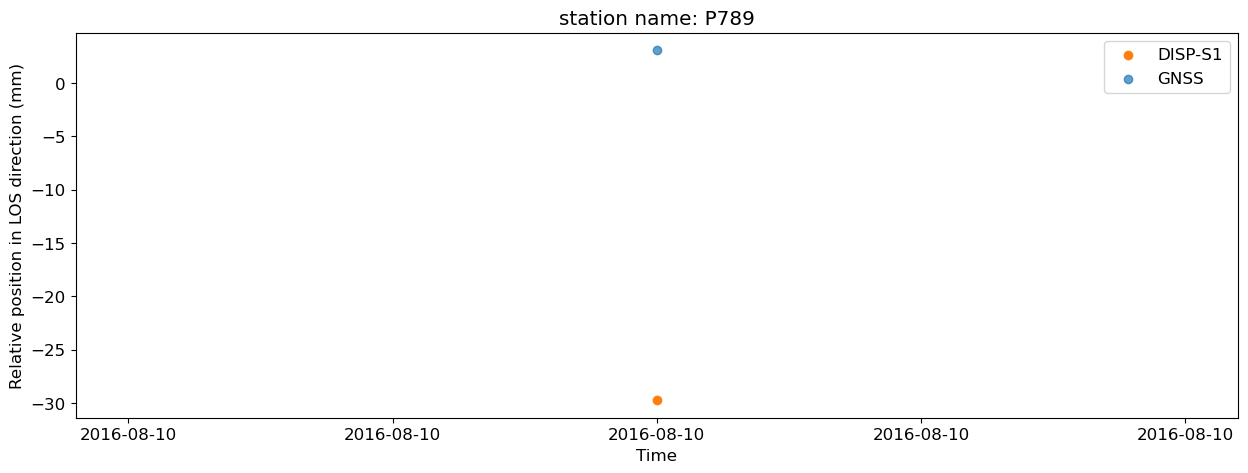

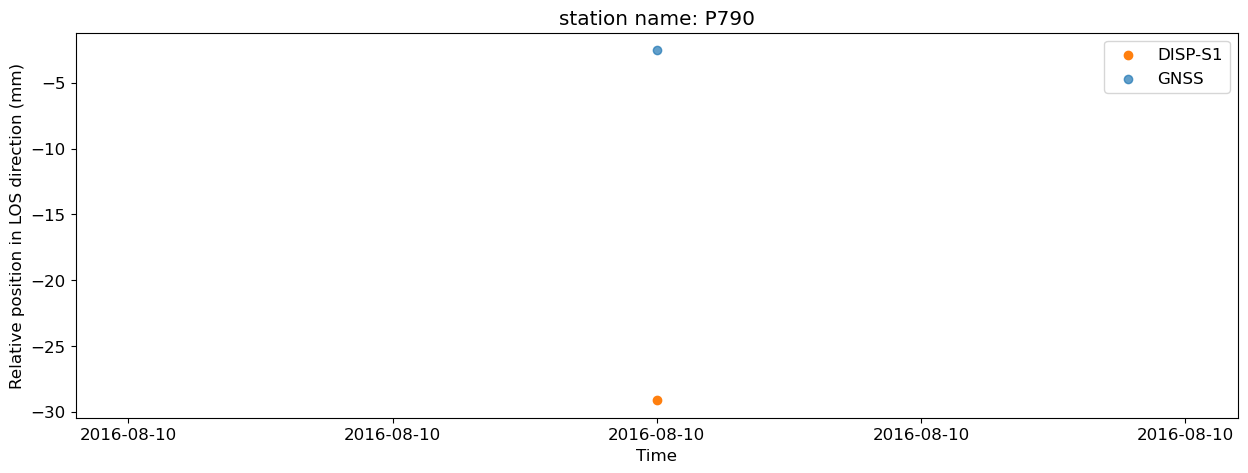

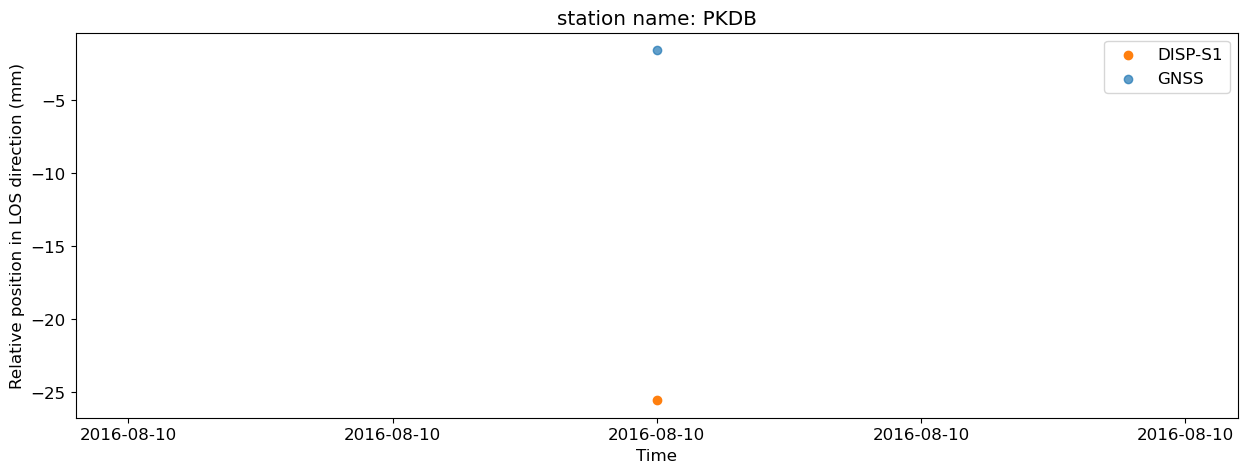

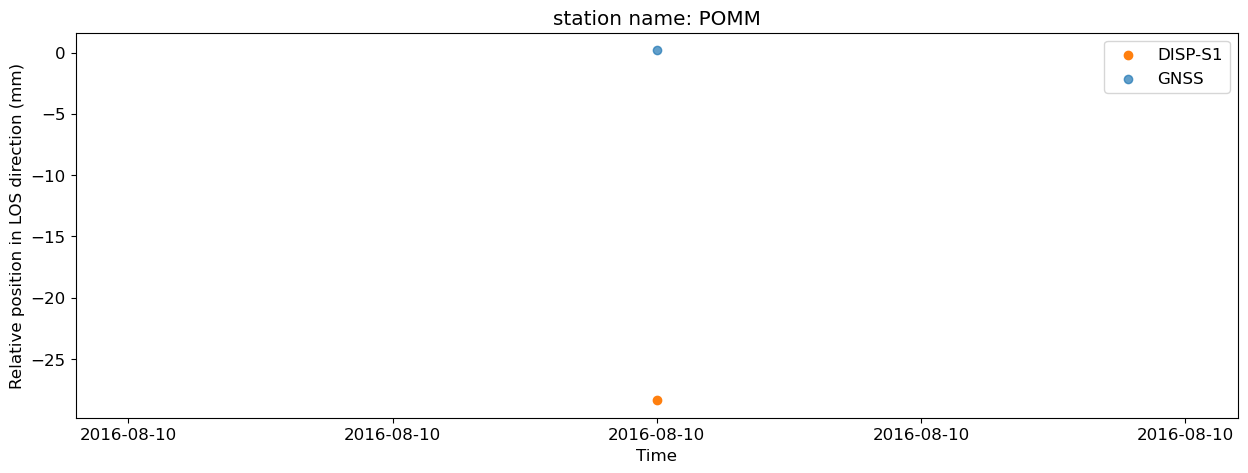

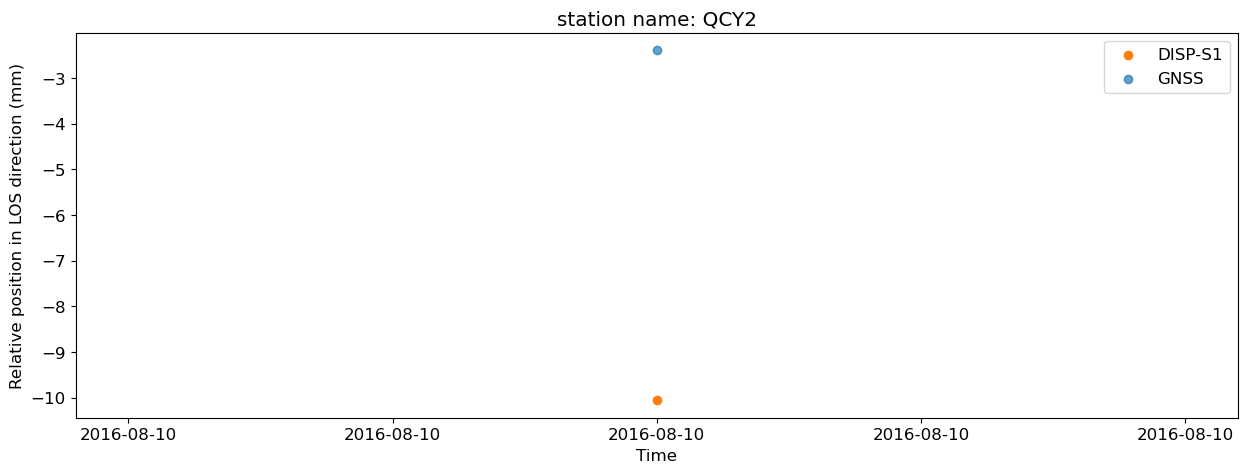

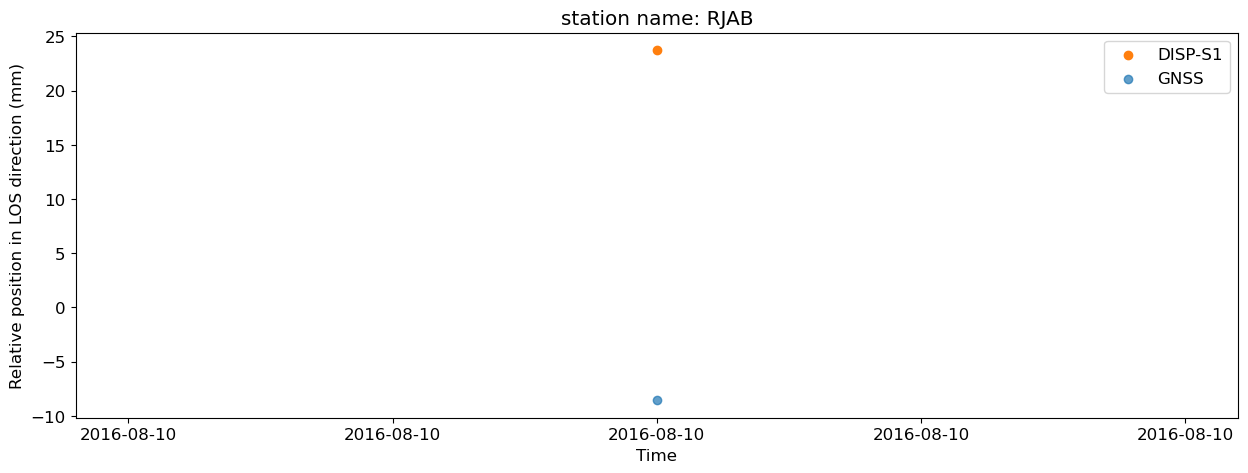

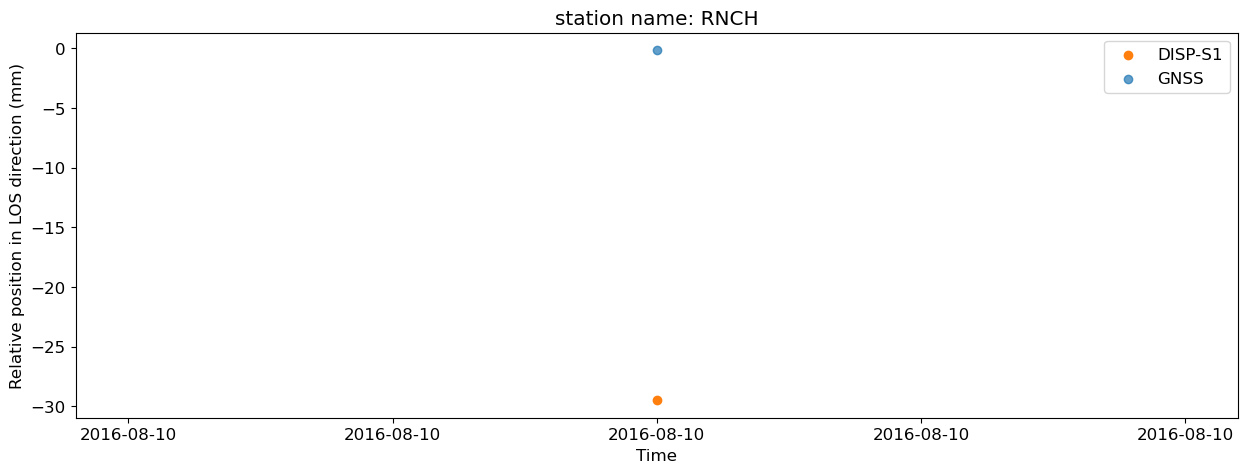

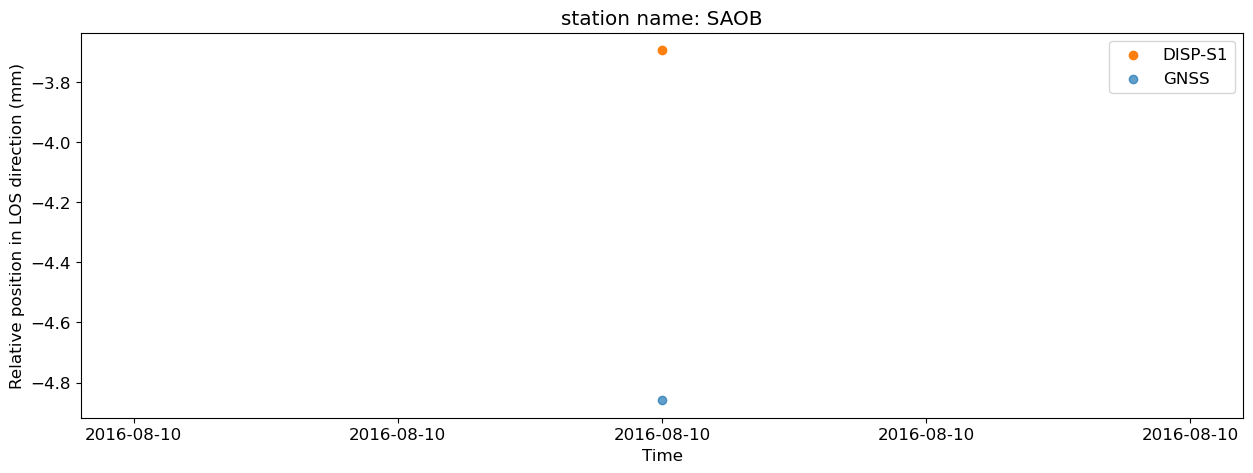

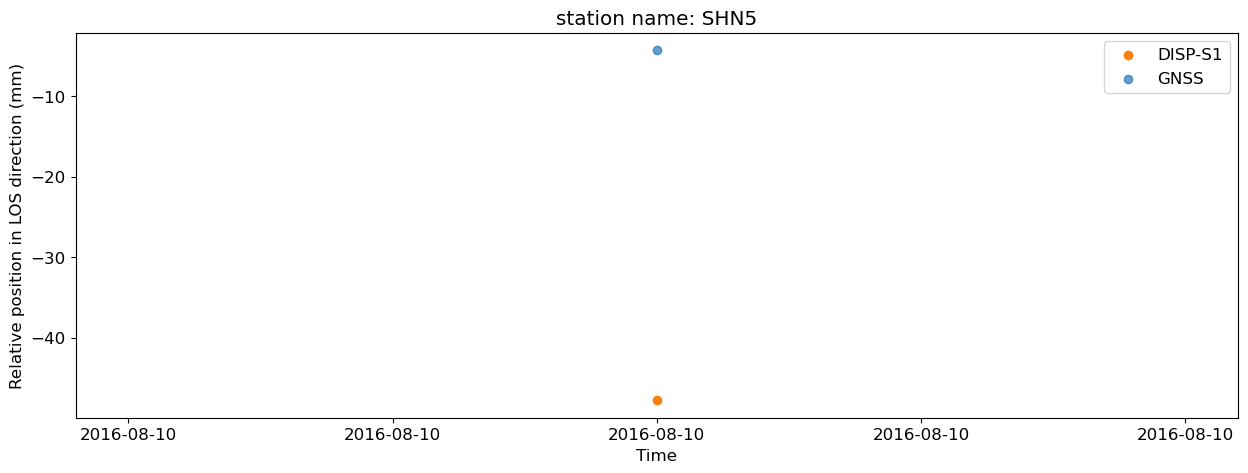

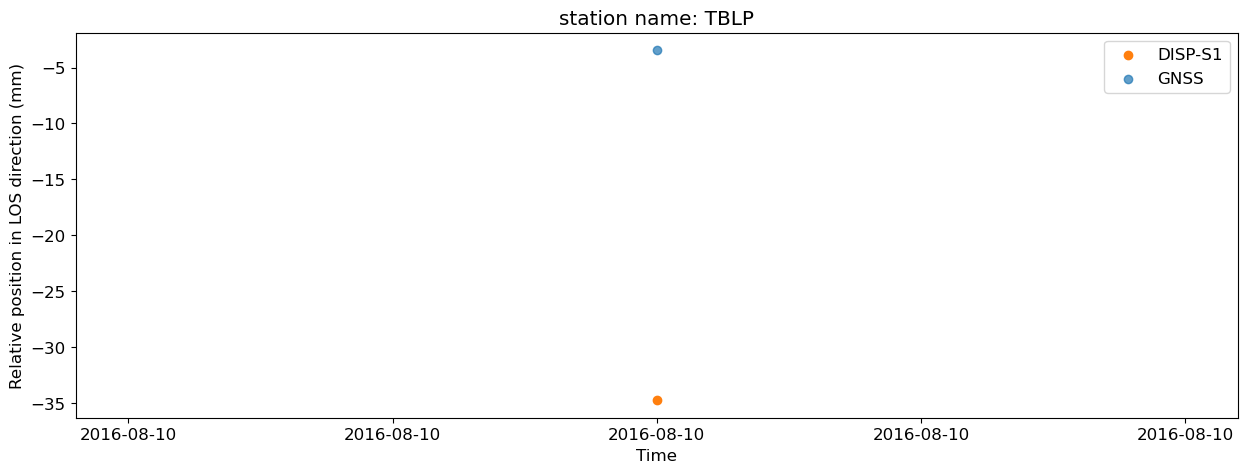

In [63]:
gnss_disp_s1_ts_plots_flag = True   # comparison of time-series gnss and DISP-S1

if gnss_disp_s1_ts_plots_flag:
    gps_ref_site_name = sites_df[sites_df["site"]==site]["gps_ref_site_name"].values[0]
    for stn in site_names:
        date_list = []
        gnss_series = []
        disp_s1_series = []
        for i in dates_index:
            # catch cases where GPS site has been filtered out
            try:
                ref_gnss_dat = displacement.loc[(i,gps_ref_site_name),'gnss_disp']
                ref_disp_s1_dat = displacement.loc[(i,gps_ref_site_name),'disp_s1']
                gnss_series.append(displacement.loc[(i,str(stn)),'gnss_disp'] - ref_gnss_dat)
                disp_s1_series.append(displacement.loc[(i,str(stn)),'disp_s1'] - ref_disp_s1_dat)
                date_list.append(ifgs_date_dt[i,1].strftime('%Y%m%d'))
            except KeyError:
                pass

        # only plot for cases where GPS site has not been filtered out
        if date_list != [] and gnss_series != [] and disp_s1_series != []:
            dt_date_list = [dt.strptime(date, '%Y%m%d').strftime('%Y-%m-%d') for date in date_list]
            # plot station TS
            fig, ax = plt.subplots(figsize=(15, 5))
            ax.set_title(f"station name: {stn}")
            ax.scatter(dt_date_list, disp_s1_series, c='#ff7f0e', label="DISP-S1")
            ax.scatter(dt_date_list, gnss_series, c='#1f77b4', label="GNSS", alpha=0.7)
            ax.set_xlabel('Time')
            ax.set_ylabel('Relative position in LOS direction (mm)')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
            ax.legend()
            plt.show()